# Initialize Libraries

In [254]:
var = None

In [255]:
import numpy as np
import networkx as nx
import copy
import matplotlib.pyplot as plt
import pandas as pd

class adjmatrix:
    def __init__(self):
        # initialize a 1000x1000 matrix *mainly distance
        size = 10
        
        #edges
        self.matrix = np.zeros(shape=(size,size))
        self.edge_uv = np.array([[np.nan,np.nan,np.nan,np.nan]]) #np.empty(shape=[0, 4])
        
        #nodes
        self.nodedata = np.array([[0,0,0,0]]) # x,y,theta,z, includes features and poses (MEASURED)
        self.node = np.array([0]) # +1 for pose, -1 for landmarks, max is pose, min is landmarks
        
        self.converge = np.array([[]]) # store convergence
        
        self.cost = []
        
    # U is the pose to pose measurements
    def posetopose(self, uX, uY, uO, uZ):
        
        lastpose = max(self.node)
        ind, = np.where(self.node == lastpose)
        index_lastpose = ind[0]
        
        u = np.array([uX, uY, uO, uZ])
        
        #1 add a new node (pose) 
        node_type = max(self.node)+1  #pose index max + 1
        self.node = np.append(self.node, node_type)
        self.nodedata = np.append(self.nodedata, [self.nodedata[index_lastpose] + u], axis = 0) #measured node = U + previous node

        #2 add a new edge
        self.edge_uv = np.append(self.edge_uv, [u], axis = 0) #append u
        index_lastedge = len(self.edge_uv)-1
        self.matrix[index_lastpose][len(self.node)-1] = index_lastedge  #pose to newest node

    def posetonewfeat(self, vX, vY, vO, vZ):
        
        lastpose = max(self.node)
        ind, = np.where(self.node == lastpose)
        index_lastpose = ind[0]
        
        v = np.array([vX, vY, vO, vZ])
        
        #1 add a new node (feature)
        node_type =  min(self.node)-1 #pose index max + 1
        self.node = np.append(self.node, node_type)
        self.nodedata = np.append(self.nodedata, [self.nodedata[index_lastpose] + v], axis = 0) #measured node = U + previous node
        
        
        #2 add a new edge
        self.edge_uv = np.append(self.edge_uv, [v], axis = 0) #append u
        index_newedge = len(self.edge_uv)-1
        self.matrix[index_lastpose][len(self.node)-1] = index_newedge  #pose to newest node
        
    def posetooldfeat(self,vX, vY, vO, vZ, feat):
        
        lastpose = max(self.node)
        ind, = np.where(self.node == lastpose)
        index_lastpose = ind[0]
        
        v = np.array([vX, vY, vO, vZ])
        
        #1 add a new node (feature)
        #dont do anything
        
        #2 add a new edge
        self.edge_uv = np.append(self.edge_uv, [v], axis = 0) #append u
        index_newedge = len(self.edge_uv)-1 #index of new edge
        
        feat_index = np.where(self.node == feat)
        
        self.matrix[index_lastpose][feat_index] = index_newedge  #pose to newest node

    
    def getcost(self, nodedata):
        x = np.where(self.matrix != 0)
        edges = np.asarray(x).T
        cost = 0
        for edge in edges:
            node_1 = nodedata[edge[1]] #node coordinates
            node_2 = nodedata[edge[0]] #node coordinates
            meas = self.edge_uv[int(self.matrix[edge[0]][edge[1]])]
            #print(node_1,node_2,meas)
            
            if self.node[edge[1]] > 0 and self.node[edge[0]] > 0 : #if pose to pose, dont count z
                #remove z values in error
                error = node_1 - node_2 - meas
                error = error - np.array([0,0,0,error[3]])
                errorsq = (error)**2
                #print("p2p")
                
            else: #if pose to feat, dont count o
                #remove o values
                error = node_1 - node_2 - meas
                error = error - np.array([0,0,error[2],error[3]])
                errorsq = (error)**2
                #print("p2f")
    
            cost = cost + np.linalg.norm(errorsq)
        #print ("cost",cost)
        return cost
        
    def getgradient(self,state):
        
        ind = []
        outd = []
        factor = []
        for i in range(len(self.node)):
            in_d = np.count_nonzero(self.matrix[:, i])
            out_d = np.count_nonzero(self.matrix[i, :])
            ind.append(in_d)
            outd.append(out_d)
            factor.append(-2*(out_d-in_d))
        print("in", ind)
        print("out", outd)
        print("factor", factor)
        print("\n")
        
        return factor
    
    
    def graph_posegraph(self,nodedata,i):
        
        if nodedata == []:
            nodedata = self.nodedata
        
        amat = self.matrix
        g = nx.from_numpy_matrix(amat, create_using=nx.DiGraph)
        g.remove_nodes_from(list(nx.isolates(g)))
        
        #relabelling
        mapping = dict(zip(g, self.node))
        g = nx.relabel_nodes(g, mapping)
        
        #colourmap
        color_map = []
        for node in g.nodes:
            if node < 0:
                color_map.append('red')
            else: 
                color_map.append('white')      
                
        #layout
        layout = nx.spectral_layout(g)
        #layout = nx.spring_layout(g)
        
        #position
        position = copy.deepcopy(nodedata)
        ps = []
        for pos in position:
            ps.append(pos[:2])
        
        z = zip(self.node, ps)
        dic = dict(z)
        
        fig, ax = plt.subplots()
        
        nx.draw_networkx(g, pos=dic, node_color= color_map, with_labels = True)
        nx.draw_networkx_labels(g, pos=dic)
        plt.axis("on")
        #ax.set_xlim(-1, 8)
        #ax.set_ylim(-1,8)
        ax.set_xlim(-1, 1)
        ax.set_ylim(-1, 1)
        
        ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
        
        plt.savefig("pose/{}.jpg".format(i))
        plt.show()
        #print (amat)
        
        
    def gd(self, iterations, learning_rate, stopping_threshold, posegraph):
        
        currentstate = self.nodedata
        print("original")
        print(currentstate)
        
        factor = np.array(self.getgradient(currentstate))
        
        
        #copy to new
        newstate = copy.deepcopy(currentstate)
        previouscost = self.getcost(newstate)

        #learn
        for i in range(iterations):#
            
            if previouscost == 0: #perfect calculations
                break
            
            #print nodes update
            if (i % 1 == 0):
                print(i)
                print(newstate)
                if posegraph == True:
                    self.graph_posegraph(newstate,i)
            
            #get gradient
            gradient = copy.deepcopy(newstate)
            for i in range(gradient.shape[0]): #by nodes.
                
                if self.node[i] > 0: #pose node; remove all z
                    gradient[i] = gradient[i] - np.array([0,0,gradient[i][2],gradient[i][3]])
                else: #feat node; remove all o
                    gradient[i] = gradient[i] - np.array([0,0,gradient[i][2],0])
                    
                gradient[i] = gradient[i]*factor[i]
            #print("gradient\n",gradient)
            
            newstate = newstate + learning_rate*gradient #ONLY UPDATE THE NECCESSARY VARIABLES.
            currentcost = self.getcost(newstate)
            print ("curcost",currentcost)
            print()
            self.cost.append(currentcost)
            #print ("prvcost",previouscost)
            
            if currentcost > previouscost:
                break
            
            previouscost = currentcost 
        
        print("converge")
        print(newstate)
        self.converge = newstate
    
        
    def graph_location(self, nodedata):
        pose_ind, = np.where(self.node >= 0)
        land_ind, = np.where(self.node < 0)
        print (pose_ind,land_ind)
        #colour identity
    
    def pr(self):
        print ("node (pose/landmark)\n",self.node)
        print ("nodedata (assumed state)\n",self.nodedata)
        print ("edgedata (u/v)\n",self.edge_uv)
        print ("\n")
        print (np.matrix(self.matrix))
        print ()
    
    def prcost(self):
        ite = list(range(0, len(self.cost)))
        cs = self.cost
        plt.plot(ite,cs)
        plt.title('Cost vs Iterations')
        plt.xlabel('Iterations')
        plt.ylabel('Costs')
        plt.show()
        #print (self.cost)
         

# Intializing Matrix, 
Measured Data (from excel)
Compare with Ground Truth

In [256]:
df = pd.read_csv("dataset/e3v2.csv")
df = df[0:10]
df

Type  Match  Node         x         y             o             z
0  Pose    NaN     1  0.000246 -0.000019     -0.000348 -99999.000000
1  Feat    NaN    -1  0.398369 -0.004103 -99999.000000      0.127412
2  Feat    NaN    -2  0.368862 -0.154889 -99999.000000      0.136918
3  Pose    NaN     2 -0.291175 -0.007319      0.225321 -99999.000000
4  Feat   -1.0    -1  0.794421 -0.311625 -99999.000000      0.169411
5  Feat    NaN    -3  0.796759 -0.312737 -99999.000000      0.171712
6  Pose    NaN     3 -0.309739 -0.004296      0.099392 -99999.000000
7  Feat   -2.0    -2  0.969460 -0.737469 -99999.000000     -0.143533
8  Feat    NaN    -4  0.969352 -0.736340 -99999.000000     -0.142006
9  Feat   -1.0    -1  1.097280 -0.617076 -99999.000000      0.174748

In [257]:
a = adjmatrix() 
for i in range(len(df)):
    e  = df.iloc[i]
    if e.Type == 'Pose':
        a.posetopose(e.x,e.y,e.o,e.z) #new pose x,y,o,{z}
    else:
        if pd.isna(e.Match):
            #add new feat
            a.posetonewfeat(e.x,e.y,e.o,e.z)
        else:
            #old feat, link
            a.posetooldfeat(e.x,e.y,e.o,e.z,e.Match)

# Visualize Gradient Descent

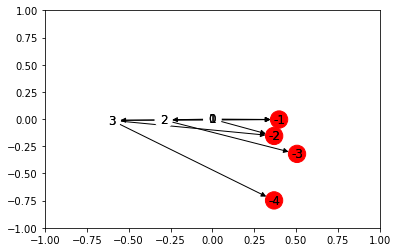

In [258]:
a.graph_posegraph([],0)

In [259]:
#a.nodedata[np.where(a.node>0)

# Visualize Gradient Descent

In [260]:
import os
import glob

#Clear 
files = glob.glob('pose/*')
for f in files:
    os.remove(f)

original
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.45727000e-04 -1.94000000e-05 -3.48399000e-04 -9.99990000e+04]
 [ 3.98614800e-01 -4.12261100e-03 -9.99990003e+04 -9.99988726e+04]
 [ 3.69107934e-01 -1.54907971e-01 -9.99990003e+04 -9.99988631e+04]
 [-2.90929731e-01 -7.33817100e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.05829471e-01 -3.20075473e-01 -9.99987750e+04 -1.99997828e+05]
 [-6.00668670e-01 -1.16344390e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.68683721e-01 -7.47974507e-01 -9.99986756e+04 -2.99997142e+05]]
in [0, 1, 3, 2, 1, 1, 1, 1]
out [1, 3, 0, 0, 3, 0, 3, 0]
factor [-2, -4, 6, 4, -4, 2, -4, 2]


0
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.45727000e-04 -1.94000000e-05 -3.48399000e-04 -9.99990000e+04]
 [ 3.98614800e-01 -4.12261100e-03 -9.99990003e+04 -9.99988726e+04]
 [ 3.69107934e-01 -1.54907971e-01 -9.99990003e+04 -9.99988631e+04]
 [-2.90929731e-01 -7.33817100e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.05829471e-01 -3.2

<ipython-input-255-13ff3fe94d4e>:131: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if nodedata == []:


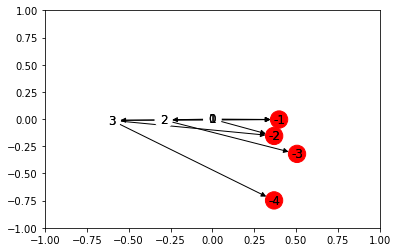

curcost 0.8429345719828575

1
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.45628709e-04 -1.93922400e-05 -3.48399000e-04 -9.99990000e+04]
 [ 3.98853969e-01 -4.12508457e-03 -9.99990003e+04 -1.00058872e+05]
 [ 3.69255577e-01 -1.54969934e-01 -9.99990003e+04 -1.00038863e+05]
 [-2.90813359e-01 -7.33523573e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.05930637e-01 -3.20139488e-01 -9.99987750e+04 -2.00037828e+05]
 [-6.00428403e-01 -1.16297852e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.68757458e-01 -7.48124102e-01 -9.99986756e+04 -3.00057141e+05]]


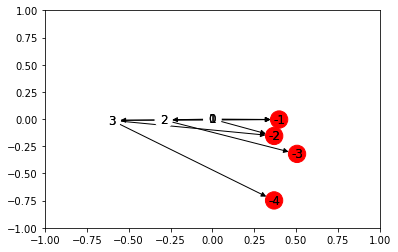

curcost 0.8428407277912519

2
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.45530458e-04 -1.93844831e-05 -3.48399000e-04 -9.99990000e+04]
 [ 3.99093281e-01 -4.12755962e-03 -9.99990003e+04 -1.00118907e+05]
 [ 3.69403279e-01 -1.55031922e-01 -9.99990003e+04 -1.00078878e+05]
 [-2.90697034e-01 -7.33230164e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.06031823e-01 -3.20203516e-01 -9.99987750e+04 -2.00077835e+05]
 [-6.00188231e-01 -1.16251333e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.68831209e-01 -7.48273727e-01 -9.99986756e+04 -3.00117153e+05]]


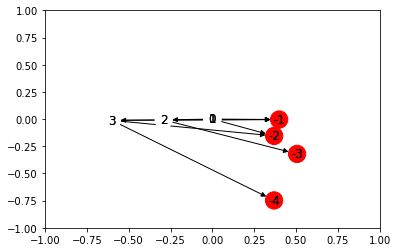

curcost 0.8427471687771475

3
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.45432246e-04 -1.93767293e-05 -3.48399000e-04 -9.99990000e+04]
 [ 3.99332737e-01 -4.13003615e-03 -9.99990003e+04 -1.00178979e+05]
 [ 3.69551041e-01 -1.55093935e-01 -9.99990003e+04 -1.00118910e+05]
 [-2.90580755e-01 -7.32936872e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.06133029e-01 -3.20267557e-01 -9.99987750e+04 -2.00117851e+05]
 [-5.99948156e-01 -1.16204833e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.68904975e-01 -7.48423381e-01 -9.99986756e+04 -3.00177176e+05]]


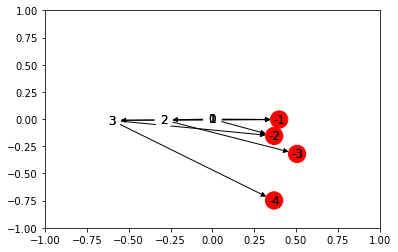

curcost 0.8426538950839073

4
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.45334073e-04 -1.93689786e-05 -3.48399000e-04 -9.99990000e+04]
 [ 3.99572337e-01 -4.13251417e-03 -9.99990003e+04 -1.00239086e+05]
 [ 3.69698861e-01 -1.55155973e-01 -9.99990003e+04 -1.00158957e+05]
 [-2.90464523e-01 -7.32643697e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.06234256e-01 -3.20331610e-01 -9.99987750e+04 -2.00157875e+05]
 [-5.99708177e-01 -1.16158351e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.68978756e-01 -7.48573066e-01 -9.99986756e+04 -3.00237212e+05]]


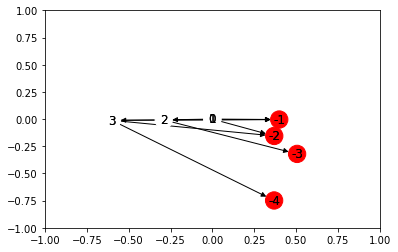

curcost 0.8425609068554187

5
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.45235939e-04 -1.93612310e-05 -3.48399000e-04 -9.99990000e+04]
 [ 3.99812080e-01 -4.13499368e-03 -9.99990003e+04 -1.00299229e+05]
 [ 3.69846741e-01 -1.55218035e-01 -9.99990003e+04 -1.00199021e+05]
 [-2.90348337e-01 -7.32350639e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.06335503e-01 -3.20395677e-01 -9.99987750e+04 -2.00197906e+05]
 [-5.99468293e-01 -1.16111887e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.69052552e-01 -7.48722781e-01 -9.99986756e+04 -3.00297259e+05]]


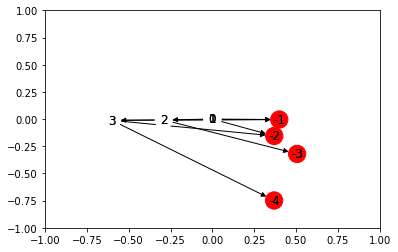

curcost 0.842468204236094

6
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.45137845e-04 -1.93534865e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.00051968e-01 -4.13747468e-03 -9.99990003e+04 -1.00359409e+05]
 [ 3.69994679e-01 -1.55280122e-01 -9.99990003e+04 -1.00239100e+05]
 [-2.90232198e-01 -7.32057699e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.06436770e-01 -3.20459756e-01 -9.99987750e+04 -2.00237946e+05]
 [-5.99228506e-01 -1.16065443e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.69126363e-01 -7.48872525e-01 -9.99986756e+04 -3.00357319e+05]]


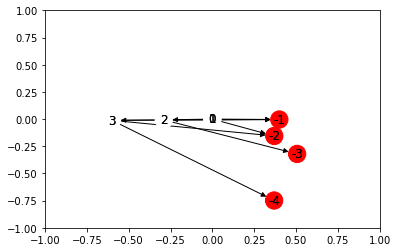

curcost 0.8423757873708694

7
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.45039789e-04 -1.93457451e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.00291999e-01 -4.13995716e-03 -9.99990003e+04 -1.00419625e+05]
 [ 3.70142677e-01 -1.55342234e-01 -9.99990003e+04 -1.00279196e+05]
 [-2.90116105e-01 -7.31764876e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.06538057e-01 -3.20523848e-01 -9.99987750e+04 -2.00277993e+05]
 [-5.98988815e-01 -1.16019016e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.69200188e-01 -7.49022300e-01 -9.99986756e+04 -3.00417390e+05]]


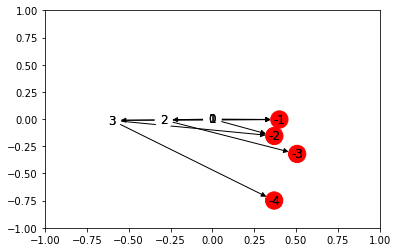

curcost 0.8422836564052064

8
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.44941774e-04 -1.93380068e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.00532174e-01 -4.14244114e-03 -9.99990003e+04 -1.00479876e+05]
 [ 3.70290734e-01 -1.55404371e-01 -9.99990003e+04 -1.00319308e+05]
 [-2.90000058e-01 -7.31472170e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.06639365e-01 -3.20587952e-01 -9.99987750e+04 -2.00318049e+05]
 [-5.98749219e-01 -1.15972609e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.69274028e-01 -7.49172104e-01 -9.99986756e+04 -3.00477474e+05]]


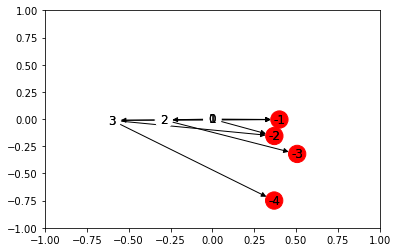

curcost 0.8421918114850906

9
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.44843797e-04 -1.93302716e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.00772493e-01 -4.14492660e-03 -9.99990003e+04 -1.00540164e+05]
 [ 3.70438851e-01 -1.55466533e-01 -9.99990003e+04 -1.00359436e+05]
 [-2.89884058e-01 -7.31179581e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.06740693e-01 -3.20652070e-01 -9.99987750e+04 -2.00358113e+05]
 [-5.98509719e-01 -1.15926220e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.69347883e-01 -7.49321939e-01 -9.99986756e+04 -3.00537569e+05]]


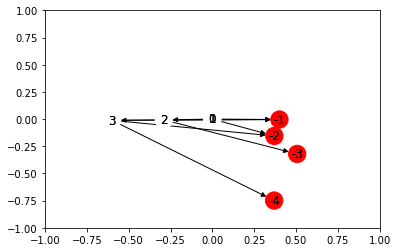

curcost 0.84210025275703

10
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.44745859e-04 -1.93225395e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.01012957e-01 -4.14741356e-03 -9.99990003e+04 -1.00600488e+05]
 [ 3.70587026e-01 -1.55528719e-01 -9.99990003e+04 -1.00399579e+05]
 [-2.89768105e-01 -7.30887109e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.06842041e-01 -3.20716200e-01 -9.99987750e+04 -2.00398184e+05]
 [-5.98270316e-01 -1.15879849e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.69421752e-01 -7.49471803e-01 -9.99986756e+04 -3.00597677e+05]]


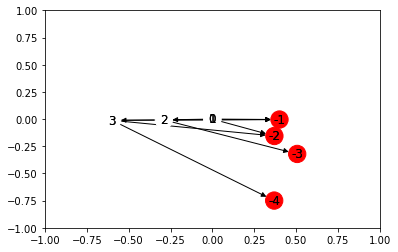

curcost 0.8420089803680577

11
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.44647961e-04 -1.93148105e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.01253564e-01 -4.14990201e-03 -9.99990003e+04 -1.00660849e+05]
 [ 3.70735261e-01 -1.55590931e-01 -9.99990003e+04 -1.00439739e+05]
 [-2.89652197e-01 -7.30594755e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.06943409e-01 -3.20780344e-01 -9.99987750e+04 -2.00438264e+05]
 [-5.98031007e-01 -1.15833497e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.69495637e-01 -7.49621697e-01 -9.99986756e+04 -3.00657796e+05]]


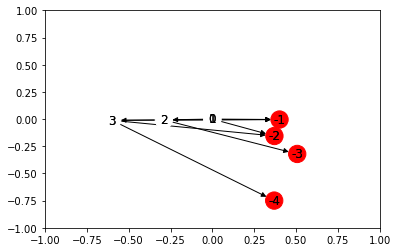

curcost 0.841917994465729

12
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.44550102e-04 -1.93070846e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.01494317e-01 -4.15239195e-03 -9.99990003e+04 -1.00721245e+05]
 [ 3.70883555e-01 -1.55653167e-01 -9.99990003e+04 -1.00479915e+05]
 [-2.89536336e-01 -7.30302517e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.07044798e-01 -3.20844500e-01 -9.99987750e+04 -2.00478351e+05]
 [-5.97791795e-01 -1.15787164e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.69569536e-01 -7.49771622e-01 -9.99986756e+04 -3.00717928e+05]]


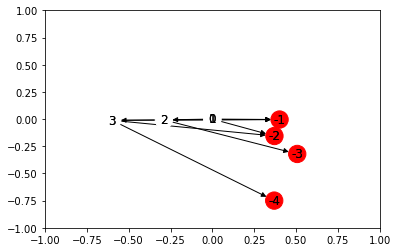

curcost 0.8418272951981226

13
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.44452282e-04 -1.92993618e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.01735213e-01 -4.15488338e-03 -9.99990003e+04 -1.00781678e+05]
 [ 3.71031908e-01 -1.55715429e-01 -9.99990003e+04 -1.00520107e+05]
 [-2.89420522e-01 -7.30010396e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.07146207e-01 -3.20908669e-01 -9.99987750e+04 -2.00518447e+05]
 [-5.97552678e-01 -1.15740849e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.69643450e-01 -7.49921576e-01 -9.99986756e+04 -3.00778071e+05]]


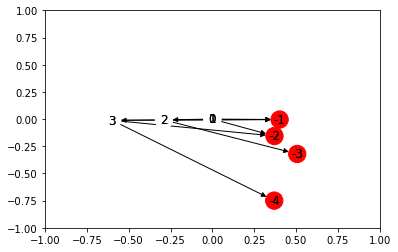

curcost 0.8417368827138394

14
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.44354501e-04 -1.92916420e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.01976254e-01 -4.15737631e-03 -9.99990003e+04 -1.00842147e+05]
 [ 3.71180321e-01 -1.55777715e-01 -9.99990003e+04 -1.00560315e+05]
 [-2.89304754e-01 -7.29718392e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.07247636e-01 -3.20972850e-01 -9.99987750e+04 -2.00558551e+05]
 [-5.97313657e-01 -1.15694553e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.69717379e-01 -7.50071560e-01 -9.99986756e+04 -3.00838227e+05]]


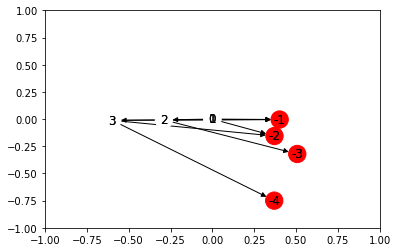

curcost 0.841646757162004

15
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.44256759e-04 -1.92839254e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.02217440e-01 -4.15987074e-03 -9.99990003e+04 -1.00902652e+05]
 [ 3.71328793e-01 -1.55840026e-01 -9.99990003e+04 -1.00600539e+05]
 [-2.89189032e-01 -7.29426504e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.07349086e-01 -3.21037045e-01 -9.99987750e+04 -2.00598662e+05]
 [-5.97074732e-01 -1.15648275e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.69791322e-01 -7.50221575e-01 -9.99986756e+04 -3.00898395e+05]]


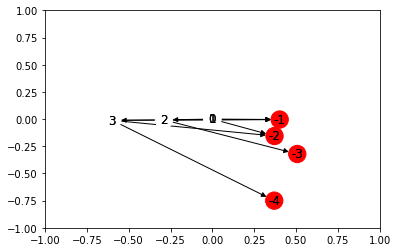

curcost 0.8415569186922618

16
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.44159056e-04 -1.92762118e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.02458771e-01 -4.16236666e-03 -9.99990003e+04 -1.00963194e+05]
 [ 3.71477325e-01 -1.55902362e-01 -9.99990003e+04 -1.00640779e+05]
 [-2.89073356e-01 -7.29134734e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.07450556e-01 -3.21101252e-01 -9.99987750e+04 -2.00638782e+05]
 [-5.96835902e-01 -1.15602016e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.69865280e-01 -7.50371619e-01 -9.99986756e+04 -3.00958574e+05]]


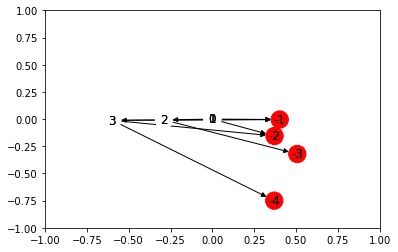

curcost 0.8414673674547807

17
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.44061393e-04 -1.92685013e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.02700246e-01 -4.16486408e-03 -9.99990003e+04 -1.01023772e+05]
 [ 3.71625916e-01 -1.55964723e-01 -9.99990003e+04 -1.00681036e+05]
 [-2.88957727e-01 -7.28843080e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.07552046e-01 -3.21165473e-01 -9.99987750e+04 -2.00678910e+05]
 [-5.96597167e-01 -1.15555775e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.69939253e-01 -7.50521693e-01 -9.99986756e+04 -3.01018766e+05]]


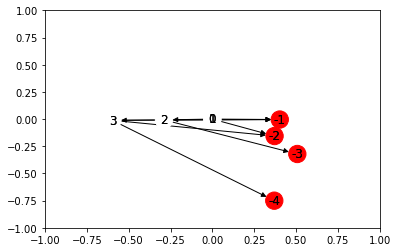

curcost 0.8413781036002504

18
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.43963768e-04 -1.92607939e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.02941866e-01 -4.16736300e-03 -9.99990003e+04 -1.01084386e+05]
 [ 3.71774566e-01 -1.56027109e-01 -9.99990003e+04 -1.00721308e+05]
 [-2.88842144e-01 -7.28551542e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.07653556e-01 -3.21229706e-01 -9.99987750e+04 -2.00719046e+05]
 [-5.96358529e-01 -1.15509552e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.70013241e-01 -7.50671798e-01 -9.99986756e+04 -3.01078970e+05]]


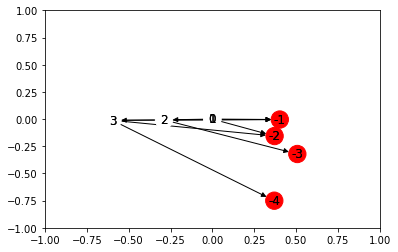

curcost 0.8412891272798823

19
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.43866183e-04 -1.92530896e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.03183631e-01 -4.16986342e-03 -9.99990003e+04 -1.01145037e+05]
 [ 3.71923276e-01 -1.56089519e-01 -9.99990003e+04 -1.00761597e+05]
 [-2.88726607e-01 -7.28260122e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.07755087e-01 -3.21293952e-01 -9.99987750e+04 -2.00759190e+05]
 [-5.96119985e-01 -1.15463349e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.70087244e-01 -7.50821932e-01 -9.99986756e+04 -3.01139185e+05]]


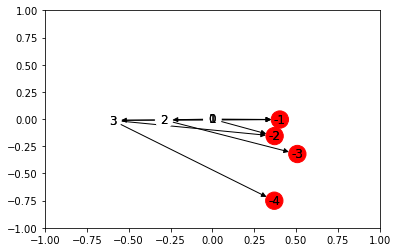

curcost 0.841200438645408

20
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.43768636e-04 -1.92453883e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.03425541e-01 -4.17236534e-03 -9.99990003e+04 -1.01205724e+05]
 [ 3.72072045e-01 -1.56151955e-01 -9.99990003e+04 -1.00801901e+05]
 [-2.88611116e-01 -7.27968818e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.07856638e-01 -3.21358210e-01 -9.99987750e+04 -2.00799341e+05]
 [-5.95881537e-01 -1.15417163e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.70161261e-01 -7.50972096e-01 -9.99986756e+04 -3.01199413e+05]]


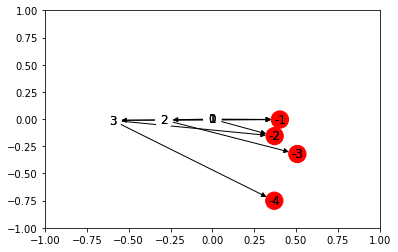

curcost 0.8411120378490815

21
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.43671129e-04 -1.92376902e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.03667597e-01 -4.17486876e-03 -9.99990003e+04 -1.01266447e+05]
 [ 3.72220874e-01 -1.56214416e-01 -9.99990003e+04 -1.00842222e+05]
 [-2.88495672e-01 -7.27677630e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.07958209e-01 -3.21422482e-01 -9.99987750e+04 -2.00839501e+05]
 [-5.95643185e-01 -1.15370996e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.70235293e-01 -7.51122291e-01 -9.99986756e+04 -3.01259653e+05]]


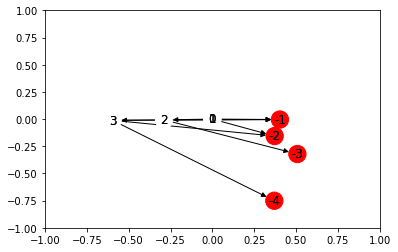

curcost 0.841023925043676

22
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.43573660e-04 -1.92299951e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.03909797e-01 -4.17737368e-03 -9.99990003e+04 -1.01327207e+05]
 [ 3.72369762e-01 -1.56276902e-01 -9.99990003e+04 -1.00882559e+05]
 [-2.88380274e-01 -7.27386559e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.08059801e-01 -3.21486767e-01 -9.99987750e+04 -2.00879669e+05]
 [-5.95404927e-01 -1.15324848e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.70309341e-01 -7.51272515e-01 -9.99986756e+04 -3.01319905e+05]]


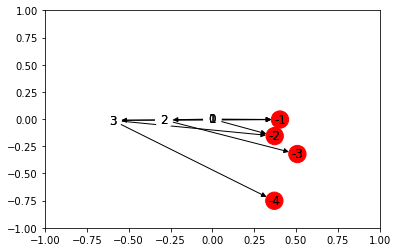

curcost 0.8409361003824862

23
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.43476231e-04 -1.92223031e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.04152143e-01 -4.17988010e-03 -9.99990003e+04 -1.01388003e+05]
 [ 3.72518710e-01 -1.56339413e-01 -9.99990003e+04 -1.00922912e+05]
 [-2.88264921e-01 -7.27095605e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.08161413e-01 -3.21551064e-01 -9.99987750e+04 -2.00919845e+05]
 [-5.95166765e-01 -1.15278718e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.70383402e-01 -7.51422770e-01 -9.99986756e+04 -3.01380169e+05]]


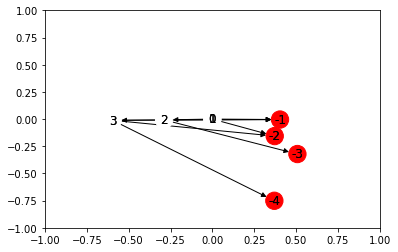

curcost 0.8408485640193263

24
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.43378840e-04 -1.92146142e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.04394634e-01 -4.18238803e-03 -9.99990003e+04 -1.01448836e+05]
 [ 3.72667718e-01 -1.56401948e-01 -9.99990003e+04 -1.00963281e+05]
 [-2.88149615e-01 -7.26804766e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.08263045e-01 -3.21615374e-01 -9.99987750e+04 -2.00960029e+05]
 [-5.94928699e-01 -1.15232607e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.70457479e-01 -7.51573054e-01 -9.99986756e+04 -3.01440445e+05]]


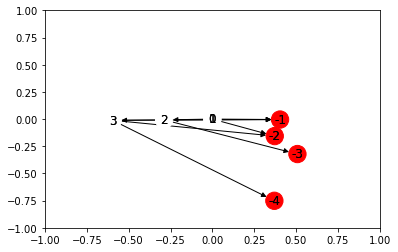

curcost 0.8407613161085311

25
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.43281489e-04 -1.92069284e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.04637271e-01 -4.18489746e-03 -9.99990003e+04 -1.01509705e+05]
 [ 3.72816785e-01 -1.56464509e-01 -9.99990003e+04 -1.01003666e+05]
 [-2.88034356e-01 -7.26514044e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.08364698e-01 -3.21679697e-01 -9.99987750e+04 -2.01000221e+05]
 [-5.94690727e-01 -1.15186514e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.70531571e-01 -7.51723369e-01 -9.99986756e+04 -3.01500733e+05]]


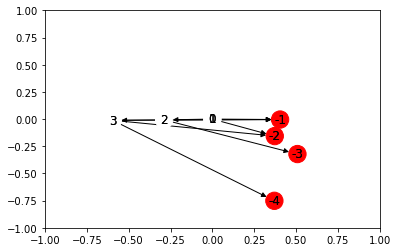

curcost 0.8406743568049543

26
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.43184176e-04 -1.91992456e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.04880053e-01 -4.18740840e-03 -9.99990003e+04 -1.01570611e+05]
 [ 3.72965912e-01 -1.56527095e-01 -9.99990003e+04 -1.01044068e+05]
 [-2.87919142e-01 -7.26223439e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.08466371e-01 -3.21744033e-01 -9.99987750e+04 -2.01040421e+05]
 [-5.94452851e-01 -1.15140439e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.70605677e-01 -7.51873714e-01 -9.99986756e+04 -3.01561033e+05]]


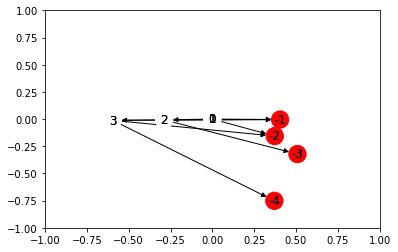

curcost 0.8405876862639697

27
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.43086903e-04 -1.91915659e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.05122981e-01 -4.18992085e-03 -9.99990003e+04 -1.01631554e+05]
 [ 3.73115098e-01 -1.56589706e-01 -9.99990003e+04 -1.01084486e+05]
 [-2.87803974e-01 -7.25932949e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.08568064e-01 -3.21808382e-01 -9.99987750e+04 -2.01080629e+05]
 [-5.94215070e-01 -1.15094383e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.70679798e-01 -7.52024088e-01 -9.99986756e+04 -3.01621346e+05]]


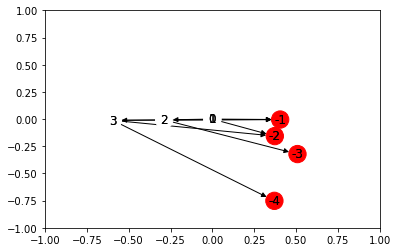

curcost 0.8405013046414702

28
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.42989668e-04 -1.91838893e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.05366055e-01 -4.19243480e-03 -9.99990003e+04 -1.01692533e+05]
 [ 3.73264344e-01 -1.56652342e-01 -9.99990003e+04 -1.01124919e+05]
 [-2.87688853e-01 -7.25642576e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.08669777e-01 -3.21872744e-01 -9.99987750e+04 -2.01120845e+05]
 [-5.93977384e-01 -1.15048345e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.70753934e-01 -7.52174493e-01 -9.99986756e+04 -3.01681670e+05]]


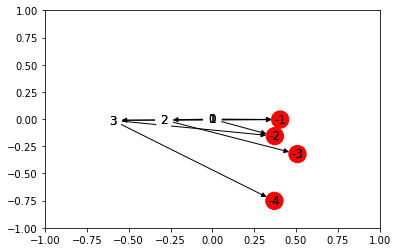

curcost 0.8404152120938673

29
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.42892472e-04 -1.91762157e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.05609275e-01 -4.19495026e-03 -9.99990003e+04 -1.01753548e+05]
 [ 3.73413650e-01 -1.56715003e-01 -9.99990003e+04 -1.01165369e+05]
 [-2.87573777e-01 -7.25352319e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.08771511e-01 -3.21937118e-01 -9.99987750e+04 -2.01161070e+05]
 [-5.93739793e-01 -1.15002326e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.70828085e-01 -7.52324928e-01 -9.99986756e+04 -3.01742006e+05]]


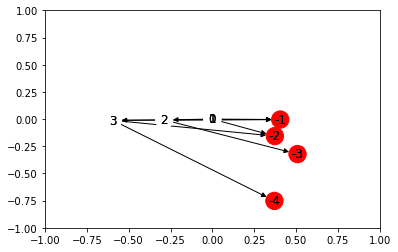

curcost 0.8403294087780919

30
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.42795315e-04 -1.91685452e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.05852640e-01 -4.19746723e-03 -9.99990003e+04 -1.01814600e+05]
 [ 3.73563015e-01 -1.56777689e-01 -9.99990003e+04 -1.01205835e+05]
 [-2.87458748e-01 -7.25062178e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.08873266e-01 -3.22001506e-01 -9.99987750e+04 -2.01201302e+05]
 [-5.93502297e-01 -1.14956325e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.70902250e-01 -7.52475393e-01 -9.99986756e+04 -3.01802355e+05]]


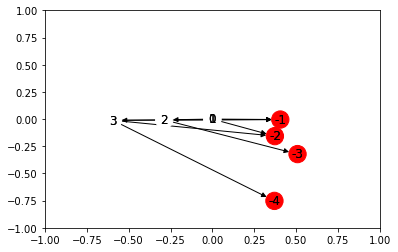

curcost 0.8402438948515925

31
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.42698197e-04 -1.91608778e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.06096152e-01 -4.19998571e-03 -9.99990003e+04 -1.01875689e+05]
 [ 3.73712440e-01 -1.56840400e-01 -9.99990003e+04 -1.01246318e+05]
 [-2.87343764e-01 -7.24772153e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.08975040e-01 -3.22065906e-01 -9.99987750e+04 -2.01241542e+05]
 [-5.93264896e-01 -1.14910342e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.70976431e-01 -7.52625888e-01 -9.99986756e+04 -3.01862715e+05]]


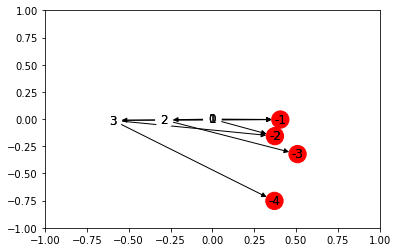

curcost 0.8401586704723362

32
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.42601118e-04 -1.91532134e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.06339810e-01 -4.20250570e-03 -9.99990003e+04 -1.01936814e+05]
 [ 3.73861925e-01 -1.56903136e-01 -9.99990003e+04 -1.01286816e+05]
 [-2.87228827e-01 -7.24482245e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.09076835e-01 -3.22130319e-01 -9.99987750e+04 -2.01281790e+05]
 [-5.93027590e-01 -1.14864378e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.71050626e-01 -7.52776413e-01 -9.99986756e+04 -3.01923088e+05]]


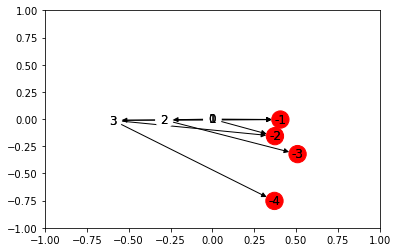

curcost 0.8400737357988088

33
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.42504077e-04 -1.91455522e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.06583614e-01 -4.20502720e-03 -9.99990003e+04 -1.01997976e+05]
 [ 3.74011470e-01 -1.56965897e-01 -9.99990003e+04 -1.01327331e+05]
 [-2.87113935e-01 -7.24192452e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.09178651e-01 -3.22194745e-01 -9.99987750e+04 -2.01322047e+05]
 [-5.92790379e-01 -1.14818432e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.71124836e-01 -7.52926969e-01 -9.99986756e+04 -3.01983472e+05]]


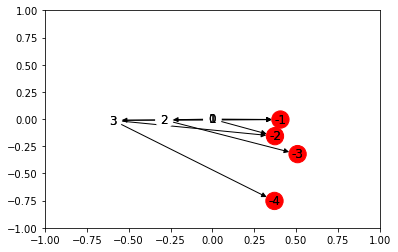

curcost 0.8399890909900128

34
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.42407075e-04 -1.91378939e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.06827564e-01 -4.20755022e-03 -9.99990003e+04 -1.02059175e+05]
 [ 3.74161075e-01 -1.57028683e-01 -9.99990003e+04 -1.01367862e+05]
 [-2.86999089e-01 -7.23902775e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.09280486e-01 -3.22259184e-01 -9.99987750e+04 -2.01362311e+05]
 [-5.92553263e-01 -1.14772505e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.71199061e-01 -7.53077554e-01 -9.99986756e+04 -3.02043869e+05]]


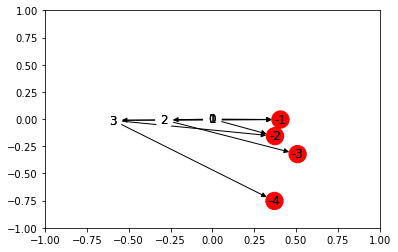

curcost 0.8399047362054692

35
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.42310113e-04 -1.91302388e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.07071660e-01 -4.21007475e-03 -9.99990003e+04 -1.02120411e+05]
 [ 3.74310739e-01 -1.57091495e-01 -9.99990003e+04 -1.01408409e+05]
 [-2.86884290e-01 -7.23613214e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.09382343e-01 -3.22323636e-01 -9.99987750e+04 -2.01402584e+05]
 [-5.92316241e-01 -1.14726596e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.71273301e-01 -7.53228170e-01 -9.99986756e+04 -3.02104278e+05]]


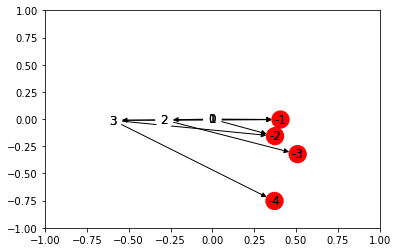

curcost 0.8398206716052153

36
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.42213189e-04 -1.91225867e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.07315903e-01 -4.21260080e-03 -9.99990003e+04 -1.02181683e+05]
 [ 3.74460464e-01 -1.57154332e-01 -9.99990003e+04 -1.01448972e+05]
 [-2.86769536e-01 -7.23323768e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.09484219e-01 -3.22388101e-01 -9.99987750e+04 -2.01442864e+05]
 [-5.92079315e-01 -1.14680705e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.71347556e-01 -7.53378815e-01 -9.99986756e+04 -3.02164699e+05]]


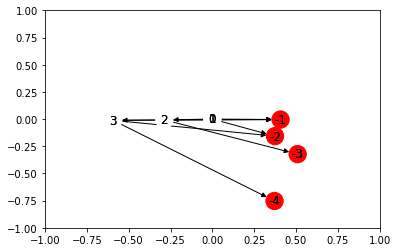

curcost 0.8397368973498062

37
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.42116303e-04 -1.91149376e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.07560293e-01 -4.21512836e-03 -9.99990003e+04 -1.02242992e+05]
 [ 3.74610248e-01 -1.57217193e-01 -9.99990003e+04 -1.01489552e+05]
 [-2.86654828e-01 -7.23034439e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.09586116e-01 -3.22452578e-01 -9.99987750e+04 -2.01483153e+05]
 [-5.91842483e-01 -1.14634833e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.71421825e-01 -7.53529491e-01 -9.99986756e+04 -3.02225131e+05]]


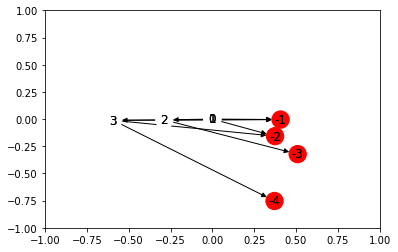

curcost 0.8396534136003135

38
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.42019457e-04 -1.91072917e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.07804829e-01 -4.21765743e-03 -9.99990003e+04 -1.02304338e+05]
 [ 3.74760092e-01 -1.57280080e-01 -9.99990003e+04 -1.01530148e+05]
 [-2.86540166e-01 -7.22745225e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.09688033e-01 -3.22517069e-01 -9.99987750e+04 -2.01523449e+05]
 [-5.91605746e-01 -1.14588979e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.71496110e-01 -7.53680197e-01 -9.99986756e+04 -3.02285576e+05]]


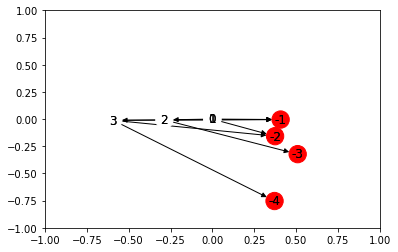

curcost 0.839570220518326

39
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.41922649e-04 -1.90996488e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.08049512e-01 -4.22018803e-03 -9.99990003e+04 -1.02365720e+05]
 [ 3.74909996e-01 -1.57342992e-01 -9.99990003e+04 -1.01570760e+05]
 [-2.86425550e-01 -7.22456127e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.09789971e-01 -3.22581572e-01 -9.99987750e+04 -2.01563754e+05]
 [-5.91369104e-01 -1.14543144e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.71570409e-01 -7.53830933e-01 -9.99986756e+04 -3.02346034e+05]]


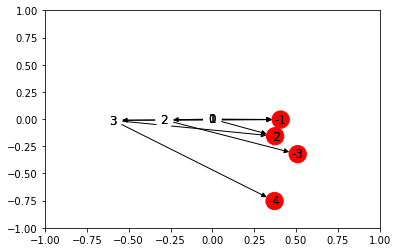

curcost 0.8394873182659477

40
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.41825880e-04 -1.90920089e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.08294342e-01 -4.22272014e-03 -9.99990003e+04 -1.02427140e+05]
 [ 3.75059960e-01 -1.57405929e-01 -9.99990003e+04 -1.01611388e+05]
 [-2.86310980e-01 -7.22167144e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.09891929e-01 -3.22646088e-01 -9.99987750e+04 -2.01604067e+05]
 [-5.91132556e-01 -1.14497326e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.71644723e-01 -7.53981699e-01 -9.99986756e+04 -3.02406503e+05]]


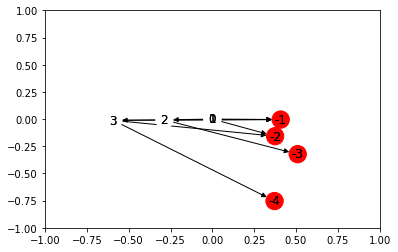

curcost 0.8394047070058004

41
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.41729150e-04 -1.90843721e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.08539318e-01 -4.22525377e-03 -9.99990003e+04 -1.02488596e+05]
 [ 3.75209984e-01 -1.57468892e-01 -9.99990003e+04 -1.01652033e+05]
 [-2.86196456e-01 -7.21878278e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.09993907e-01 -3.22710618e-01 -9.99987750e+04 -2.01644387e+05]
 [-5.90896103e-01 -1.14451527e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.71719052e-01 -7.54132495e-01 -9.99986756e+04 -3.02466984e+05]]


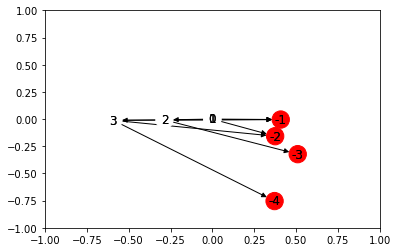

curcost 0.83932238690102

42
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.41632458e-04 -1.90767383e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.08784442e-01 -4.22778892e-03 -9.99990003e+04 -1.02550089e+05]
 [ 3.75360068e-01 -1.57531879e-01 -9.99990003e+04 -1.01692694e+05]
 [-2.86081977e-01 -7.21589526e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.10095906e-01 -3.22775160e-01 -9.99987750e+04 -2.01684716e+05]
 [-5.90659745e-01 -1.14405747e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.71793396e-01 -7.54283322e-01 -9.99986756e+04 -3.02527478e+05]]


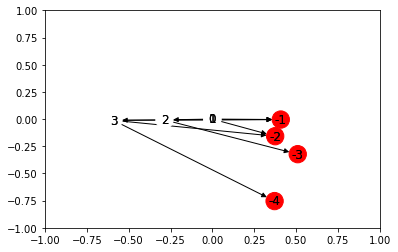

curcost 0.8392403581152598

43
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.41535805e-04 -1.90691077e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.09029713e-01 -4.23032560e-03 -9.99990003e+04 -1.02611619e+05]
 [ 3.75510212e-01 -1.57594892e-01 -9.99990003e+04 -1.01733371e+05]
 [-2.85967544e-01 -7.21300890e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.10197925e-01 -3.22839715e-01 -9.99987750e+04 -2.01725053e+05]
 [-5.90423481e-01 -1.14359984e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.71867754e-01 -7.54434179e-01 -9.99986756e+04 -3.02587983e+05]]


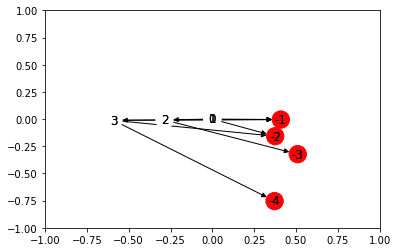

curcost 0.8391586208126874

44
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.41439191e-04 -1.90614800e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.09275130e-01 -4.23286379e-03 -9.99990003e+04 -1.02673186e+05]
 [ 3.75660416e-01 -1.57657930e-01 -9.99990003e+04 -1.01774064e+05]
 [-2.85853157e-01 -7.21012370e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.10299965e-01 -3.22904283e-01 -9.99987750e+04 -2.01765398e+05]
 [-5.90187312e-01 -1.14314240e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.71942128e-01 -7.54585065e-01 -9.99986756e+04 -3.02648501e+05]]


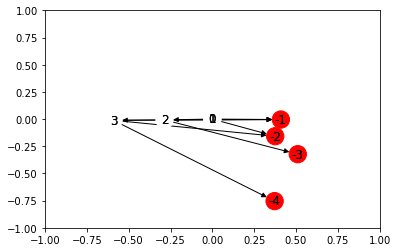

curcost 0.8390771751579861

45
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.41342615e-04 -1.90538554e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.09520695e-01 -4.23540351e-03 -9.99990003e+04 -1.02734790e+05]
 [ 3.75810680e-01 -1.57720993e-01 -9.99990003e+04 -1.01814774e+05]
 [-2.85738816e-01 -7.20723965e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.10402025e-01 -3.22968864e-01 -9.99987750e+04 -2.01805751e+05]
 [-5.89951237e-01 -1.14268515e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.72016516e-01 -7.54735982e-01 -9.99986756e+04 -3.02709030e+05]]


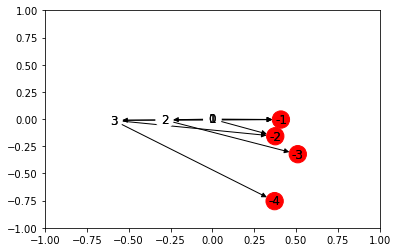

curcost 0.838996021316354

46
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.41246078e-04 -1.90462339e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.09766408e-01 -4.23794475e-03 -9.99990003e+04 -1.02796431e+05]
 [ 3.75961004e-01 -1.57784082e-01 -9.99990003e+04 -1.01855500e+05]
 [-2.85624520e-01 -7.20435676e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.10504105e-01 -3.23033457e-01 -9.99987750e+04 -2.01846113e+05]
 [-5.89715256e-01 -1.14222807e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.72090920e-01 -7.54886930e-01 -9.99986756e+04 -3.02769572e+05]]


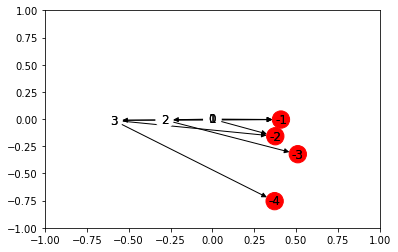

curcost 0.8389151594535047

47
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.41149579e-04 -1.90386154e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.10012268e-01 -4.24048752e-03 -9.99990003e+04 -1.02858109e+05]
 [ 3.76111389e-01 -1.57847195e-01 -9.99990003e+04 -1.01896242e+05]
 [-2.85510271e-01 -7.20147501e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.10606206e-01 -3.23098064e-01 -9.99987750e+04 -2.01886482e+05]
 [-5.89479370e-01 -1.14177118e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.72165338e-01 -7.55037907e-01 -9.99986756e+04 -3.02830126e+05]]


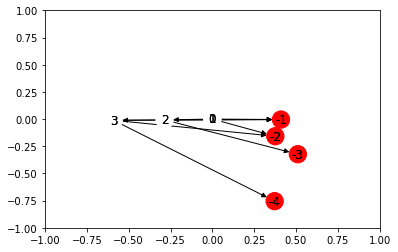

curcost 0.8388345897356657

48
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.41053120e-04 -1.90309999e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.10258275e-01 -4.24303181e-03 -9.99990003e+04 -1.02919824e+05]
 [ 3.76261833e-01 -1.57910334e-01 -9.99990003e+04 -1.01937000e+05]
 [-2.85396067e-01 -7.19859442e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.10708327e-01 -3.23162684e-01 -9.99987750e+04 -2.01926859e+05]
 [-5.89243578e-01 -1.14131447e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.72239771e-01 -7.55188915e-01 -9.99986756e+04 -3.02890692e+05]]


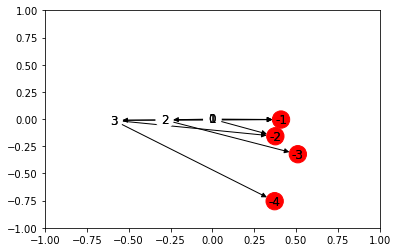

curcost 0.8387543123295791

49
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.40956698e-04 -1.90233875e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.10504430e-01 -4.24557763e-03 -9.99990003e+04 -1.02981576e+05]
 [ 3.76412338e-01 -1.57973498e-01 -9.99990003e+04 -1.01977775e+05]
 [-2.85281908e-01 -7.19571499e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.10810469e-01 -3.23227316e-01 -9.99987750e+04 -2.01967244e+05]
 [-5.89007881e-01 -1.14085795e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.72314219e-01 -7.55339952e-01 -9.99986756e+04 -3.02951270e+05]]


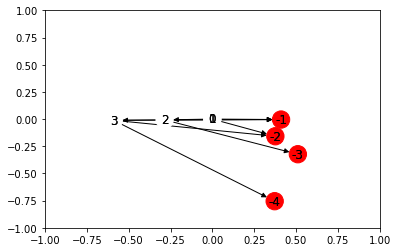

curcost 0.838674327402501

50
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.40860316e-04 -1.90157782e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.10750733e-01 -4.24812498e-03 -9.99990003e+04 -1.03043365e+05]
 [ 3.76562903e-01 -1.58036688e-01 -9.99990003e+04 -1.02018566e+05]
 [-2.85167795e-01 -7.19283670e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.10912631e-01 -3.23291962e-01 -9.99987750e+04 -2.02007638e+05]
 [-5.88772278e-01 -1.14040160e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.72388682e-01 -7.55491020e-01 -9.99986756e+04 -3.03011860e+05]]


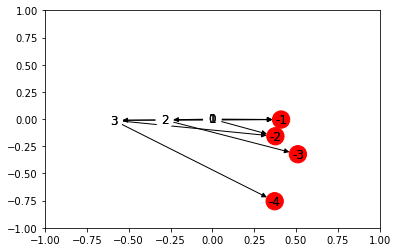

curcost 0.8385946351222027

51
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.40763972e-04 -1.90081719e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.10997183e-01 -4.25067385e-03 -9.99990003e+04 -1.03105191e+05]
 [ 3.76713528e-01 -1.58099902e-01 -9.99990003e+04 -1.02059374e+05]
 [-2.85053728e-01 -7.18995956e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.11014813e-01 -3.23356620e-01 -9.99987750e+04 -2.02048039e+05]
 [-5.88536769e-01 -1.13994544e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.72463159e-01 -7.55642119e-01 -9.99986756e+04 -3.03072463e+05]]


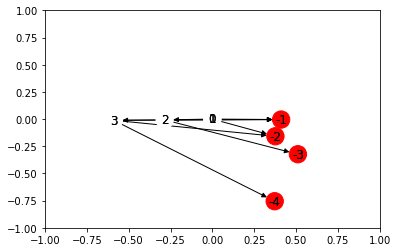

curcost 0.8385152356569667

52
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.40667666e-04 -1.90005686e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.11243781e-01 -4.25322426e-03 -9.99990003e+04 -1.03167054e+05]
 [ 3.76864214e-01 -1.58163142e-01 -9.99990003e+04 -1.02100197e+05]
 [-2.84939707e-01 -7.18708358e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.11117016e-01 -3.23421291e-01 -9.99987750e+04 -2.02088449e+05]
 [-5.88301354e-01 -1.13948947e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.72537652e-01 -7.55793247e-01 -9.99986756e+04 -3.03133077e+05]]


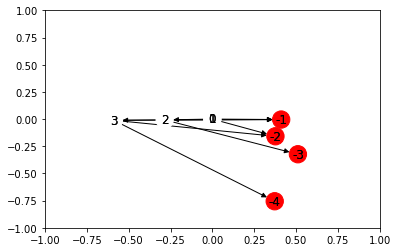

curcost 0.8384361291755918

53
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.40571399e-04 -1.89929684e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.11490528e-01 -4.25577619e-03 -9.99990003e+04 -1.03228954e+05]
 [ 3.77014959e-01 -1.58226408e-01 -9.99990003e+04 -1.02141037e+05]
 [-2.84825731e-01 -7.18420875e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.11219240e-01 -3.23485976e-01 -9.99987750e+04 -2.02128867e+05]
 [-5.88066034e-01 -1.13903367e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.72612160e-01 -7.55944406e-01 -9.99986756e+04 -3.03193704e+05]]


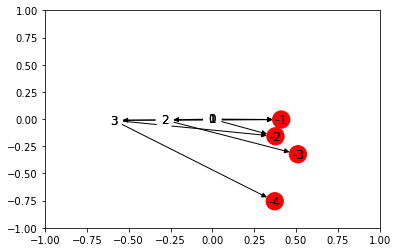

curcost 0.8383573158473883

54
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.40475170e-04 -1.89853712e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.11737422e-01 -4.25832966e-03 -9.99990003e+04 -1.03290891e+05]
 [ 3.77165765e-01 -1.58289698e-01 -9.99990003e+04 -1.02181894e+05]
 [-2.84711801e-01 -7.18133506e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.11321484e-01 -3.23550673e-01 -9.99987750e+04 -2.02169292e+05]
 [-5.87830807e-01 -1.13857806e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.72686682e-01 -7.56095595e-01 -9.99986756e+04 -3.03254343e+05]]


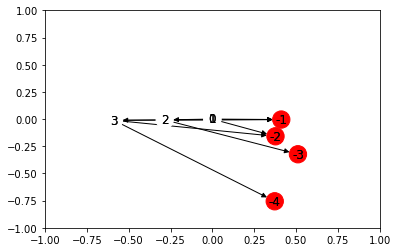

curcost 0.8382787958421805

55
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.40378980e-04 -1.89777770e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.11984464e-01 -4.26088466e-03 -9.99990003e+04 -1.03352866e+05]
 [ 3.77316632e-01 -1.58353014e-01 -9.99990003e+04 -1.02222767e+05]
 [-2.84597916e-01 -7.17846253e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.11423748e-01 -3.23615383e-01 -9.99987750e+04 -2.02209726e+05]
 [-5.87595675e-01 -1.13812263e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.72761219e-01 -7.56246814e-01 -9.99986756e+04 -3.03314994e+05]]


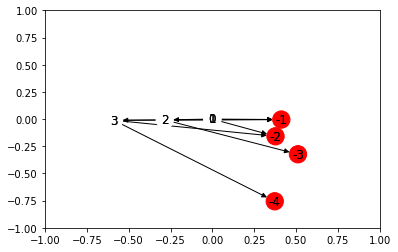

curcost 0.8382005693303052

56
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.40282829e-04 -1.89701859e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.12231655e-01 -4.26344119e-03 -9.99990003e+04 -1.03414878e+05]
 [ 3.77467558e-01 -1.58416355e-01 -9.99990003e+04 -1.02263656e+05]
 [-2.84484077e-01 -7.17559115e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.11526033e-01 -3.23680106e-01 -9.99987750e+04 -2.02250168e+05]
 [-5.87360637e-01 -1.13766738e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.72835772e-01 -7.56398063e-01 -9.99986756e+04 -3.03375657e+05]]


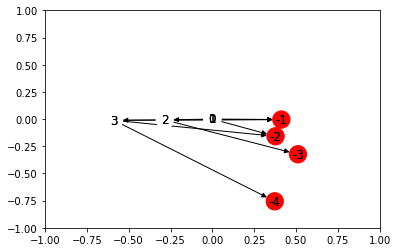

curcost 0.8381226364826122

57
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.40186716e-04 -1.89625979e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.12478994e-01 -4.26599925e-03 -9.99990003e+04 -1.03476927e+05]
 [ 3.77618545e-01 -1.58479722e-01 -9.99990003e+04 -1.02304561e+05]
 [-2.84370283e-01 -7.17272091e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.11628338e-01 -3.23744842e-01 -9.99987750e+04 -2.02290618e+05]
 [-5.87125692e-01 -1.13721231e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.72910339e-01 -7.56549343e-01 -9.99986756e+04 -3.03436332e+05]]


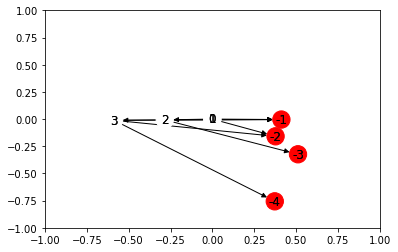

curcost 0.8380449974704635

58
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.40090641e-04 -1.89550128e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.12726482e-01 -4.26855885e-03 -9.99990003e+04 -1.03539013e+05]
 [ 3.77769593e-01 -1.58543114e-01 -9.99990003e+04 -1.02345483e+05]
 [-2.84256535e-01 -7.16985182e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.11730664e-01 -3.23809591e-01 -9.99987750e+04 -2.02331076e+05]
 [-5.86890842e-01 -1.13675742e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.72984921e-01 -7.56700653e-01 -9.99986756e+04 -3.03497019e+05]]


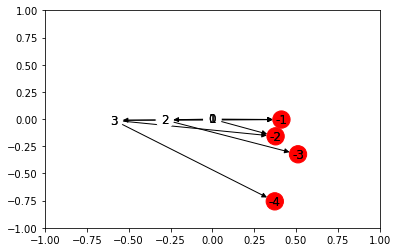

curcost 0.8379676524657338

59
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.39994605e-04 -1.89474308e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.12974117e-01 -4.27111999e-03 -9.99990003e+04 -1.03601136e+05]
 [ 3.77920701e-01 -1.58606531e-01 -9.99990003e+04 -1.02386421e+05]
 [-2.84142832e-01 -7.16698388e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.11833010e-01 -3.23874353e-01 -9.99987750e+04 -2.02371543e+05]
 [-5.86656086e-01 -1.13630272e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.73059518e-01 -7.56851993e-01 -9.99986756e+04 -3.03557718e+05]]


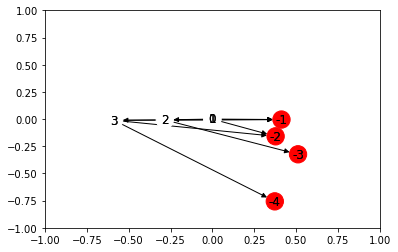

curcost 0.8378906016408096

60
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.39898607e-04 -1.89398518e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.13221902e-01 -4.27368266e-03 -9.99990003e+04 -1.03663297e+05]
 [ 3.78071869e-01 -1.58669973e-01 -9.99990003e+04 -1.02427376e+05]
 [-2.84029175e-01 -7.16411709e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.11935376e-01 -3.23939128e-01 -9.99987750e+04 -2.02412017e+05]
 [-5.86421423e-01 -1.13584820e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.73134130e-01 -7.57003363e-01 -9.99986756e+04 -3.03618430e+05]]


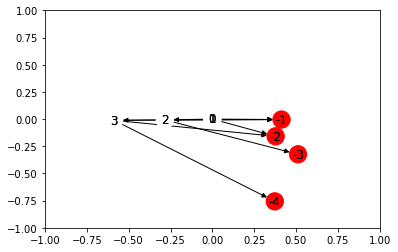

curcost 0.8378138451685896

61
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.39802647e-04 -1.89322759e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.13469835e-01 -4.27624687e-03 -9.99990003e+04 -1.03725495e+05]
 [ 3.78223098e-01 -1.58733441e-01 -9.99990003e+04 -1.02468347e+05]
 [-2.83915564e-01 -7.16125144e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.12037763e-01 -3.24003916e-01 -9.99987750e+04 -2.02452499e+05]
 [-5.86186855e-01 -1.13539386e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.73208757e-01 -7.57154764e-01 -9.99986756e+04 -3.03679154e+05]]


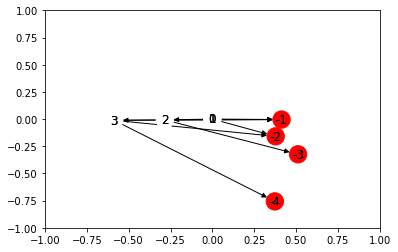

curcost 0.8377373832224841

62
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.39706726e-04 -1.89247030e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.13717917e-01 -4.27881262e-03 -9.99990003e+04 -1.03787730e+05]
 [ 3.78374387e-01 -1.58796935e-01 -9.99990003e+04 -1.02509334e+05]
 [-2.83801997e-01 -7.15838694e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.12140171e-01 -3.24068717e-01 -9.99987750e+04 -2.02492990e+05]
 [-5.85952380e-01 -1.13493970e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.73283398e-01 -7.57306195e-01 -9.99986756e+04 -3.03739889e+05]]


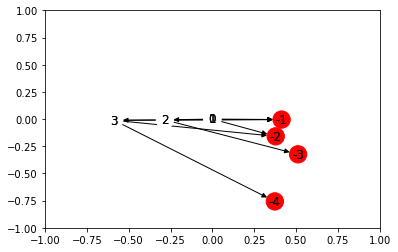

curcost 0.8376612159764149

63
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.39610844e-04 -1.89171331e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.13966148e-01 -4.28137990e-03 -9.99990003e+04 -1.03850003e+05]
 [ 3.78525737e-01 -1.58860454e-01 -9.99990003e+04 -1.02550338e+05]
 [-2.83688477e-01 -7.15552358e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.12242599e-01 -3.24133530e-01 -9.99987750e+04 -2.02533488e+05]
 [-5.85717999e-01 -1.13448573e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.73358055e-01 -7.57457656e-01 -9.99986756e+04 -3.03800637e+05]]


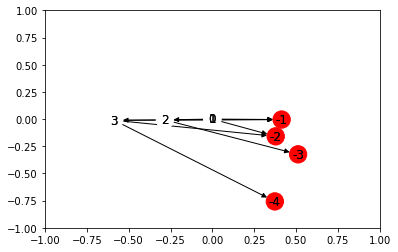

curcost 0.8375853436048152

64
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.39514999e-04 -1.89095662e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.14214527e-01 -4.28394873e-03 -9.99990003e+04 -1.03912313e+05]
 [ 3.78677147e-01 -1.58923998e-01 -9.99990003e+04 -1.02591358e+05]
 [-2.83575001e-01 -7.15266137e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.12345047e-01 -3.24198357e-01 -9.99987750e+04 -2.02573995e+05]
 [-5.85483712e-01 -1.13403193e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.73432727e-01 -7.57609147e-01 -9.99986756e+04 -3.03861397e+05]]


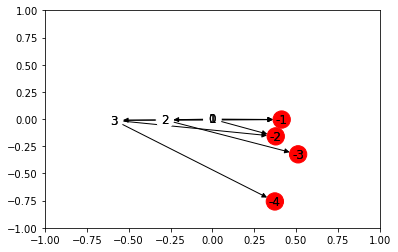

curcost 0.837509766282629

65
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.39419193e-04 -1.89020024e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.14463056e-01 -4.28651910e-03 -9.99990003e+04 -1.03974660e+05]
 [ 3.78828618e-01 -1.58987567e-01 -9.99990003e+04 -1.02632394e+05]
 [-2.83461571e-01 -7.14980031e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.12447516e-01 -3.24263197e-01 -9.99987750e+04 -2.02614510e+05]
 [-5.85249518e-01 -1.13357832e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.73507413e-01 -7.57760669e-01 -9.99986756e+04 -3.03922170e+05]]


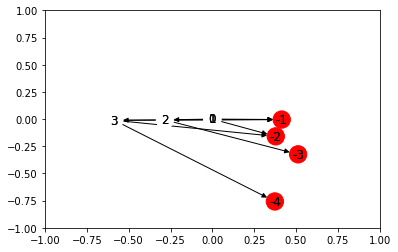

curcost 0.8374344841853121

66
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.39323426e-04 -1.88944416e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.14711734e-01 -4.28909101e-03 -9.99990003e+04 -1.04037045e+05]
 [ 3.78980149e-01 -1.59051162e-01 -9.99990003e+04 -1.02673447e+05]
 [-2.83348186e-01 -7.14694039e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.12550006e-01 -3.24328049e-01 -9.99987750e+04 -2.02655033e+05]
 [-5.85015418e-01 -1.13312489e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.73582115e-01 -7.57912221e-01 -9.99986756e+04 -3.03982954e+05]]


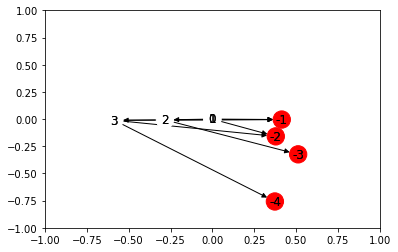

curcost 0.83735949748883

67
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.39227696e-04 -1.88868838e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.14960561e-01 -4.29166447e-03 -9.99990003e+04 -1.04099467e+05]
 [ 3.79131741e-01 -1.59114783e-01 -9.99990003e+04 -1.02714517e+05]
 [-2.83234847e-01 -7.14408161e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.12652516e-01 -3.24392915e-01 -9.99987750e+04 -2.02695564e+05]
 [-5.84781412e-01 -1.13267164e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.73656831e-01 -7.58063804e-01 -9.99986756e+04 -3.04043751e+05]]


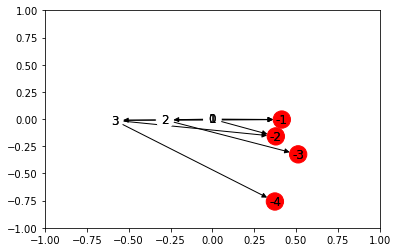

curcost 0.8372848063696596

68
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.39132005e-04 -1.88793291e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.15209537e-01 -4.29423947e-03 -9.99990003e+04 -1.04161927e+05]
 [ 3.79283394e-01 -1.59178429e-01 -9.99990003e+04 -1.02755603e+05]
 [-2.83121553e-01 -7.14122398e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.12755046e-01 -3.24457793e-01 -9.99987750e+04 -2.02736103e+05]
 [-5.84547500e-01 -1.13221857e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.73731562e-01 -7.58215417e-01 -9.99986756e+04 -3.04104560e+05]]


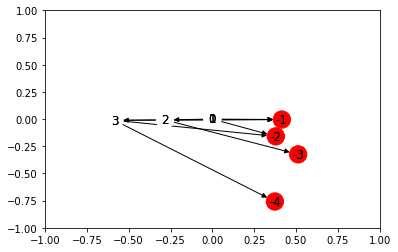

curcost 0.8372104110047883

69
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.39036352e-04 -1.88717774e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.15458663e-01 -4.29681601e-03 -9.99990003e+04 -1.04224424e+05]
 [ 3.79435107e-01 -1.59242100e-01 -9.99990003e+04 -1.02796705e+05]
 [-2.83008305e-01 -7.13836749e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.12857597e-01 -3.24522685e-01 -9.99987750e+04 -2.02776650e+05]
 [-5.84313681e-01 -1.13176568e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.73806309e-01 -7.58367060e-01 -9.99986756e+04 -3.04165380e+05]]


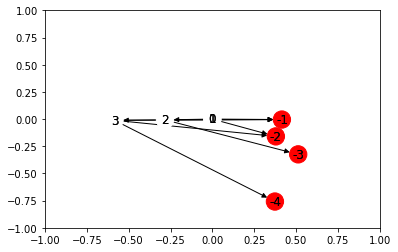

curcost 0.8371363115717124

70
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.38940738e-04 -1.88642286e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.15707938e-01 -4.29939410e-03 -9.99990003e+04 -1.04286959e+05]
 [ 3.79586881e-01 -1.59305797e-01 -9.99990003e+04 -1.02837824e+05]
 [-2.82895101e-01 -7.13551214e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.12960169e-01 -3.24587590e-01 -9.99987750e+04 -2.02817206e+05]
 [-5.84079955e-01 -1.13131298e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.73881070e-01 -7.58518733e-01 -9.99986756e+04 -3.04226214e+05]]


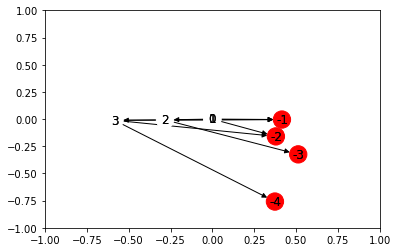

curcost 0.8370625082484401

71
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.38845161e-04 -1.88566830e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.15957363e-01 -4.30197374e-03 -9.99990003e+04 -1.04349531e+05]
 [ 3.79738716e-01 -1.59369519e-01 -9.99990003e+04 -1.02878959e+05]
 [-2.82781943e-01 -7.13265794e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.13062761e-01 -3.24652507e-01 -9.99987750e+04 -2.02857769e+05]
 [-5.83846323e-01 -1.13086045e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.73955846e-01 -7.58670437e-01 -9.99986756e+04 -3.04287059e+05]]


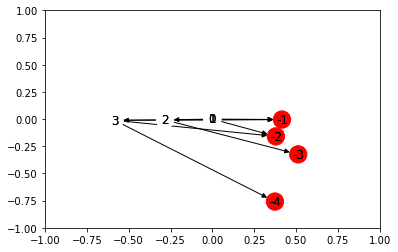

curcost 0.8369890012134883

72
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.38749623e-04 -1.88491403e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.16206937e-01 -4.30455492e-03 -9.99990003e+04 -1.04412140e+05]
 [ 3.79890612e-01 -1.59433267e-01 -9.99990003e+04 -1.02920110e+05]
 [-2.82668831e-01 -7.12980488e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.13165374e-01 -3.24717438e-01 -9.99987750e+04 -2.02898341e+05]
 [-5.83612785e-01 -1.13040811e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.74030637e-01 -7.58822171e-01 -9.99986756e+04 -3.04347916e+05]]


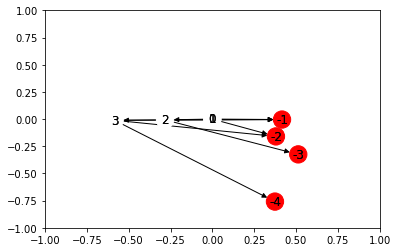

curcost 0.8369157906458836

73
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.38654124e-04 -1.88416006e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.16456662e-01 -4.30713765e-03 -9.99990003e+04 -1.04474788e+05]
 [ 3.80042568e-01 -1.59497040e-01 -9.99990003e+04 -1.02961278e+05]
 [-2.82555763e-01 -7.12695295e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.13268007e-01 -3.24782381e-01 -9.99987750e+04 -2.02938920e+05]
 [-5.83379340e-01 -1.12995594e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.74105443e-01 -7.58973935e-01 -9.99986756e+04 -3.04408786e+05]]


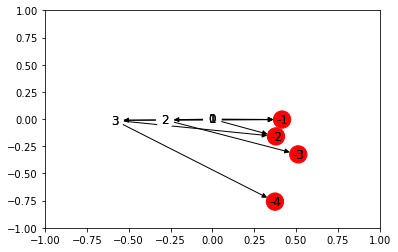

curcost 0.8368428767251627

74
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.38558662e-04 -1.88340640e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.16706536e-01 -4.30972194e-03 -9.99990003e+04 -1.04537473e+05]
 [ 3.80194585e-01 -1.59560839e-01 -9.99990003e+04 -1.03002463e+05]
 [-2.82442741e-01 -7.12410217e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.13370660e-01 -3.24847338e-01 -9.99987750e+04 -2.02979508e+05]
 [-5.83145988e-01 -1.12950396e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.74180265e-01 -7.59125730e-01 -9.99986756e+04 -3.04469668e+05]]


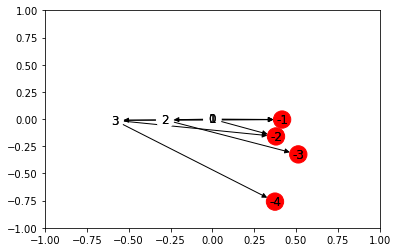

curcost 0.8367702596313713

75
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.38463238e-04 -1.88265304e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.16956559e-01 -4.31230777e-03 -9.99990003e+04 -1.04600195e+05]
 [ 3.80346663e-01 -1.59624664e-01 -9.99990003e+04 -1.03043664e+05]
 [-2.82329764e-01 -7.12125253e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.13473334e-01 -3.24912307e-01 -9.99987750e+04 -2.03020104e+05]
 [-5.82912730e-01 -1.12905216e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.74255101e-01 -7.59277555e-01 -9.99986756e+04 -3.04530561e+05]]


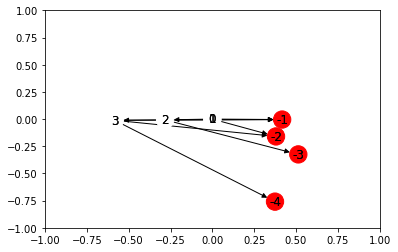

curcost 0.8366979395450638

76
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.38367853e-04 -1.88189997e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.17206733e-01 -4.31489515e-03 -9.99990003e+04 -1.04662955e+05]
 [ 3.80498801e-01 -1.59688513e-01 -9.99990003e+04 -1.03084881e+05]
 [-2.82216832e-01 -7.11840403e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.13576029e-01 -3.24977289e-01 -9.99987750e+04 -2.03060708e+05]
 [-5.82679564e-01 -1.12860054e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.74329952e-01 -7.59429411e-01 -9.99986756e+04 -3.04591468e+05]]


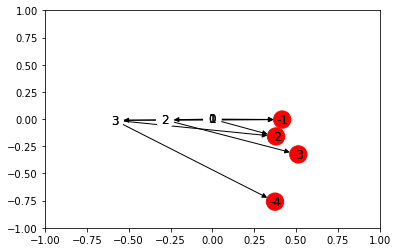

curcost 0.8366259166473046

77
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.38272506e-04 -1.88114721e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.17457057e-01 -4.31748409e-03 -9.99990003e+04 -1.04725753e+05]
 [ 3.80651001e-01 -1.59752389e-01 -9.99990003e+04 -1.03126115e+05]
 [-2.82103945e-01 -7.11555667e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.13678744e-01 -3.25042285e-01 -9.99987750e+04 -2.03101320e+05]
 [-5.82446493e-01 -1.12814910e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.74404818e-01 -7.59581297e-01 -9.99986756e+04 -3.04652386e+05]]


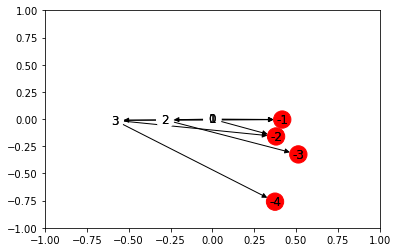

curcost 0.8365541911196663

78
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.38177197e-04 -1.88039476e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.17707532e-01 -4.32007458e-03 -9.99990003e+04 -1.04788588e+05]
 [ 3.80803261e-01 -1.59816290e-01 -9.99990003e+04 -1.03167366e+05]
 [-2.81991103e-01 -7.11271045e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.13781480e-01 -3.25107293e-01 -9.99987750e+04 -2.03141940e+05]
 [-5.82213514e-01 -1.12769784e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.74479699e-01 -7.59733213e-01 -9.99986756e+04 -3.04713316e+05]]


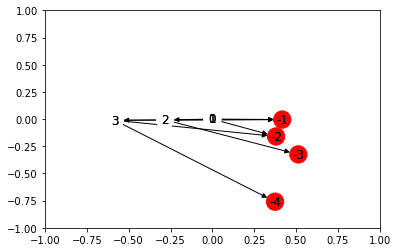

curcost 0.8364827631442301

79
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.38081926e-04 -1.87964260e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.17958156e-01 -4.32266663e-03 -9.99990003e+04 -1.04851462e+05]
 [ 3.80955583e-01 -1.59880216e-01 -9.99990003e+04 -1.03208633e+05]
 [-2.81878307e-01 -7.10986536e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.13884236e-01 -3.25172315e-01 -9.99987750e+04 -2.03182569e+05]
 [-5.81980629e-01 -1.12724676e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.74554595e-01 -7.59885160e-01 -9.99986756e+04 -3.04774259e+05]]


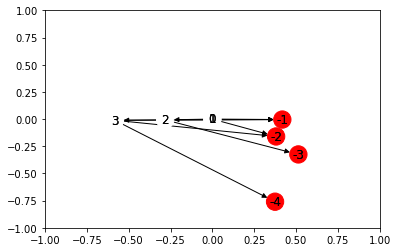

curcost 0.8364116329035861

80
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.37986693e-04 -1.87889074e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.18208931e-01 -4.32526023e-03 -9.99990003e+04 -1.04914373e+05]
 [ 3.81107965e-01 -1.59944168e-01 -9.99990003e+04 -1.03249916e+05]
 [-2.81765556e-01 -7.10702142e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.13987013e-01 -3.25237349e-01 -9.99987750e+04 -2.03223205e+05]
 [-5.81747836e-01 -1.12679586e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.74629505e-01 -7.60037137e-01 -9.99986756e+04 -3.04835214e+05]]


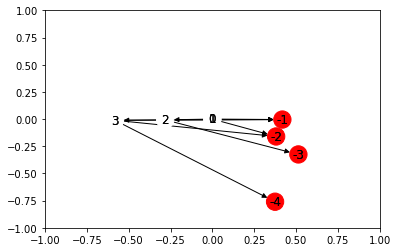

curcost 0.8363408005808323

81
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.37891499e-04 -1.87813918e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.18459856e-01 -4.32785538e-03 -9.99990003e+04 -1.04977321e+05]
 [ 3.81260408e-01 -1.60008146e-01 -9.99990003e+04 -1.03291216e+05]
 [-2.81652849e-01 -7.10417861e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.14089811e-01 -3.25302397e-01 -9.99987750e+04 -2.03263850e+05]
 [-5.81515137e-01 -1.12634514e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.74704431e-01 -7.60189144e-01 -9.99986756e+04 -3.04896181e+05]]


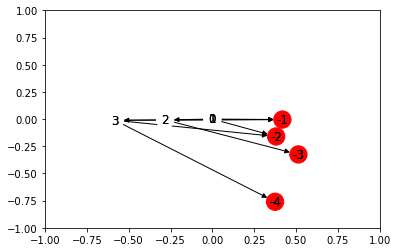

curcost 0.8362702663595751

82
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.37796342e-04 -1.87738793e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.18710932e-01 -4.33045209e-03 -9.99990003e+04 -1.05040308e+05]
 [ 3.81412912e-01 -1.60072149e-01 -9.99990003e+04 -1.03332532e+05]
 [-2.81540188e-01 -7.10133694e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.14192629e-01 -3.25367457e-01 -9.99987750e+04 -2.03304503e+05]
 [-5.81282531e-01 -1.12589461e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.74779372e-01 -7.60341182e-01 -9.99986756e+04 -3.04957160e+05]]


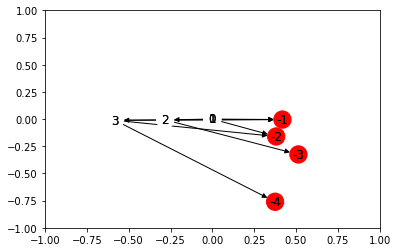

curcost 0.836200030423929

83
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.37701224e-04 -1.87663697e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.18962159e-01 -4.33305037e-03 -9.99990003e+04 -1.05103332e+05]
 [ 3.81565477e-01 -1.60136178e-01 -9.99990003e+04 -1.03373865e+05]
 [-2.81427572e-01 -7.09849640e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.14295467e-01 -3.25432531e-01 -9.99987750e+04 -2.03345164e+05]
 [-5.81050018e-01 -1.12544425e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.74854328e-01 -7.60493250e-01 -9.99986756e+04 -3.05018152e+05]]


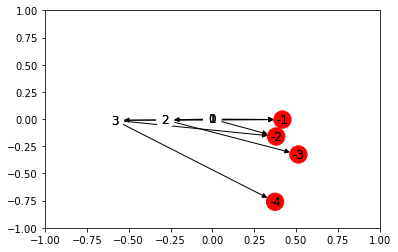

curcost 0.8361300929585161

84
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.37606143e-04 -1.87588632e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.19213536e-01 -4.33565020e-03 -9.99990003e+04 -1.05166394e+05]
 [ 3.81718103e-01 -1.60200233e-01 -9.99990003e+04 -1.03415215e+05]
 [-2.81315001e-01 -7.09565700e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.14398326e-01 -3.25497617e-01 -9.99987750e+04 -2.03385833e+05]
 [-5.80817598e-01 -1.12499407e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.74929299e-01 -7.60645349e-01 -9.99986756e+04 -3.05079155e+05]]


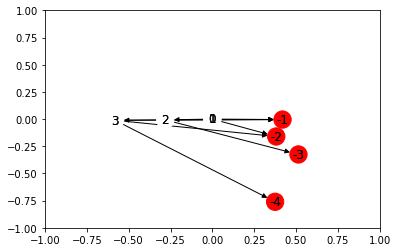

curcost 0.8360604541484667

85
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.37511101e-04 -1.87513596e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.19465064e-01 -4.33825159e-03 -9.99990003e+04 -1.05229494e+05]
 [ 3.81870791e-01 -1.60264313e-01 -9.99990003e+04 -1.03456581e+05]
 [-2.81202475e-01 -7.09281874e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.14501206e-01 -3.25562717e-01 -9.99987750e+04 -2.03426510e+05]
 [-5.80585271e-01 -1.12454407e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.75004285e-01 -7.60797478e-01 -9.99986756e+04 -3.05140171e+05]]


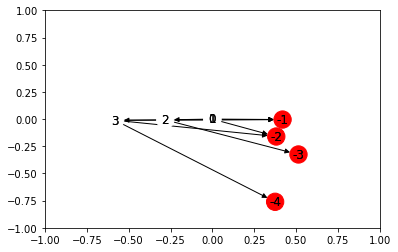

curcost 0.8359911141794182

86
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.37416096e-04 -1.87438591e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.19716743e-01 -4.34085454e-03 -9.99990003e+04 -1.05292631e+05]
 [ 3.82023539e-01 -1.60328418e-01 -9.99990003e+04 -1.03497964e+05]
 [-2.81089994e-01 -7.08998161e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.14604106e-01 -3.25627829e-01 -9.99987750e+04 -2.03467195e+05]
 [-5.80353037e-01 -1.12409425e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.75079286e-01 -7.60949637e-01 -9.99986756e+04 -3.05201199e+05]]


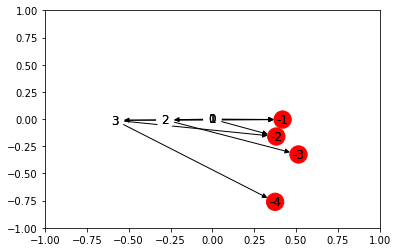

curcost 0.8359220732375157

87
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.37321130e-04 -1.87363616e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.19968573e-01 -4.34345905e-03 -9.99990003e+04 -1.05355807e+05]
 [ 3.82176348e-01 -1.60392550e-01 -9.99990003e+04 -1.03539363e+05]
 [-2.80977558e-01 -7.08714562e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.14707027e-01 -3.25692955e-01 -9.99987750e+04 -2.03507888e+05]
 [-5.80120896e-01 -1.12364462e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.75154302e-01 -7.61101827e-01 -9.99986756e+04 -3.05262239e+05]]


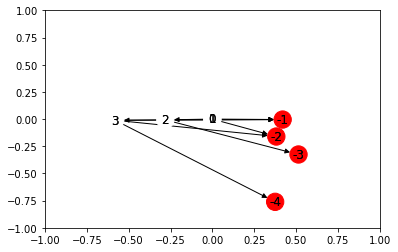

curcost 0.835853331509411

88
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.37226201e-04 -1.87288670e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.20220555e-01 -4.34606513e-03 -9.99990003e+04 -1.05419020e+05]
 [ 3.82329219e-01 -1.60456707e-01 -9.99990003e+04 -1.03580779e+05]
 [-2.80865167e-01 -7.08431076e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.14809968e-01 -3.25758093e-01 -9.99987750e+04 -2.03548590e+05]
 [-5.79888847e-01 -1.12319516e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.75229332e-01 -7.61254048e-01 -9.99986756e+04 -3.05323292e+05]]


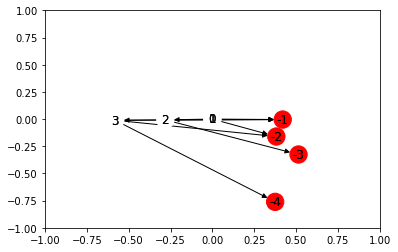

curcost 0.8357848891822636

89
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.37131311e-04 -1.87213755e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.20472687e-01 -4.34867276e-03 -9.99990003e+04 -1.05482272e+05]
 [ 3.82482151e-01 -1.60520890e-01 -9.99990003e+04 -1.03622211e+05]
 [-2.80752821e-01 -7.08147704e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.14912930e-01 -3.25823245e-01 -9.99987750e+04 -2.03589300e+05]
 [-5.79656892e-01 -1.12274588e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.75304378e-01 -7.61406298e-01 -9.99986756e+04 -3.05384356e+05]]


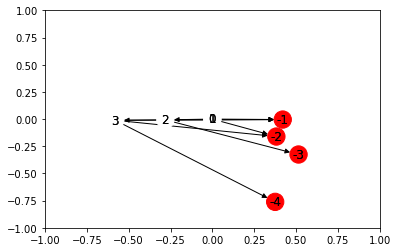

curcost 0.8357167464437403

90
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.37036458e-04 -1.87138869e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.20724971e-01 -4.35128197e-03 -9.99990003e+04 -1.05545561e+05]
 [ 3.82635144e-01 -1.60585098e-01 -9.99990003e+04 -1.03663660e+05]
 [-2.80640520e-01 -7.07864445e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.15015913e-01 -3.25888410e-01 -9.99987750e+04 -2.03630018e+05]
 [-5.79425029e-01 -1.12229678e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.75379439e-01 -7.61558580e-01 -9.99986756e+04 -3.05445433e+05]]


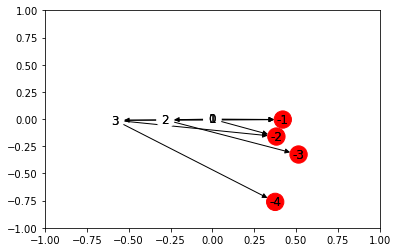

curcost 0.8356489034820135

91
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.36941644e-04 -1.87064014e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.20977405e-01 -4.35389274e-03 -9.99990003e+04 -1.05608888e+05]
 [ 3.82788198e-01 -1.60649332e-01 -9.99990003e+04 -1.03705125e+05]
 [-2.80528264e-01 -7.07581299e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.15118916e-01 -3.25953587e-01 -9.99987750e+04 -2.03670744e+05]
 [-5.79193259e-01 -1.12184786e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.75454515e-01 -7.61710891e-01 -9.99986756e+04 -3.05506522e+05]]


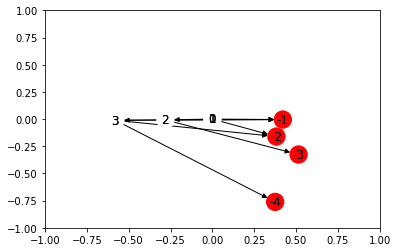

curcost 0.8355813604857635

92
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.36846867e-04 -1.86989188e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.21229992e-01 -4.35650507e-03 -9.99990003e+04 -1.05672254e+05]
 [ 3.82941313e-01 -1.60713592e-01 -9.99990003e+04 -1.03746607e+05]
 [-2.80416052e-01 -7.07298266e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.15221940e-01 -3.26018778e-01 -9.99987750e+04 -2.03711478e+05]
 [-5.78961582e-01 -1.12139912e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.75529606e-01 -7.61863234e-01 -9.99986756e+04 -3.05567624e+05]]


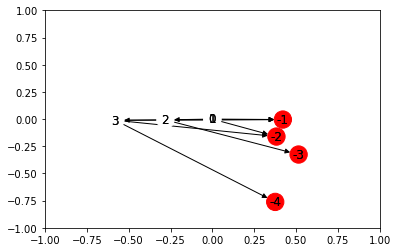

curcost 0.8355141176441763

93
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.36752128e-04 -1.86914392e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.21482730e-01 -4.35911898e-03 -9.99990003e+04 -1.05735657e+05]
 [ 3.83094489e-01 -1.60777877e-01 -9.99990003e+04 -1.03788106e+05]
 [-2.80303886e-01 -7.07015347e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.15324984e-01 -3.26083982e-01 -9.99987750e+04 -2.03752220e+05]
 [-5.78729997e-01 -1.12095056e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.75604712e-01 -7.62015606e-01 -9.99986756e+04 -3.05628737e+05]]


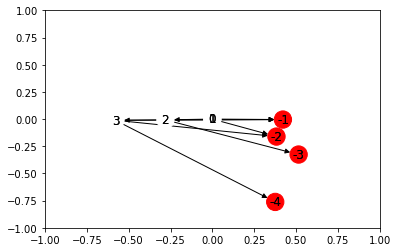

curcost 0.835447175146945

94
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.36657427e-04 -1.86839627e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.21735620e-01 -4.36173445e-03 -9.99990003e+04 -1.05799098e+05]
 [ 3.83247727e-01 -1.60842188e-01 -9.99990003e+04 -1.03829621e+05]
 [-2.80191764e-01 -7.06732541e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.15428049e-01 -3.26149199e-01 -9.99987750e+04 -2.03792971e+05]
 [-5.78498505e-01 -1.12050218e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.75679833e-01 -7.62168009e-01 -9.99986756e+04 -3.05689863e+05]]


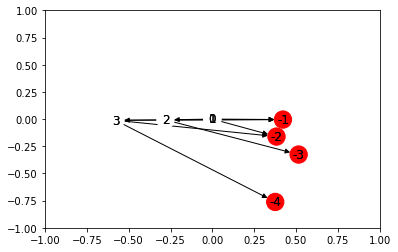

curcost 0.8353805331842686

95
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.36562764e-04 -1.86764891e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.21988661e-01 -4.36435149e-03 -9.99990003e+04 -1.05862578e+05]
 [ 3.83401026e-01 -1.60906525e-01 -9.99990003e+04 -1.03871153e+05]
 [-2.80079688e-01 -7.06449848e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.15531135e-01 -3.26214429e-01 -9.99987750e+04 -2.03833729e+05]
 [-5.78267106e-01 -1.12005398e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.75754969e-01 -7.62320443e-01 -9.99986756e+04 -3.05751001e+05]]


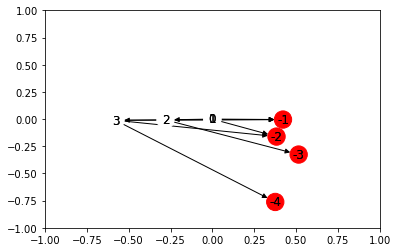

curcost 0.8353141919468522

96
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.36468139e-04 -1.86690185e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.22241854e-01 -4.36697010e-03 -9.99990003e+04 -1.05926096e+05]
 [ 3.83554387e-01 -1.60970888e-01 -9.99990003e+04 -1.03912702e+05]
 [-2.79967656e-01 -7.06167268e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.15634241e-01 -3.26279671e-01 -9.99987750e+04 -2.03874496e+05]
 [-5.78035799e-01 -1.11960596e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.75830120e-01 -7.62472907e-01 -9.99986756e+04 -3.05812151e+05]]


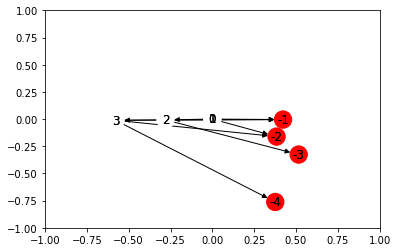

curcost 0.8352481516259074

97
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.36373552e-04 -1.86615509e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.22495199e-01 -4.36959028e-03 -9.99990003e+04 -1.05989651e+05]
 [ 3.83707808e-01 -1.61035276e-01 -9.99990003e+04 -1.03954267e+05]
 [-2.79855669e-01 -7.05884801e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.15737368e-01 -3.26344927e-01 -9.99987750e+04 -2.03915271e+05]
 [-5.77804585e-01 -1.11915812e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.75905286e-01 -7.62625402e-01 -9.99986756e+04 -3.05873314e+05]]


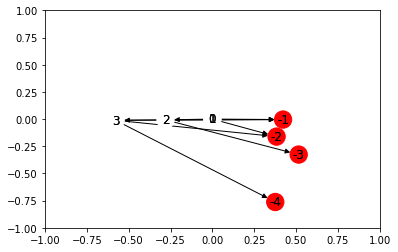

curcost 0.8351824124131512

98
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.36279003e-04 -1.86540863e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.22748696e-01 -4.37221204e-03 -9.99990003e+04 -1.06053245e+05]
 [ 3.83861292e-01 -1.61099690e-01 -9.99990003e+04 -1.03995848e+05]
 [-2.79743727e-01 -7.05602447e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.15840515e-01 -3.26410196e-01 -9.99987750e+04 -2.03956054e+05]
 [-5.77573463e-01 -1.11871046e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.75980467e-01 -7.62777927e-01 -9.99986756e+04 -3.05934488e+05]]


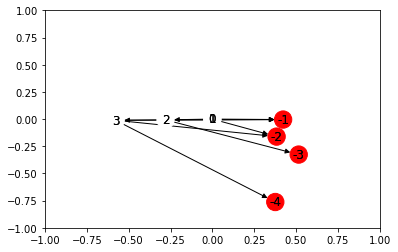

curcost 0.8351169745008059

99
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.36184491e-04 -1.86466246e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.23002346e-01 -4.37483536e-03 -9.99990003e+04 -1.06116877e+05]
 [ 3.84014836e-01 -1.61164130e-01 -9.99990003e+04 -1.04037447e+05]
 [-2.79631829e-01 -7.05320206e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.15943683e-01 -3.26475478e-01 -9.99987750e+04 -2.03996845e+05]
 [-5.77342433e-01 -1.11826297e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.76055663e-01 -7.62930482e-01 -9.99986756e+04 -3.05995675e+05]]


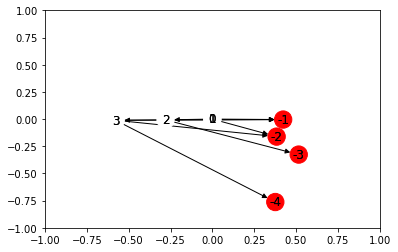

curcost 0.8350518380816008

100
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.36090017e-04 -1.86391660e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.23256147e-01 -4.37746026e-03 -9.99990003e+04 -1.06180547e+05]
 [ 3.84168442e-01 -1.61228596e-01 -9.99990003e+04 -1.04079062e+05]
 [-2.79519976e-01 -7.05038078e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.16046872e-01 -3.26540773e-01 -9.99987750e+04 -2.04037644e+05]
 [-5.77111496e-01 -1.11781567e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.76130874e-01 -7.63083068e-01 -9.99986756e+04 -3.06056874e+05]]


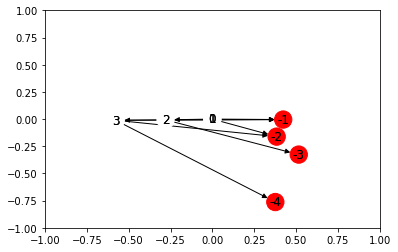

curcost 0.8349870033487696

101
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.35995581e-04 -1.86317103e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.23510101e-01 -4.38008674e-03 -9.99990003e+04 -1.06244255e+05]
 [ 3.84322109e-01 -1.61293087e-01 -9.99990003e+04 -1.04120693e+05]
 [-2.79408168e-01 -7.04756063e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.16150082e-01 -3.26606082e-01 -9.99987750e+04 -2.04078452e+05]
 [-5.76880652e-01 -1.11736854e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.76206100e-01 -7.63235685e-01 -9.99986756e+04 -3.06118086e+05]]


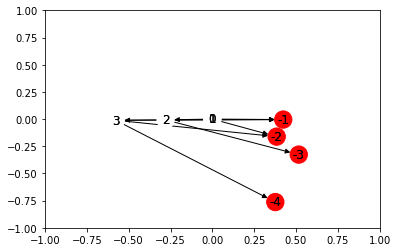

curcost 0.8349224704960521

102
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.35901183e-04 -1.86242576e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.23764207e-01 -4.38271479e-03 -9.99990003e+04 -1.06308002e+05]
 [ 3.84475838e-01 -1.61357604e-01 -9.99990003e+04 -1.04162342e+05]
 [-2.79296405e-01 -7.04474160e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.16253312e-01 -3.26671403e-01 -9.99987750e+04 -2.04119268e+05]
 [-5.76649900e-01 -1.11692159e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.76281341e-01 -7.63388332e-01 -9.99986756e+04 -3.06179309e+05]]


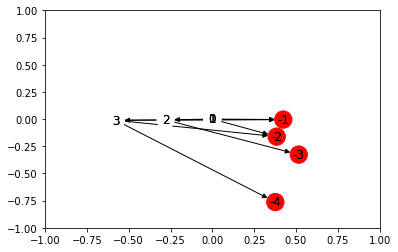

curcost 0.8348582397176929

103
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.35806823e-04 -1.86168079e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.24018465e-01 -4.38534442e-03 -9.99990003e+04 -1.06371787e+05]
 [ 3.84629629e-01 -1.61422147e-01 -9.99990003e+04 -1.04204007e+05]
 [-2.79184686e-01 -7.04192371e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.16356562e-01 -3.26736737e-01 -9.99987750e+04 -2.04160091e+05]
 [-5.76419240e-01 -1.11647482e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.76356598e-01 -7.63541010e-01 -9.99986756e+04 -3.06240545e+05]]


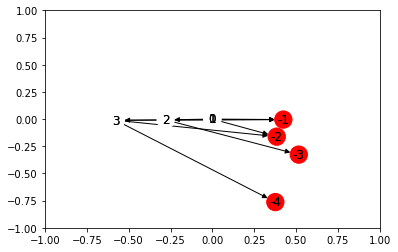

curcost 0.8347943112084418

104
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.35712500e-04 -1.86093612e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.24272876e-01 -4.38797563e-03 -9.99990003e+04 -1.06435610e+05]
 [ 3.84783480e-01 -1.61486716e-01 -9.99990003e+04 -1.04245688e+05]
 [-2.79073013e-01 -7.03910694e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.16459834e-01 -3.26802084e-01 -9.99987750e+04 -2.04200923e+05]
 [-5.76188672e-01 -1.11602823e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.76431869e-01 -7.63693718e-01 -9.99986756e+04 -3.06301793e+05]]


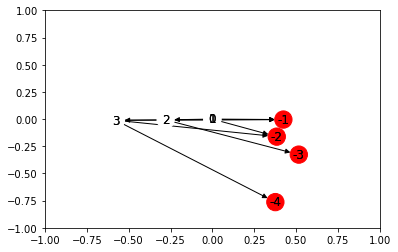

curcost 0.8347306851635541

105
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.35618215e-04 -1.86019174e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.24527440e-01 -4.39060841e-03 -9.99990003e+04 -1.06499471e+05]
 [ 3.84937394e-01 -1.61551311e-01 -9.99990003e+04 -1.04287386e+05]
 [-2.78961383e-01 -7.03629130e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.16563126e-01 -3.26867445e-01 -9.99987750e+04 -2.04241764e+05]
 [-5.75958196e-01 -1.11558182e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.76507155e-01 -7.63846457e-01 -9.99986756e+04 -3.06363054e+05]]


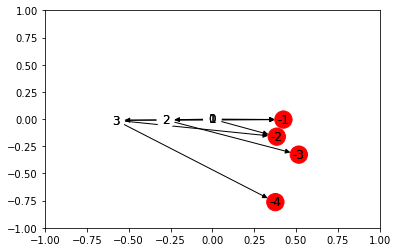

curcost 0.8346673617787895

106
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.35523968e-04 -1.85944767e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.24782157e-01 -4.39324278e-03 -9.99990003e+04 -1.06563371e+05]
 [ 3.85091369e-01 -1.61615932e-01 -9.99990003e+04 -1.04329101e+05]
 [-2.78849799e-01 -7.03347678e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.16666438e-01 -3.26932818e-01 -9.99987750e+04 -2.04282612e+05]
 [-5.75727813e-01 -1.11513559e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.76582457e-01 -7.63999226e-01 -9.99986756e+04 -3.06424326e+05]]


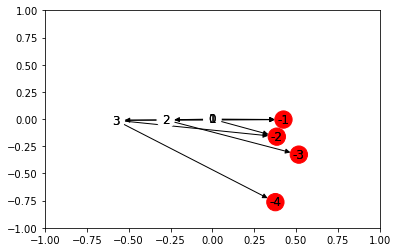

curcost 0.8346043412504132

107
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.35429758e-04 -1.85870389e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.25037026e-01 -4.39587872e-03 -9.99990003e+04 -1.06627309e+05]
 [ 3.85245405e-01 -1.61680578e-01 -9.99990003e+04 -1.04370833e+05]
 [-2.78738259e-01 -7.03066339e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.16769771e-01 -3.26998205e-01 -9.99987750e+04 -2.04323469e+05]
 [-5.75497522e-01 -1.11468954e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.76657773e-01 -7.64152026e-01 -9.99986756e+04 -3.06485611e+05]]


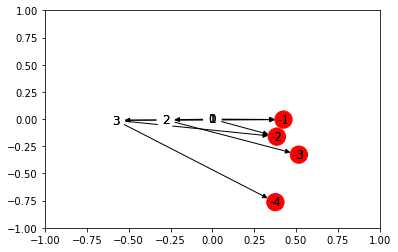

curcost 0.8345416237751944

108
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.35335586e-04 -1.85796041e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.25292048e-01 -4.39851625e-03 -9.99990003e+04 -1.06691285e+05]
 [ 3.85399503e-01 -1.61745250e-01 -9.99990003e+04 -1.04412581e+05]
 [-2.78626764e-01 -7.02785112e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.16873125e-01 -3.27063605e-01 -9.99987750e+04 -2.04364333e+05]
 [-5.75267323e-01 -1.11424366e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.76733105e-01 -7.64304856e-01 -9.99986756e+04 -3.06546908e+05]]


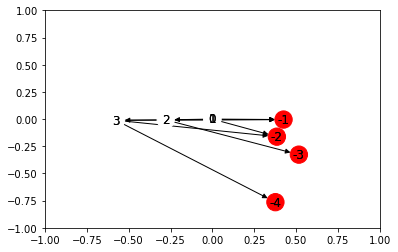

curcost 0.8344792095504077

109
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.35241452e-04 -1.85721722e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.25547223e-01 -4.40115536e-03 -9.99990003e+04 -1.06755300e+05]
 [ 3.85553663e-01 -1.61809948e-01 -9.99990003e+04 -1.04454346e+05]
 [-2.78515313e-01 -7.02503998e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.16976500e-01 -3.27129017e-01 -9.99987750e+04 -2.04405206e+05]
 [-5.75037216e-01 -1.11379796e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.76808452e-01 -7.64457717e-01 -9.99986756e+04 -3.06608218e+05]]


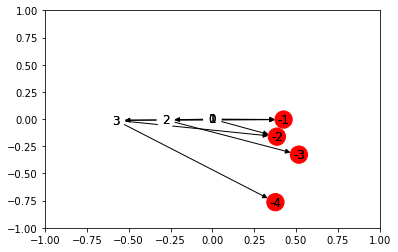

curcost 0.8344170987738316

110
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.35147355e-04 -1.85647434e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.25802552e-01 -4.40379605e-03 -9.99990003e+04 -1.06819353e+05]
 [ 3.85707885e-01 -1.61874672e-01 -9.99990003e+04 -1.04496128e+05]
 [-2.78403907e-01 -7.02222997e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.17079895e-01 -3.27194443e-01 -9.99987750e+04 -2.04446087e+05]
 [-5.74807201e-01 -1.11335244e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.76883813e-01 -7.64610609e-01 -9.99986756e+04 -3.06669539e+05]]


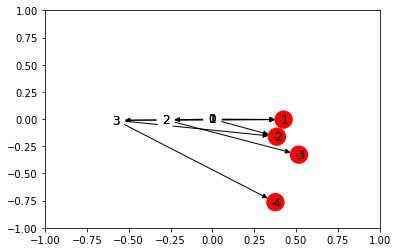

curcost 0.8343552916437494

111
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.35053296e-04 -1.85573175e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.26058033e-01 -4.40643833e-03 -9.99990003e+04 -1.06883445e+05]
 [ 3.85862168e-01 -1.61939422e-01 -9.99990003e+04 -1.04537927e+05]
 [-2.78292545e-01 -7.01942107e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.17183311e-01 -3.27259882e-01 -9.99987750e+04 -2.04486976e+05]
 [-5.74577278e-01 -1.11290710e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.76959190e-01 -7.64763531e-01 -9.99986756e+04 -3.06730873e+05]]


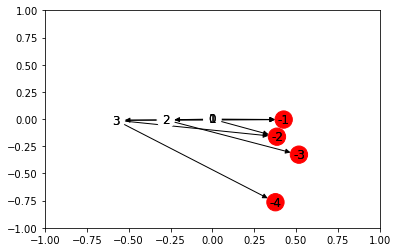

curcost 0.8342937883589489

112
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.34959275e-04 -1.85498945e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.26313668e-01 -4.40908219e-03 -9.99990003e+04 -1.06947575e+05]
 [ 3.86016513e-01 -1.62004198e-01 -9.99990003e+04 -1.04579742e+05]
 [-2.78181228e-01 -7.01661331e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.17286748e-01 -3.27325334e-01 -9.99987750e+04 -2.04527874e+05]
 [-5.74347447e-01 -1.11246194e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.77034582e-01 -7.64916484e-01 -9.99986756e+04 -3.06792219e+05]]


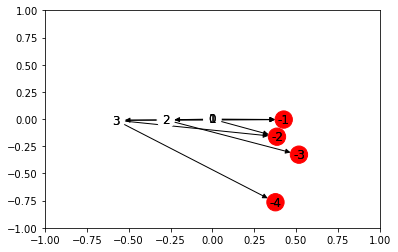

curcost 0.8342325891187217

113
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.34865291e-04 -1.85424746e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.26569456e-01 -4.41172764e-03 -9.99990003e+04 -1.07011743e+05]
 [ 3.86170919e-01 -1.62069000e-01 -9.99990003e+04 -1.04621574e+05]
 [-2.78069956e-01 -7.01380666e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.17390205e-01 -3.27390799e-01 -9.99987750e+04 -2.04568779e+05]
 [-5.74117708e-01 -1.11201696e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.77109989e-01 -7.65069467e-01 -9.99986756e+04 -3.06853578e+05]]


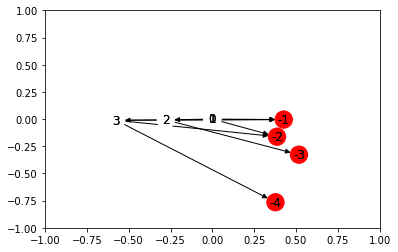

curcost 0.8341716941228636

114
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.34771345e-04 -1.85350576e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.26825398e-01 -4.41437468e-03 -9.99990003e+04 -1.07075950e+05]
 [ 3.86325388e-01 -1.62133827e-01 -9.99990003e+04 -1.04663422e+05]
 [-2.77958728e-01 -7.01100114e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.17493683e-01 -3.27456277e-01 -9.99987750e+04 -2.04609693e+05]
 [-5.73888061e-01 -1.11157215e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.77185411e-01 -7.65222481e-01 -9.99986756e+04 -3.06914948e+05]]


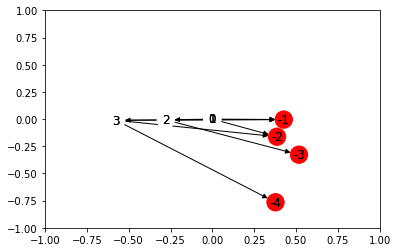

curcost 0.834111103571675

115
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.34677437e-04 -1.85276436e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.27081493e-01 -4.41702330e-03 -9.99990003e+04 -1.07140196e+05]
 [ 3.86479918e-01 -1.62198681e-01 -9.99990003e+04 -1.04705288e+05]
 [-2.77847544e-01 -7.00819674e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.17597182e-01 -3.27521768e-01 -9.99987750e+04 -2.04650615e+05]
 [-5.73658506e-01 -1.11112752e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.77260848e-01 -7.65375525e-01 -9.99986756e+04 -3.06976331e+05]]


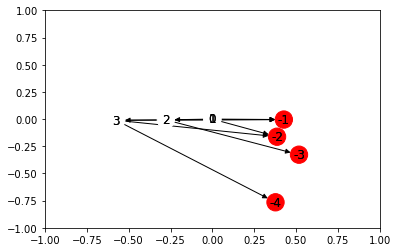

curcost 0.8340508176659599

116
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.34583566e-04 -1.85202325e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.27337742e-01 -4.41967352e-03 -9.99990003e+04 -1.07204480e+05]
 [ 3.86634510e-01 -1.62263560e-01 -9.99990003e+04 -1.04747170e+05]
 [-2.77736405e-01 -7.00539346e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.17700702e-01 -3.27587273e-01 -9.99987750e+04 -2.04691545e+05]
 [-5.73429043e-01 -1.11068307e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.77336300e-01 -7.65528600e-01 -9.99986756e+04 -3.07037727e+05]]


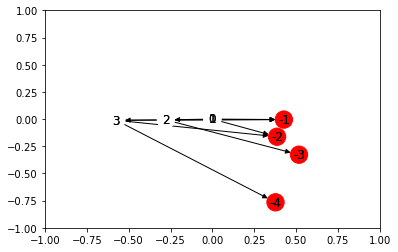

curcost 0.8339908366070266

117
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.34489732e-04 -1.85128244e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.27594145e-01 -4.42232532e-03 -9.99990003e+04 -1.07268803e+05]
 [ 3.86789164e-01 -1.62328466e-01 -9.99990003e+04 -1.04789069e+05]
 [-2.77625311e-01 -7.00259130e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.17804242e-01 -3.27652790e-01 -9.99987750e+04 -2.04732483e+05]
 [-5.73199671e-01 -1.11023880e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.77411767e-01 -7.65681706e-01 -9.99986756e+04 -3.07099134e+05]]


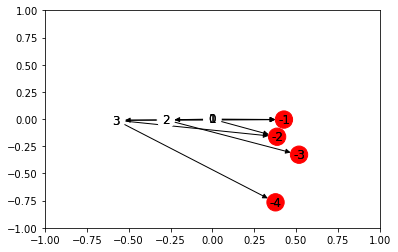

curcost 0.8339311605966866

118
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.34395936e-04 -1.85054193e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.27850701e-01 -4.42497872e-03 -9.99990003e+04 -1.07333164e+05]
 [ 3.86943879e-01 -1.62393397e-01 -9.99990003e+04 -1.04830984e+05]
 [-2.77514261e-01 -6.99979027e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.17907803e-01 -3.27718321e-01 -9.99987750e+04 -2.04773430e+05]
 [-5.72970391e-01 -1.10979470e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.77487250e-01 -7.65834842e-01 -9.99986756e+04 -3.07160554e+05]]


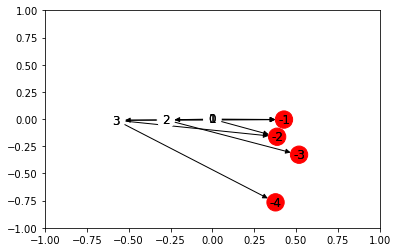

curcost 0.8338717898372555

119
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.34302178e-04 -1.84980171e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.28107412e-01 -4.42763371e-03 -9.99990003e+04 -1.07397564e+05]
 [ 3.87098657e-01 -1.62458354e-01 -9.99990003e+04 -1.04872917e+05]
 [-2.77403255e-01 -6.99699035e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.18011384e-01 -3.27783864e-01 -9.99987750e+04 -2.04814385e+05]
 [-5.72741203e-01 -1.10935078e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.77562747e-01 -7.65988009e-01 -9.99986756e+04 -3.07221986e+05]]


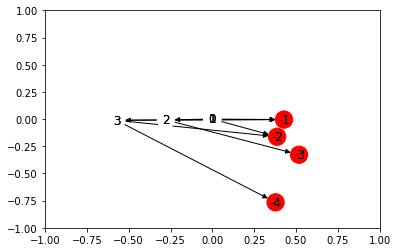

curcost 0.8338127245315529

120
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.34208457e-04 -1.84906179e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.28364276e-01 -4.43029029e-03 -9.99990003e+04 -1.07462003e+05]
 [ 3.87253496e-01 -1.62523338e-01 -9.99990003e+04 -1.04914866e+05]
 [-2.77292294e-01 -6.99419155e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.18114986e-01 -3.27849421e-01 -9.99987750e+04 -2.04855348e+05]
 [-5.72512107e-01 -1.10890704e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.77638260e-01 -7.66141207e-01 -9.99986756e+04 -3.07283431e+05]]


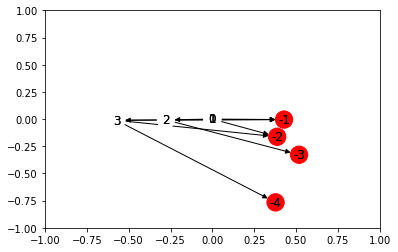

curcost 0.8337539648829012

121
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.34114774e-04 -1.84832217e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.28621295e-01 -4.43294846e-03 -9.99990003e+04 -1.07526480e+05]
 [ 3.87408398e-01 -1.62588347e-01 -9.99990003e+04 -1.04956832e+05]
 [-2.77181377e-01 -6.99139388e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.18218609e-01 -3.27914991e-01 -9.99987750e+04 -2.04896319e+05]
 [-5.72283102e-01 -1.10846348e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.77713787e-01 -7.66294435e-01 -9.99986756e+04 -3.07344887e+05]]


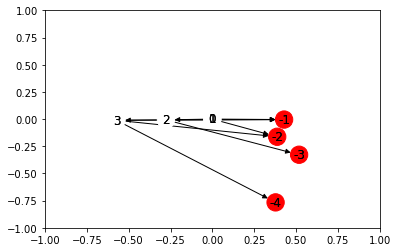

curcost 0.8336955110951273

122
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.34021128e-04 -1.84758284e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.28878467e-01 -4.43560823e-03 -9.99990003e+04 -1.07590996e+05]
 [ 3.87563361e-01 -1.62653382e-01 -9.99990003e+04 -1.04998814e+05]
 [-2.77070504e-01 -6.98859732e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.18322253e-01 -3.27980574e-01 -9.99987750e+04 -2.04937298e+05]
 [-5.72054189e-01 -1.10802009e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.77789330e-01 -7.66447694e-01 -9.99986756e+04 -3.07406356e+05]]


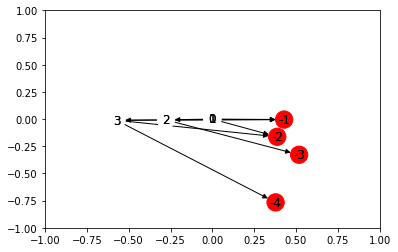

curcost 0.833637363372561

123
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.33927519e-04 -1.84684380e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.29135794e-01 -4.43826959e-03 -9.99990003e+04 -1.07655550e+05]
 [ 3.87718386e-01 -1.62718444e-01 -9.99990003e+04 -1.05040814e+05]
 [-2.76959676e-01 -6.98580188e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.18425918e-01 -3.28046170e-01 -9.99987750e+04 -2.04978285e+05]
 [-5.71825367e-01 -1.10757689e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.77864888e-01 -7.66600984e-01 -9.99986756e+04 -3.07467838e+05]]


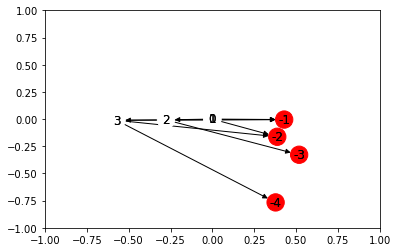

curcost 0.8335795219200356

124
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.33833948e-04 -1.84610507e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.29393276e-01 -4.44093256e-03 -9.99990003e+04 -1.07720144e+05]
 [ 3.87873474e-01 -1.62783531e-01 -9.99990003e+04 -1.05082830e+05]
 [-2.76848892e-01 -6.98300756e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.18529603e-01 -3.28111779e-01 -9.99987750e+04 -2.05019281e+05]
 [-5.71596637e-01 -1.10713386e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.77940461e-01 -7.66754304e-01 -9.99986756e+04 -3.07529331e+05]]


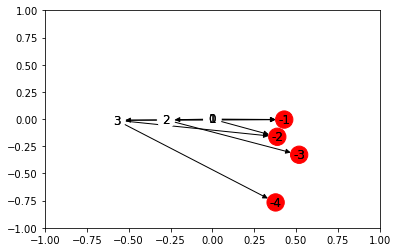

curcost 0.8335219869428877

125
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.33740415e-04 -1.84536662e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.29650912e-01 -4.44359712e-03 -9.99990003e+04 -1.07784776e+05]
 [ 3.88028623e-01 -1.62848644e-01 -9.99990003e+04 -1.05124863e+05]
 [-2.76738152e-01 -6.98021436e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.18633309e-01 -3.28177402e-01 -9.99987750e+04 -2.05060285e+05]
 [-5.71367998e-01 -1.10669100e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.78016049e-01 -7.66907655e-01 -9.99986756e+04 -3.07590837e+05]]


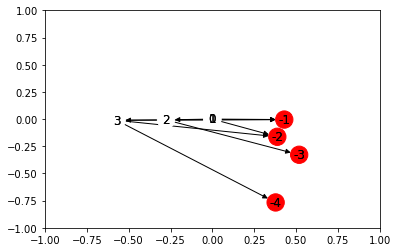

curcost 0.8334647586469577

126
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.33646919e-04 -1.84462848e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.29908702e-01 -4.44626327e-03 -9.99990003e+04 -1.07849447e+05]
 [ 3.88183835e-01 -1.62913784e-01 -9.99990003e+04 -1.05166913e+05]
 [-2.76627457e-01 -6.97742227e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.18737035e-01 -3.28243037e-01 -9.99987750e+04 -2.05101297e+05]
 [-5.71139451e-01 -1.10624833e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.78091652e-01 -7.67061036e-01 -9.99986756e+04 -3.07652355e+05]]


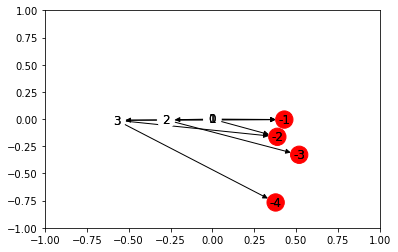

curcost 0.8334078372385879

127
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.33553460e-04 -1.84389063e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.30166648e-01 -4.44893103e-03 -9.99990003e+04 -1.07914156e+05]
 [ 3.88339108e-01 -1.62978949e-01 -9.99990003e+04 -1.05208980e+05]
 [-2.76516806e-01 -6.97463130e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.18840783e-01 -3.28308686e-01 -9.99987750e+04 -2.05142317e+05]
 [-5.70910995e-01 -1.10580583e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.78167270e-01 -7.67214449e-01 -9.99986756e+04 -3.07713886e+05]]


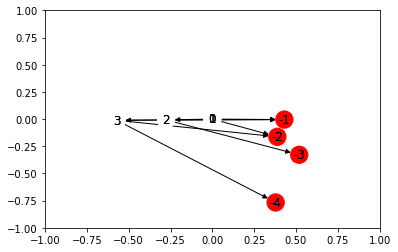

curcost 0.8333512229246258

128
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.33460038e-04 -1.84315307e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.30424748e-01 -4.45160039e-03 -9.99990003e+04 -1.07978905e+05]
 [ 3.88494444e-01 -1.63044141e-01 -9.99990003e+04 -1.05251064e+05]
 [-2.76406199e-01 -6.97184145e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.18944551e-01 -3.28374348e-01 -9.99987750e+04 -2.05183346e+05]
 [-5.70682631e-01 -1.10536350e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.78242904e-01 -7.67367891e-01 -9.99986756e+04 -3.07775428e+05]]


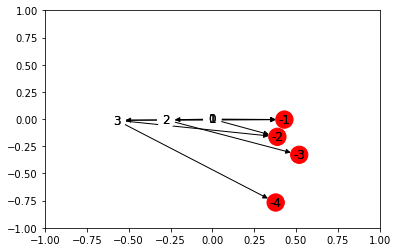

curcost 0.8332949159124201

129
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.33366654e-04 -1.84241581e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.30683002e-01 -4.45427135e-03 -9.99990003e+04 -1.08043692e+05]
 [ 3.88649842e-01 -1.63109359e-01 -9.99990003e+04 -1.05293164e+05]
 [-2.76295637e-01 -6.96905271e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.19048340e-01 -3.28440023e-01 -9.99987750e+04 -2.05224382e+05]
 [-5.70454358e-01 -1.10492136e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.78318552e-01 -7.67521365e-01 -9.99986756e+04 -3.07836983e+05]]


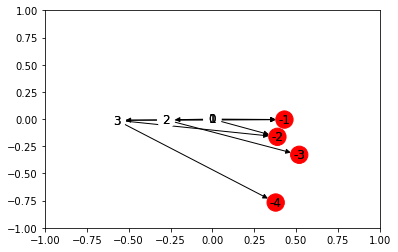

curcost 0.833238916409824

130
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.33273308e-04 -1.84167884e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.30941412e-01 -4.45694391e-03 -9.99990003e+04 -1.08108518e+05]
 [ 3.88805302e-01 -1.63174602e-01 -9.99990003e+04 -1.05335281e+05]
 [-2.76185119e-01 -6.96626509e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.19152149e-01 -3.28505711e-01 -9.99987750e+04 -2.05265427e+05]
 [-5.70226176e-01 -1.10447939e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.78394216e-01 -7.67674869e-01 -9.99986756e+04 -3.07898551e+05]]


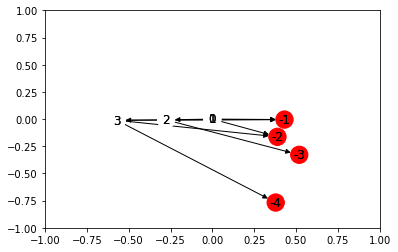

curcost 0.8331832246251928

131
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.33179998e-04 -1.84094217e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.31199977e-01 -4.45961808e-03 -9.99990003e+04 -1.08173383e+05]
 [ 3.88960824e-01 -1.63239872e-01 -9.99990003e+04 -1.05377416e+05]
 [-2.76074645e-01 -6.96347859e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.19255980e-01 -3.28571412e-01 -9.99987750e+04 -2.05306480e+05]
 [-5.69998085e-01 -1.10403760e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.78469895e-01 -7.67828404e-01 -9.99986756e+04 -3.07960131e+05]]


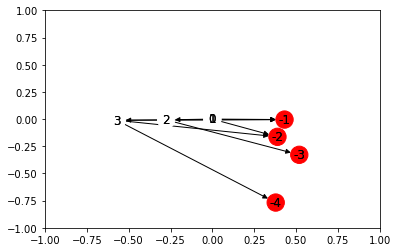

curcost 0.8331278407673851

132
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.33086726e-04 -1.84020579e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.31458697e-01 -4.46229385e-03 -9.99990003e+04 -1.08238287e+05]
 [ 3.89116408e-01 -1.63305168e-01 -9.99990003e+04 -1.05419567e+05]
 [-2.75964215e-01 -6.96069319e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.19359831e-01 -3.28637126e-01 -9.99987750e+04 -2.05347542e+05]
 [-5.69770086e-01 -1.10359598e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.78545589e-01 -7.67981970e-01 -9.99986756e+04 -3.08021723e+05]]


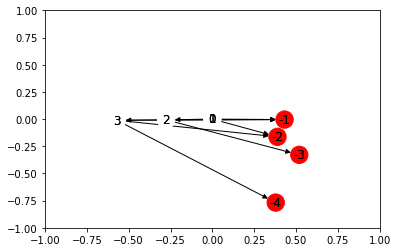

curcost 0.8330727650457623

133
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.32993492e-04 -1.83946971e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.31717572e-01 -4.46497123e-03 -9.99990003e+04 -1.08303230e+05]
 [ 3.89272055e-01 -1.63370490e-01 -9.99990003e+04 -1.05461734e+05]
 [-2.75853829e-01 -6.95790892e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.19463703e-01 -3.28702853e-01 -9.99987750e+04 -2.05388611e+05]
 [-5.69542178e-01 -1.10315454e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.78621298e-01 -7.68135566e-01 -9.99986756e+04 -3.08083327e+05]]


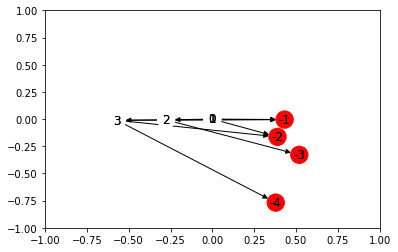

curcost 0.8330179976701895

134
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.32900294e-04 -1.83873392e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.31976603e-01 -4.46765021e-03 -9.99990003e+04 -1.08368212e+05]
 [ 3.89427763e-01 -1.63435838e-01 -9.99990003e+04 -1.05503919e+05]
 [-2.75743488e-01 -6.95512575e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.19567596e-01 -3.28768594e-01 -9.99987750e+04 -2.05429689e+05]
 [-5.69314361e-01 -1.10271328e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.78697022e-01 -7.68289193e-01 -9.99986756e+04 -3.08144944e+05]]


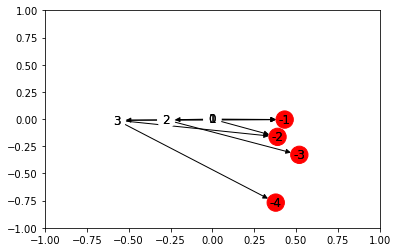

curcost 0.8329635388510339

135
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.32807134e-04 -1.83799843e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.32235789e-01 -4.47033080e-03 -9.99990003e+04 -1.08433233e+05]
 [ 3.89583534e-01 -1.63501213e-01 -9.99990003e+04 -1.05546121e+05]
 [-2.75633190e-01 -6.95234370e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.19671509e-01 -3.28834348e-01 -9.99987750e+04 -2.05470775e+05]
 [-5.69086636e-01 -1.10227220e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.78772762e-01 -7.68442851e-01 -9.99986756e+04 -3.08206573e+05]]


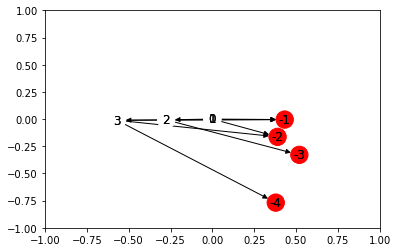

curcost 0.8329093887991655

136
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.32714011e-04 -1.83726323e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.32495130e-01 -4.47301300e-03 -9.99990003e+04 -1.08498293e+05]
 [ 3.89739368e-01 -1.63566613e-01 -9.99990003e+04 -1.05588339e+05]
 [-2.75522937e-01 -6.94956277e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.19775444e-01 -3.28900115e-01 -9.99987750e+04 -2.05511869e+05]
 [-5.68859001e-01 -1.10183129e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.78848516e-01 -7.68596540e-01 -9.99986756e+04 -3.08268214e+05]]


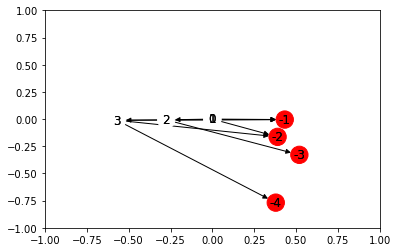

curcost 0.8328555477259575

137
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.32620926e-04 -1.83652833e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.32754627e-01 -4.47569681e-03 -9.99990003e+04 -1.08563392e+05]
 [ 3.89895264e-01 -1.63632040e-01 -9.99990003e+04 -1.05630574e+05]
 [-2.75412728e-01 -6.94678294e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.19879399e-01 -3.28965895e-01 -9.99987750e+04 -2.05552971e+05]
 [-5.68631457e-01 -1.10139056e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.78924286e-01 -7.68750259e-01 -9.99986756e+04 -3.08329868e+05]]


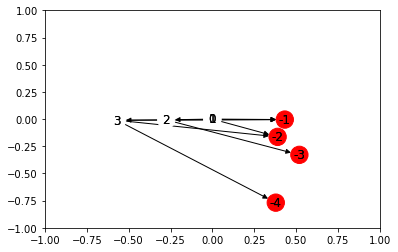

curcost 0.8328020158432858

138
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.32527877e-04 -1.83579371e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.33014280e-01 -4.47838222e-03 -9.99990003e+04 -1.08628530e+05]
 [ 3.90051222e-01 -1.63697493e-01 -9.99990003e+04 -1.05672827e+05]
 [-2.75302563e-01 -6.94400423e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.19983375e-01 -3.29031688e-01 -9.99987750e+04 -2.05594082e+05]
 [-5.68404005e-01 -1.10095000e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.79000071e-01 -7.68904009e-01 -9.99986756e+04 -3.08391534e+05]]


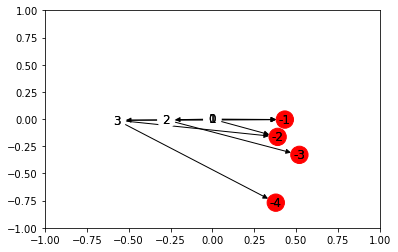

curcost 0.8327487933635291

139
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.32434866e-04 -1.83505940e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.33274089e-01 -4.48106925e-03 -9.99990003e+04 -1.08693707e+05]
 [ 3.90207242e-01 -1.63762972e-01 -9.99990003e+04 -1.05715096e+05]
 [-2.75192442e-01 -6.94122663e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.20087371e-01 -3.29097494e-01 -9.99987750e+04 -2.05635201e+05]
 [-5.68176643e-01 -1.10050962e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.79075871e-01 -7.69057790e-01 -9.99986756e+04 -3.08453212e+05]]


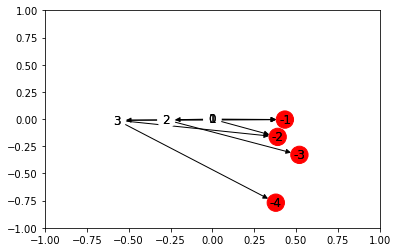

curcost 0.8326958804995684

140
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.32341892e-04 -1.83432537e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.33534053e-01 -4.48375789e-03 -9.99990003e+04 -1.08758924e+05]
 [ 3.90363325e-01 -1.63828477e-01 -9.99990003e+04 -1.05757382e+05]
 [-2.75082365e-01 -6.93845013e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.20191389e-01 -3.29163314e-01 -9.99987750e+04 -2.05676328e+05]
 [-5.67949372e-01 -1.10006942e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.79151686e-01 -7.69211602e-01 -9.99986756e+04 -3.08514902e+05]]


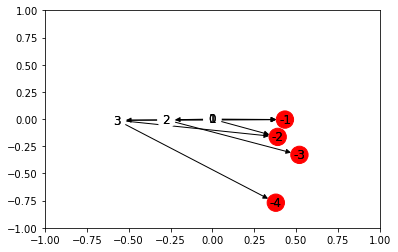

curcost 0.8326432774647886

141
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.32248956e-04 -1.83359164e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.33794174e-01 -4.48644815e-03 -9.99990003e+04 -1.08824179e+05]
 [ 3.90519470e-01 -1.63894008e-01 -9.99990003e+04 -1.05799685e+05]
 [-2.74972332e-01 -6.93567475e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.20295427e-01 -3.29229146e-01 -9.99987750e+04 -2.05717463e+05]
 [-5.67722193e-01 -1.09962939e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.79227516e-01 -7.69365444e-01 -9.99986756e+04 -3.08576605e+05]]


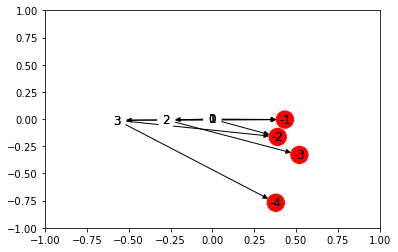

curcost 0.8325909844730759

142
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.32156056e-04 -1.83285821e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.34054450e-01 -4.48914002e-03 -9.99990003e+04 -1.08889473e+05]
 [ 3.90675678e-01 -1.63959566e-01 -9.99990003e+04 -1.05842005e+05]
 [-2.74862343e-01 -6.93290048e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.20399486e-01 -3.29294992e-01 -9.99987750e+04 -2.05758606e+05]
 [-5.67495104e-01 -1.09918954e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.79303362e-01 -7.69519317e-01 -9.99986756e+04 -3.08638321e+05]]


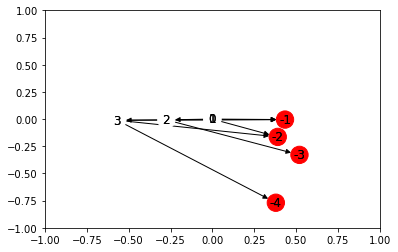

curcost 0.8325390017388203

143
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.32063194e-04 -1.83212506e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.34314883e-01 -4.49183350e-03 -9.99990003e+04 -1.08954807e+05]
 [ 3.90831949e-01 -1.64025150e-01 -9.99990003e+04 -1.05884341e+05]
 [-2.74752398e-01 -6.93012732e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.20503566e-01 -3.29360851e-01 -9.99987750e+04 -2.05799758e+05]
 [-5.67268106e-01 -1.09874986e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.79379223e-01 -7.69673221e-01 -9.99986756e+04 -3.08700048e+05]]


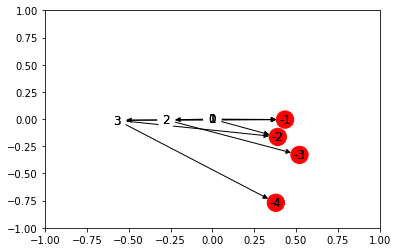

curcost 0.832487329476914

144
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.31970368e-04 -1.83139221e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.34575472e-01 -4.49452860e-03 -9.99990003e+04 -1.09020180e+05]
 [ 3.90988281e-01 -1.64090760e-01 -9.99990003e+04 -1.05926695e+05]
 [-2.74642497e-01 -6.92735527e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.20607667e-01 -3.29426723e-01 -9.99987750e+04 -2.05840918e+05]
 [-5.67041199e-01 -1.09831036e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.79455098e-01 -7.69827155e-01 -9.99986756e+04 -3.08761788e+05]]


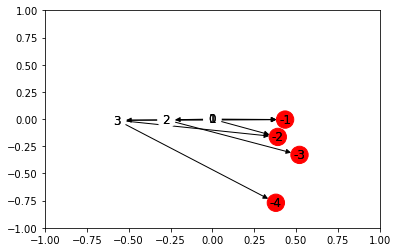

curcost 0.8324359679027517

145
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.31877580e-04 -1.83065966e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.34836217e-01 -4.49722532e-03 -9.99990003e+04 -1.09085592e+05]
 [ 3.91144677e-01 -1.64156396e-01 -9.99990003e+04 -1.05969066e+05]
 [-2.74532640e-01 -6.92458433e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.20711788e-01 -3.29492609e-01 -9.99987750e+04 -2.05882086e+05]
 [-5.66814382e-01 -1.09787104e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.79530989e-01 -7.69981121e-01 -9.99986756e+04 -3.08823541e+05]]


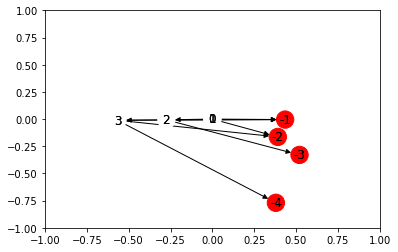

curcost 0.8323849172322314

146
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.31784829e-04 -1.82992739e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.35097119e-01 -4.49992365e-03 -9.99990003e+04 -1.09151043e+05]
 [ 3.91301134e-01 -1.64222059e-01 -9.99990003e+04 -1.06011453e+05]
 [-2.74422827e-01 -6.92181450e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.20815931e-01 -3.29558507e-01 -9.99987750e+04 -2.05923263e+05]
 [-5.66587656e-01 -1.09743189e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.79606896e-01 -7.70135117e-01 -9.99986756e+04 -3.08885305e+05]]


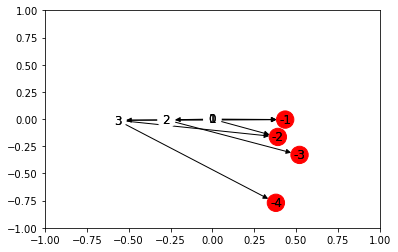

curcost 0.8323341776817536

147
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.31692115e-04 -1.82919542e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.35358177e-01 -4.50262361e-03 -9.99990003e+04 -1.09216534e+05]
 [ 3.91457655e-01 -1.64287747e-01 -9.99990003e+04 -1.06053858e+05]
 [-2.74313058e-01 -6.91904577e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.20920094e-01 -3.29624419e-01 -9.99987750e+04 -2.05964447e+05]
 [-5.66361021e-01 -1.09699292e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.79682817e-01 -7.70289144e-01 -9.99986756e+04 -3.08947083e+05]]


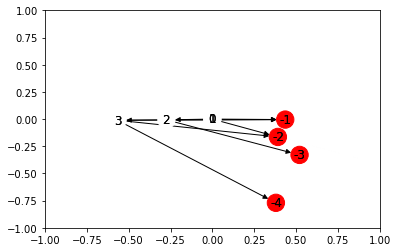

curcost 0.8322837494682215

148
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.31599438e-04 -1.82846374e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.35619392e-01 -4.50532518e-03 -9.99990003e+04 -1.09282064e+05]
 [ 3.91614238e-01 -1.64353463e-01 -9.99990003e+04 -1.06096280e+05]
 [-2.74203333e-01 -6.91627815e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.21024278e-01 -3.29690344e-01 -9.99987750e+04 -2.06005640e+05]
 [-5.66134477e-01 -1.09655412e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.79758754e-01 -7.70443202e-01 -9.99986756e+04 -3.09008872e+05]]


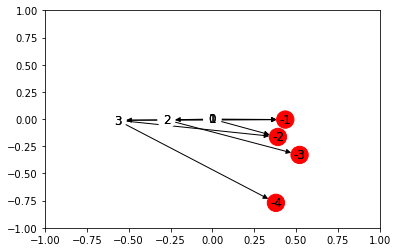

curcost 0.8322336328090404

149
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.31506799e-04 -1.82773236e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.35880764e-01 -4.50802838e-03 -9.99990003e+04 -1.09347633e+05]
 [ 3.91770884e-01 -1.64419204e-01 -9.99990003e+04 -1.06138718e+05]
 [-2.74093651e-01 -6.91351164e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.21128483e-01 -3.29756282e-01 -9.99987750e+04 -2.06046841e+05]
 [-5.65908023e-01 -1.09611550e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.79834705e-01 -7.70597291e-01 -9.99986756e+04 -3.09070674e+05]]


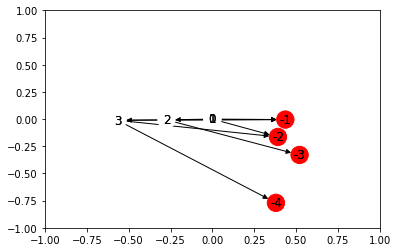

curcost 0.8321838279221192

150
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.31414196e-04 -1.82700127e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.36142292e-01 -4.51073320e-03 -9.99990003e+04 -1.09413242e+05]
 [ 3.91927592e-01 -1.64484972e-01 -9.99990003e+04 -1.06181174e+05]
 [-2.73984014e-01 -6.91074624e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.21232708e-01 -3.29822233e-01 -9.99987750e+04 -2.06088051e+05]
 [-5.65681660e-01 -1.09567705e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.79910672e-01 -7.70751410e-01 -9.99986756e+04 -3.09132488e+05]]


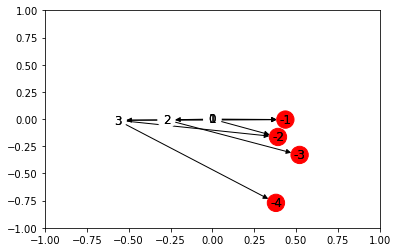

curcost 0.8321343350258694

151
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.31321630e-04 -1.82627046e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.36403977e-01 -4.51343964e-03 -9.99990003e+04 -1.09478890e+05]
 [ 3.92084363e-01 -1.64550766e-01 -9.99990003e+04 -1.06223646e+05]
 [-2.73874420e-01 -6.90798194e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.21336955e-01 -3.29888197e-01 -9.99987750e+04 -2.06129268e+05]
 [-5.65455387e-01 -1.09523878e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.79986654e-01 -7.70905560e-01 -9.99986756e+04 -3.09194314e+05]]


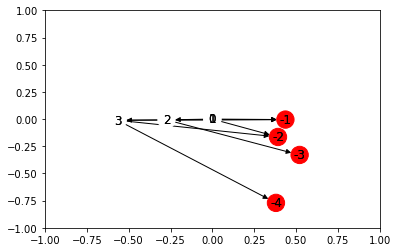

curcost 0.8320851543392048

152
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.31229101e-04 -1.82553996e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.36665820e-01 -4.51614770e-03 -9.99990003e+04 -1.09544577e+05]
 [ 3.92241197e-01 -1.64616586e-01 -9.99990003e+04 -1.06266136e+05]
 [-2.73764870e-01 -6.90521875e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.21441222e-01 -3.29954175e-01 -9.99987750e+04 -2.06170494e+05]
 [-5.65229205e-01 -1.09480068e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.80062652e-01 -7.71059741e-01 -9.99986756e+04 -3.09256153e+05]]


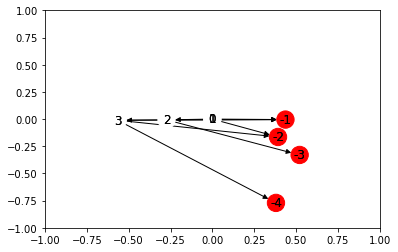

curcost 0.8320362860815425

153
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.31136610e-04 -1.82480974e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.36927819e-01 -4.51885739e-03 -9.99990003e+04 -1.09610304e+05]
 [ 3.92398093e-01 -1.64682433e-01 -9.99990003e+04 -1.06308642e+05]
 [-2.73655364e-01 -6.90245666e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.21545510e-01 -3.30020166e-01 -9.99987750e+04 -2.06211728e+05]
 [-5.65003113e-01 -1.09436276e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.80138664e-01 -7.71213953e-01 -9.99986756e+04 -3.09318004e+05]]


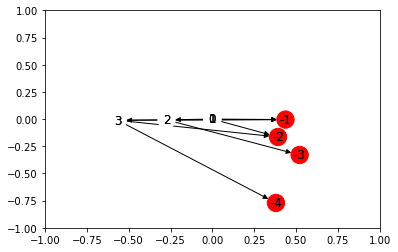

curcost 0.8319877304728021

154
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.31044155e-04 -1.82407982e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.37189976e-01 -4.52156870e-03 -9.99990003e+04 -1.09676070e+05]
 [ 3.92555053e-01 -1.64748306e-01 -9.99990003e+04 -1.06351165e+05]
 [-2.73545902e-01 -6.89969568e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.21649820e-01 -3.30086170e-01 -9.99987750e+04 -2.06252971e+05]
 [-5.64777112e-01 -1.09392502e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.80214692e-01 -7.71368196e-01 -9.99986756e+04 -3.09379868e+05]]


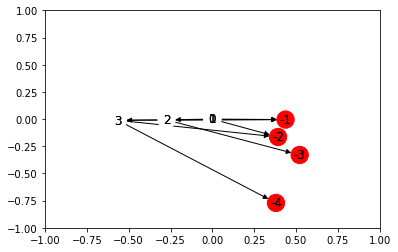

curcost 0.8319394877334056

155
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.30951738e-04 -1.82335018e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.37452290e-01 -4.52428164e-03 -9.99990003e+04 -1.09741876e+05]
 [ 3.92712075e-01 -1.64814205e-01 -9.99990003e+04 -1.06393706e+05]
 [-2.73436484e-01 -6.89693580e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.21754150e-01 -3.30152187e-01 -9.99987750e+04 -2.06294221e+05]
 [-5.64551201e-01 -1.09348745e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.80290735e-01 -7.71522470e-01 -9.99986756e+04 -3.09441744e+05]]


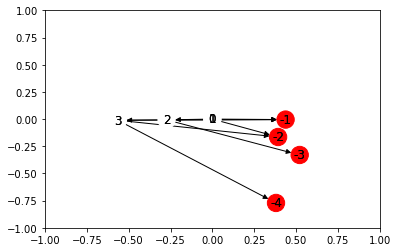

curcost 0.8318915580842791

156
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.30859357e-04 -1.82262084e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.37714761e-01 -4.52699621e-03 -9.99990003e+04 -1.09807721e+05]
 [ 3.92869159e-01 -1.64880131e-01 -9.99990003e+04 -1.06436263e+05]
 [-2.73327109e-01 -6.89417702e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.21858500e-01 -3.30218218e-01 -9.99987750e+04 -2.06335480e+05]
 [-5.64325381e-01 -1.09305005e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.80366793e-01 -7.71676774e-01 -9.99986756e+04 -3.09503632e+05]]


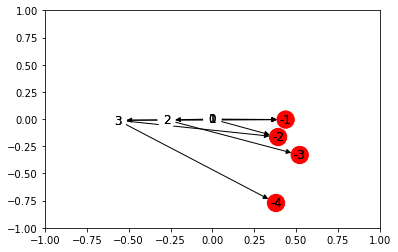

curcost 0.8318439417468507

157
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.30767013e-04 -1.82189180e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.37977390e-01 -4.52971241e-03 -9.99990003e+04 -1.09873605e+05]
 [ 3.93026307e-01 -1.64946083e-01 -9.99990003e+04 -1.06478838e+05]
 [-2.73217778e-01 -6.89141935e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.21962872e-01 -3.30284261e-01 -9.99987750e+04 -2.06376747e+05]
 [-5.64099651e-01 -1.09261283e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.80442866e-01 -7.71831110e-01 -9.99986756e+04 -3.09565533e+05]]


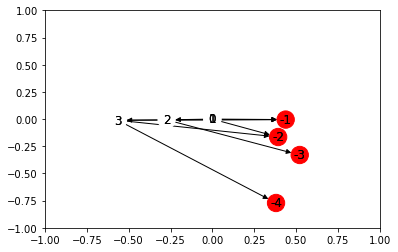

curcost 0.8317966389430511

158
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.30674706e-04 -1.82116304e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.38240177e-01 -4.53243024e-03 -9.99990003e+04 -1.09939530e+05]
 [ 3.93183518e-01 -1.65012061e-01 -9.99990003e+04 -1.06521429e+05]
 [-2.73108491e-01 -6.88866279e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.22067265e-01 -3.30350318e-01 -9.99987750e+04 -2.06418023e+05]
 [-5.63874011e-01 -1.09217579e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.80518955e-01 -7.71985476e-01 -9.99986756e+04 -3.09627446e+05]]


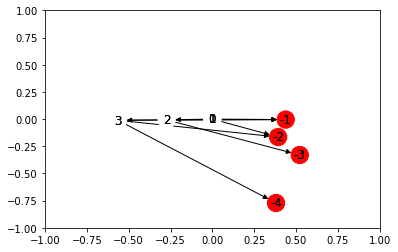

curcost 0.8317496498953151

159
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.30582436e-04 -1.82043457e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.38503121e-01 -4.53514970e-03 -9.99990003e+04 -1.10005493e+05]
 [ 3.93340791e-01 -1.65078066e-01 -9.99990003e+04 -1.06564038e+05]
 [-2.72999248e-01 -6.88590732e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.22171678e-01 -3.30416388e-01 -9.99987750e+04 -2.06459306e+05]
 [-5.63648461e-01 -1.09173892e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.80595059e-01 -7.72139873e-01 -9.99986756e+04 -3.09689372e+05]]


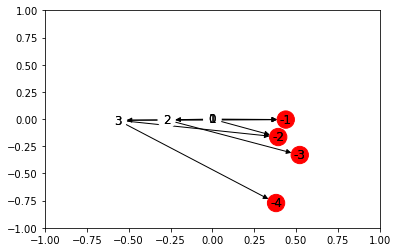

curcost 0.8317029748265794

160
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.30490203e-04 -1.81970640e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.38766223e-01 -4.53787079e-03 -9.99990003e+04 -1.10071497e+05]
 [ 3.93498127e-01 -1.65144097e-01 -9.99990003e+04 -1.06606664e+05]
 [-2.72890048e-01 -6.88315296e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.22276112e-01 -3.30482471e-01 -9.99987750e+04 -2.06500598e+05]
 [-5.63423002e-01 -1.09130222e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.80671178e-01 -7.72294301e-01 -9.99986756e+04 -3.09751310e+05]]


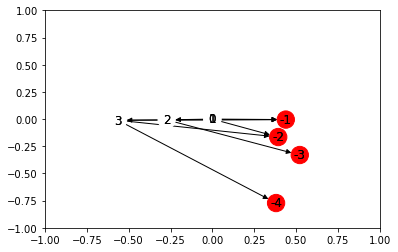

curcost 0.8316566139602847

161
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.30398007e-04 -1.81897852e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.39029482e-01 -4.54059351e-03 -9.99990003e+04 -1.10137539e+05]
 [ 3.93655527e-01 -1.65210155e-01 -9.99990003e+04 -1.06649306e+05]
 [-2.72780892e-01 -6.88039970e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.22380568e-01 -3.30548568e-01 -9.99987750e+04 -2.06541898e+05]
 [-5.63197633e-01 -1.09086570e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.80747312e-01 -7.72448760e-01 -9.99986756e+04 -3.09813260e+05]]


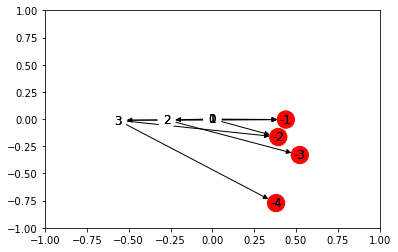

curcost 0.8316105675203741

162
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.30305848e-04 -1.81825093e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.39292900e-01 -4.54331786e-03 -9.99990003e+04 -1.10203622e+05]
 [ 3.93812989e-01 -1.65276239e-01 -9.99990003e+04 -1.06691966e+05]
 [-2.72671780e-01 -6.87764754e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.22485044e-01 -3.30614678e-01 -9.99987750e+04 -2.06583207e+05]
 [-5.62972353e-01 -1.09042936e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.80823462e-01 -7.72603250e-01 -9.99986756e+04 -3.09875223e+05]]


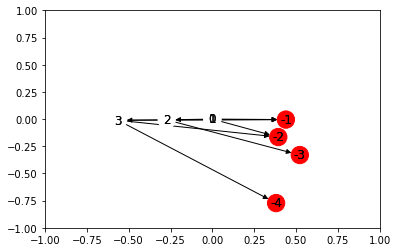

curcost 0.8315648357312939

163
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.30213726e-04 -1.81752363e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.39556476e-01 -4.54604385e-03 -9.99990003e+04 -1.10269744e+05]
 [ 3.93970514e-01 -1.65342349e-01 -9.99990003e+04 -1.06734643e+05]
 [-2.72562711e-01 -6.87489648e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.22589541e-01 -3.30680801e-01 -9.99987750e+04 -2.06624523e+05]
 [-5.62747165e-01 -1.08999318e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.80899626e-01 -7.72757770e-01 -9.99986756e+04 -3.09937198e+05]]


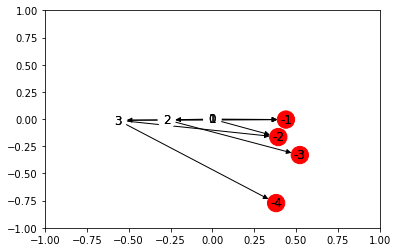

curcost 0.8315194188179945

164
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.30121640e-04 -1.81679662e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.39820210e-01 -4.54877148e-03 -9.99990003e+04 -1.10335906e+05]
 [ 3.94128102e-01 -1.65408486e-01 -9.99990003e+04 -1.06777337e+05]
 [-2.72453686e-01 -6.87214652e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.22694059e-01 -3.30746937e-01 -9.99987750e+04 -2.06665848e+05]
 [-5.62522066e-01 -1.08955719e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.80975806e-01 -7.72912322e-01 -9.99986756e+04 -3.09999185e+05]]


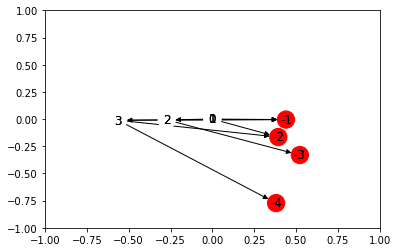

curcost 0.8314743170059287

165
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.30029592e-04 -1.81606990e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.40084102e-01 -4.55150074e-03 -9.99990003e+04 -1.10402108e+05]
 [ 3.94285753e-01 -1.65474650e-01 -9.99990003e+04 -1.06820048e+05]
 [-2.72344705e-01 -6.86939766e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.22798598e-01 -3.30813086e-01 -9.99987750e+04 -2.06707181e+05]
 [-5.62297057e-01 -1.08912136e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.81052001e-01 -7.73066904e-01 -9.99986756e+04 -3.10061185e+05]]


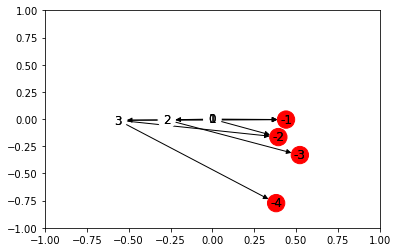

curcost 0.8314295305210526

166
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.29937580e-04 -1.81534347e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.40348152e-01 -4.55423164e-03 -9.99990003e+04 -1.10468349e+05]
 [ 3.94443468e-01 -1.65540839e-01 -9.99990003e+04 -1.06862776e+05]
 [-2.72235767e-01 -6.86664990e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.22903157e-01 -3.30879249e-01 -9.99987750e+04 -2.06748523e+05]
 [-5.62072138e-01 -1.08868571e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.81128212e-01 -7.73221518e-01 -9.99986756e+04 -3.10123197e+05]]


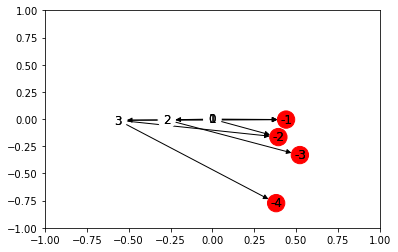

curcost 0.8313850595898266

167
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.29845605e-04 -1.81461733e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.40612361e-01 -4.55696418e-03 -9.99990003e+04 -1.10534630e+05]
 [ 3.94601245e-01 -1.65607056e-01 -9.99990003e+04 -1.06905521e+05]
 [-2.72126872e-01 -6.86390324e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.23007738e-01 -3.30945425e-01 -9.99987750e+04 -2.06789872e+05]
 [-5.61847309e-01 -1.08825024e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.81204437e-01 -7.73376162e-01 -9.99986756e+04 -3.10185222e+05]]


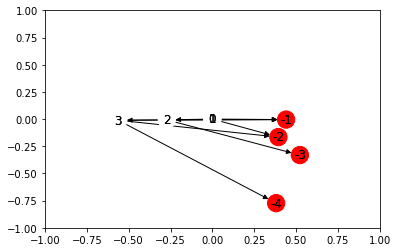

curcost 0.8313409044392136

168
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.29753667e-04 -1.81389149e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.40876728e-01 -4.55969836e-03 -9.99990003e+04 -1.10600951e+05]
 [ 3.94759086e-01 -1.65673299e-01 -9.99990003e+04 -1.06948283e+05]
 [-2.72018022e-01 -6.86115768e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.23112339e-01 -3.31011614e-01 -9.99987750e+04 -2.06831230e+05]
 [-5.61622570e-01 -1.08781494e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.81280678e-01 -7.73530837e-01 -9.99986756e+04 -3.10247259e+05]]


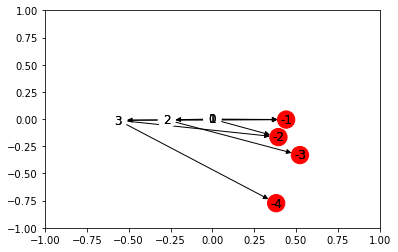

curcost 0.8312970652966807

169
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.29661765e-04 -1.81316593e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.41141255e-01 -4.56243418e-03 -9.99990003e+04 -1.10667311e+05]
 [ 3.94916989e-01 -1.65739568e-01 -9.99990003e+04 -1.06991062e+05]
 [-2.71909214e-01 -6.85841322e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.23216962e-01 -3.31077816e-01 -9.99987750e+04 -2.06872597e+05]
 [-5.61397921e-01 -1.08737981e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.81356934e-01 -7.73685543e-01 -9.99986756e+04 -3.10309308e+05]]


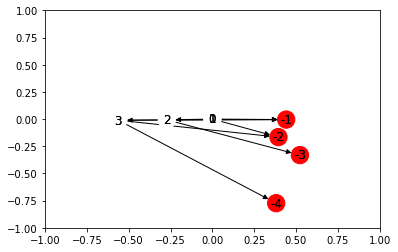

curcost 0.8312535423901986

170
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.29569900e-04 -1.81244066e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.41405939e-01 -4.56517164e-03 -9.99990003e+04 -1.10733712e+05]
 [ 3.95074956e-01 -1.65805864e-01 -9.99990003e+04 -1.07033859e+05]
 [-2.71800451e-01 -6.85566985e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.23321605e-01 -3.31144032e-01 -9.99987750e+04 -2.06913971e+05]
 [-5.61173362e-01 -1.08694486e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.81433206e-01 -7.73840280e-01 -9.99986756e+04 -3.10371370e+05]]


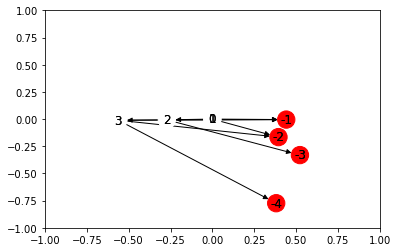

curcost 0.831210335948241

171
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.29478072e-04 -1.81171569e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.41670783e-01 -4.56791074e-03 -9.99990003e+04 -1.10800152e+05]
 [ 3.95232986e-01 -1.65872186e-01 -9.99990003e+04 -1.07076672e+05]
 [-2.71691731e-01 -6.85292758e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.23426270e-01 -3.31210260e-01 -9.99987750e+04 -2.06955354e+05]
 [-5.60948893e-01 -1.08651008e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.81509492e-01 -7.73995049e-01 -9.99986756e+04 -3.10433444e+05]]


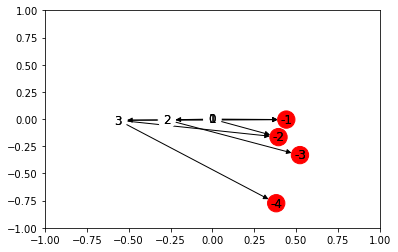

curcost 0.8311674461997867

172
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.29386281e-04 -1.81099100e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.41935785e-01 -4.57065149e-03 -9.99990003e+04 -1.10866632e+05]
 [ 3.95391079e-01 -1.65938535e-01 -9.99990003e+04 -1.07119503e+05]
 [-2.71583054e-01 -6.85018641e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.23530955e-01 -3.31276502e-01 -9.99987750e+04 -2.06996745e+05]
 [-5.60724513e-01 -1.08607548e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.81585794e-01 -7.74149848e-01 -9.99986756e+04 -3.10495531e+05]]


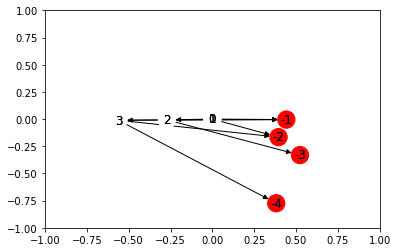

curcost 0.8311248733743176

173
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.29294527e-04 -1.81026660e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.42200947e-01 -4.57339388e-03 -9.99990003e+04 -1.10933152e+05]
 [ 3.95549236e-01 -1.66004910e-01 -9.99990003e+04 -1.07162351e+05]
 [-2.71474421e-01 -6.84744634e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.23635661e-01 -3.31342758e-01 -9.99987750e+04 -2.07038144e+05]
 [-5.60500223e-01 -1.08564105e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.81662111e-01 -7.74304677e-01 -9.99986756e+04 -3.10557630e+05]]


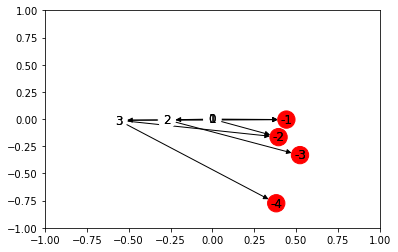

curcost 0.8310826177018193

174
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.29202809e-04 -1.80954250e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.42466267e-01 -4.57613792e-03 -9.99990003e+04 -1.10999712e+05]
 [ 3.95707455e-01 -1.66071312e-01 -9.99990003e+04 -1.07205216e+05]
 [-2.71365831e-01 -6.84470736e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.23740388e-01 -3.31409026e-01 -9.99987750e+04 -2.07079552e+05]
 [-5.60276023e-01 -1.08520679e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.81738444e-01 -7.74459538e-01 -9.99986756e+04 -3.10619742e+05]]


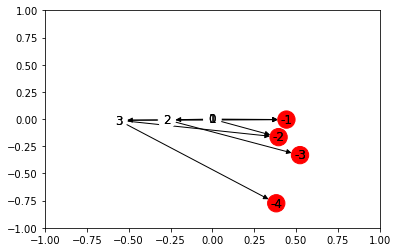

curcost 0.8310406794127826

175
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.29111128e-04 -1.80881868e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.42731747e-01 -4.57888360e-03 -9.99990003e+04 -1.11066312e+05]
 [ 3.95865738e-01 -1.66137741e-01 -9.99990003e+04 -1.07248098e+05]
 [-2.71257285e-01 -6.84196948e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.23845136e-01 -3.31475308e-01 -9.99987750e+04 -2.07120968e+05]
 [-5.60051913e-01 -1.08477271e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.81814792e-01 -7.74614430e-01 -9.99986756e+04 -3.10681866e+05]]


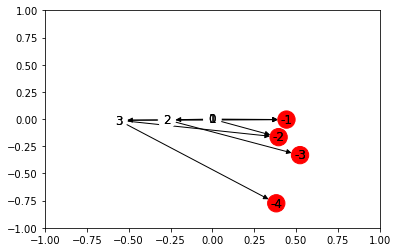

curcost 0.830999058738201

176
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.29019483e-04 -1.80809515e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.42997386e-01 -4.58163093e-03 -9.99990003e+04 -1.11132951e+05]
 [ 3.96024085e-01 -1.66204196e-01 -9.99990003e+04 -1.07290997e+05]
 [-2.71148782e-01 -6.83923269e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.23949905e-01 -3.31541603e-01 -9.99987750e+04 -2.07162392e+05]
 [-5.59827892e-01 -1.08433880e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.81891155e-01 -7.74769353e-01 -9.99986756e+04 -3.10744002e+05]]


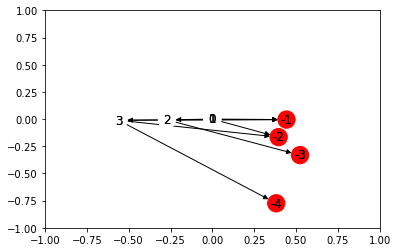

curcost 0.8309577559095738

177
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.28927876e-04 -1.80737191e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.43263185e-01 -4.58437991e-03 -9.99990003e+04 -1.11199631e+05]
 [ 3.96182494e-01 -1.66270678e-01 -9.99990003e+04 -1.07333913e+05]
 [-2.71040322e-01 -6.83649700e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.24054695e-01 -3.31607912e-01 -9.99987750e+04 -2.07203825e+05]
 [-5.59603961e-01 -1.08390507e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.81967533e-01 -7.74924307e-01 -9.99986756e+04 -3.10806151e+05]]


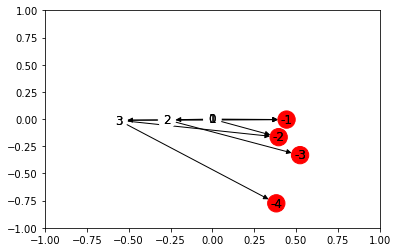

curcost 0.8309167711589036

178
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.28836304e-04 -1.80664897e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.43529143e-01 -4.58713054e-03 -9.99990003e+04 -1.11266351e+05]
 [ 3.96340967e-01 -1.66337186e-01 -9.99990003e+04 -1.07376847e+05]
 [-2.70931906e-01 -6.83376240e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.24159506e-01 -3.31674233e-01 -9.99987750e+04 -2.07245265e+05]
 [-5.59380119e-01 -1.08347150e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.82043926e-01 -7.75079292e-01 -9.99986756e+04 -3.10868312e+05]]


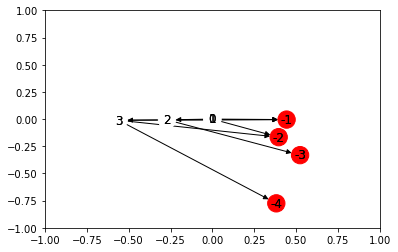

curcost 0.8308761047186982

179
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.28744770e-04 -1.80592631e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.43795260e-01 -4.58988282e-03 -9.99990003e+04 -1.11333111e+05]
 [ 3.96499504e-01 -1.66403721e-01 -9.99990003e+04 -1.07419798e+05]
 [-2.70823533e-01 -6.83102889e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.24264338e-01 -3.31740568e-01 -9.99987750e+04 -2.07286714e+05]
 [-5.59156367e-01 -1.08303812e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.82120335e-01 -7.75234308e-01 -9.99986756e+04 -3.10930486e+05]]


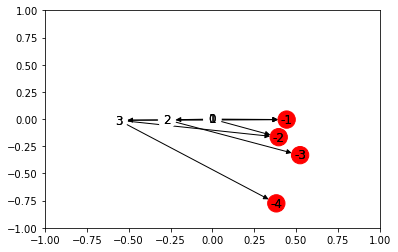

curcost 0.8308357568219696

180
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.28653272e-04 -1.80520394e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.44061537e-01 -4.59263675e-03 -9.99990003e+04 -1.11399911e+05]
 [ 3.96658103e-01 -1.66470282e-01 -9.99990003e+04 -1.07462766e+05]
 [-2.70715204e-01 -6.82829648e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.24369191e-01 -3.31806916e-01 -9.99987750e+04 -2.07328172e+05]
 [-5.58932705e-01 -1.08260490e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.82196759e-01 -7.75389355e-01 -9.99986756e+04 -3.10992672e+05]]


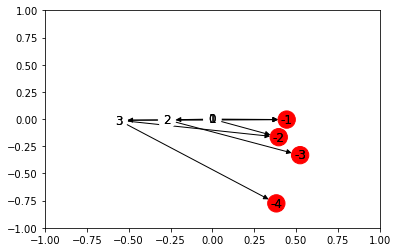

curcost 0.830795727702235

181
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.28561811e-04 -1.80448185e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.44327974e-01 -4.59539233e-03 -9.99990003e+04 -1.11466751e+05]
 [ 3.96816767e-01 -1.66536870e-01 -9.99990003e+04 -1.07505751e+05]
 [-2.70606918e-01 -6.82556516e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.24474065e-01 -3.31873277e-01 -9.99987750e+04 -2.07369637e+05]
 [-5.58709132e-01 -1.08217186e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.82273199e-01 -7.75544433e-01 -9.99986756e+04 -3.11054870e+05]]


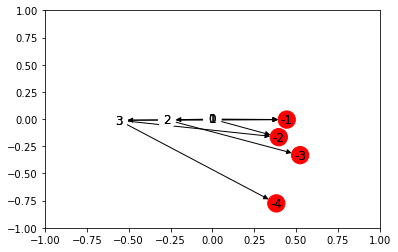

curcost 0.8307560175935161

182
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.28470386e-04 -1.80376006e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.44594571e-01 -4.59814956e-03 -9.99990003e+04 -1.11533631e+05]
 [ 3.96975493e-01 -1.66603485e-01 -9.99990003e+04 -1.07548753e+05]
 [-2.70498675e-01 -6.82283494e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.24578960e-01 -3.31939652e-01 -9.99987750e+04 -2.07411111e+05]
 [-5.58485648e-01 -1.08173899e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.82349653e-01 -7.75699541e-01 -9.99986756e+04 -3.11117081e+05]]


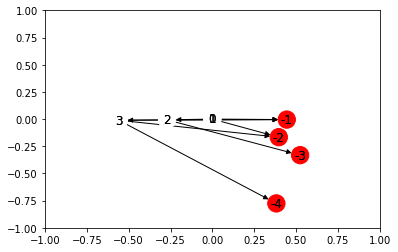

curcost 0.83071662673034

183
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.28378998e-04 -1.80303856e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.44861328e-01 -4.60090845e-03 -9.99990003e+04 -1.11600551e+05]
 [ 3.97134284e-01 -1.66670127e-01 -9.99990003e+04 -1.07591772e+05]
 [-2.70390476e-01 -6.82010580e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.24683875e-01 -3.32006040e-01 -9.99987750e+04 -2.07452593e+05]
 [-5.58262254e-01 -1.08130629e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.82426123e-01 -7.75854681e-01 -9.99986756e+04 -3.11179305e+05]]


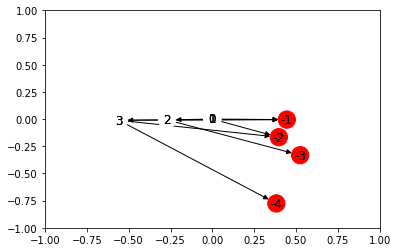

curcost 0.8306775553477384

184
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.28287646e-04 -1.80231734e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.45128244e-01 -4.60366900e-03 -9.99990003e+04 -1.11667511e+05]
 [ 3.97293137e-01 -1.66736795e-01 -9.99990003e+04 -1.07634809e+05]
 [-2.70282319e-01 -6.81737776e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.24788812e-01 -3.32072441e-01 -9.99987750e+04 -2.07494084e+05]
 [-5.58038949e-01 -1.08087377e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.82502608e-01 -7.76009852e-01 -9.99986756e+04 -3.11241541e+05]]


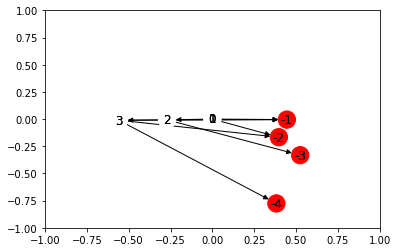

curcost 0.8306388036812485

185
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.28196331e-04 -1.80159642e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.45395321e-01 -4.60643120e-03 -9.99990003e+04 -1.11734512e+05]
 [ 3.97452055e-01 -1.66803489e-01 -9.99990003e+04 -1.07677863e+05]
 [-2.70174206e-01 -6.81465081e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.24893770e-01 -3.32138856e-01 -9.99987750e+04 -2.07535583e+05]
 [-5.57815733e-01 -1.08044142e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.82579109e-01 -7.76165054e-01 -9.99986756e+04 -3.11303789e+05]]


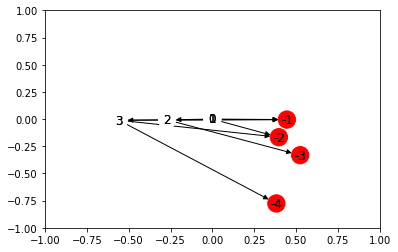

curcost 0.8306003719669134

186
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.28105053e-04 -1.80087578e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.45662559e-01 -4.60919506e-03 -9.99990003e+04 -1.11801552e+05]
 [ 3.97611035e-01 -1.66870211e-01 -9.99990003e+04 -1.07720934e+05]
 [-2.70066137e-01 -6.81192495e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.24998749e-01 -3.32205283e-01 -9.99987750e+04 -2.07577090e+05]
 [-5.57592607e-01 -1.08000925e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.82655625e-01 -7.76320287e-01 -9.99986756e+04 -3.11366050e+05]]


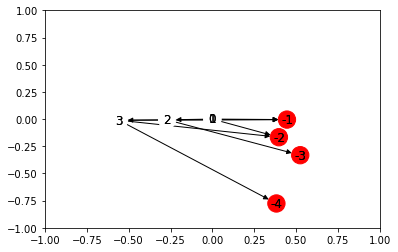

curcost 0.8305622604412808

187
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.28013811e-04 -1.80015543e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.45929956e-01 -4.61196057e-03 -9.99990003e+04 -1.11868633e+05]
 [ 3.97770080e-01 -1.66936959e-01 -9.99990003e+04 -1.07764023e+05]
 [-2.69958110e-01 -6.80920018e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.25103748e-01 -3.32271725e-01 -9.99987750e+04 -2.07618605e+05]
 [-5.57369570e-01 -1.07957724e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.82732156e-01 -7.76475551e-01 -9.99986756e+04 -3.11428323e+05]]


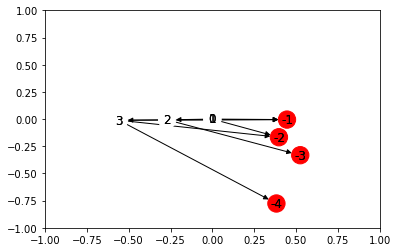

curcost 0.8305244693414051

188
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.27922605e-04 -1.79943536e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.46197514e-01 -4.61472775e-03 -9.99990003e+04 -1.11935754e+05]
 [ 3.97929188e-01 -1.67003734e-01 -9.99990003e+04 -1.07807128e+05]
 [-2.69850127e-01 -6.80647650e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.25208769e-01 -3.32338179e-01 -9.99987750e+04 -2.07660129e+05]
 [-5.57146622e-01 -1.07914541e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.82808702e-01 -7.76630846e-01 -9.99986756e+04 -3.11490608e+05]]


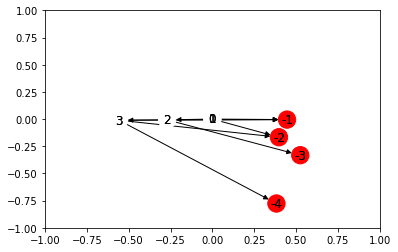

curcost 0.8304869989048462

189
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.27831436e-04 -1.79871559e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.46465233e-01 -4.61749659e-03 -9.99990003e+04 -1.12002916e+05]
 [ 3.98088359e-01 -1.67070535e-01 -9.99990003e+04 -1.07850251e+05]
 [-2.69742187e-01 -6.80375391e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.25313811e-01 -3.32404647e-01 -9.99987750e+04 -2.07701661e+05]
 [-5.56923763e-01 -1.07871375e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.82885264e-01 -7.76786173e-01 -9.99986756e+04 -3.11552907e+05]]


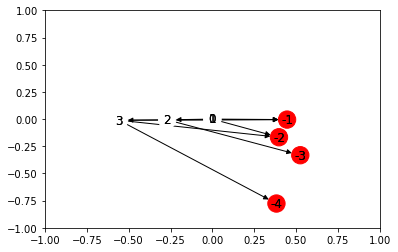

curcost 0.8304498493696696

190
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.27740303e-04 -1.79799610e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.46733112e-01 -4.62026709e-03 -9.99990003e+04 -1.12070118e+05]
 [ 3.98247595e-01 -1.67137363e-01 -9.99990003e+04 -1.07893391e+05]
 [-2.69634290e-01 -6.80103241e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.25418874e-01 -3.32471127e-01 -9.99987750e+04 -2.07743201e+05]
 [-5.56700994e-01 -1.07828227e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.82961841e-01 -7.76941530e-01 -9.99986756e+04 -3.11615217e+05]]


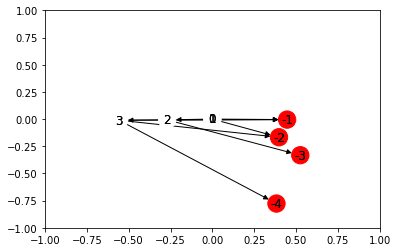

curcost 0.8304130209744477

191
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.27649207e-04 -1.79727691e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.47001152e-01 -4.62303925e-03 -9.99990003e+04 -1.12137360e+05]
 [ 3.98406894e-01 -1.67204218e-01 -9.99990003e+04 -1.07936549e+05]
 [-2.69526436e-01 -6.79831199e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.25523957e-01 -3.32537622e-01 -9.99987750e+04 -2.07784750e+05]
 [-5.56478314e-01 -1.07785095e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.83038433e-01 -7.77096918e-01 -9.99986756e+04 -3.11677540e+05]]


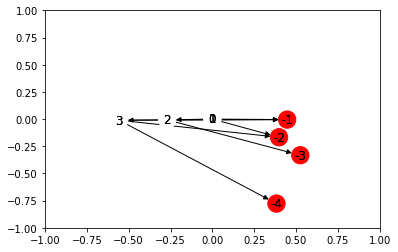

curcost 0.8303765139582585

192
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.27558148e-04 -1.79655799e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.47269352e-01 -4.62581307e-03 -9.99990003e+04 -1.12204642e+05]
 [ 3.98566257e-01 -1.67271100e-01 -9.99990003e+04 -1.07979723e+05]
 [-2.69418626e-01 -6.79559267e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.25629062e-01 -3.32604129e-01 -9.99987750e+04 -2.07826307e+05]
 [-5.56255722e-01 -1.07741981e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.83115041e-01 -7.77252338e-01 -9.99986756e+04 -3.11739876e+05]]


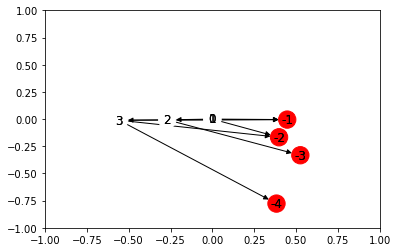

curcost 0.8303403285606875

193
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.27467124e-04 -1.79583937e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.47537714e-01 -4.62858856e-03 -9.99990003e+04 -1.12271965e+05]
 [ 3.98725683e-01 -1.67338008e-01 -9.99990003e+04 -1.08022915e+05]
 [-2.69310858e-01 -6.79287443e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.25734188e-01 -3.32670650e-01 -9.99987750e+04 -2.07867872e+05]
 [-5.56033220e-01 -1.07698885e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.83191664e-01 -7.77407788e-01 -9.99986756e+04 -3.11802224e+05]]


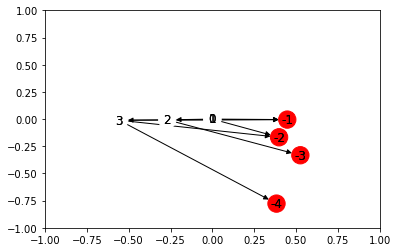

curcost 0.8303044650218253

194
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.27376137e-04 -1.79512104e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.47806236e-01 -4.63136571e-03 -9.99990003e+04 -1.12339328e+05]
 [ 3.98885173e-01 -1.67404944e-01 -9.99990003e+04 -1.08066124e+05]
 [-2.69203134e-01 -6.79015728e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.25839335e-01 -3.32737184e-01 -9.99987750e+04 -2.07909446e+05]
 [-5.55810807e-01 -1.07655805e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.83268302e-01 -7.77563270e-01 -9.99986756e+04 -3.11864584e+05]]


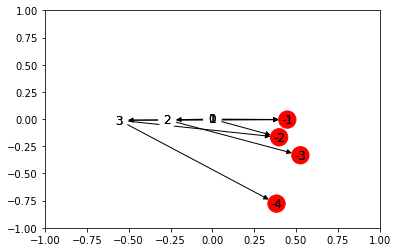

curcost 0.830268923582271

195
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.27285187e-04 -1.79440299e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.48074920e-01 -4.63414453e-03 -9.99990003e+04 -1.12406732e+05]
 [ 3.99044727e-01 -1.67471906e-01 -9.99990003e+04 -1.08109351e+05]
 [-2.69095453e-01 -6.78744122e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.25944503e-01 -3.32803732e-01 -9.99987750e+04 -2.07951028e+05]
 [-5.55588482e-01 -1.07612743e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.83344956e-01 -7.77718782e-01 -9.99986756e+04 -3.11926957e+05]]


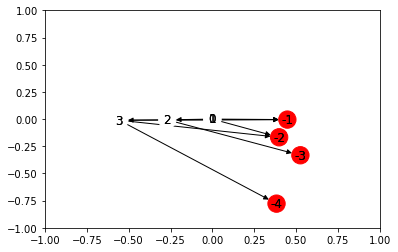

curcost 0.8302337044831299

196
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.27194273e-04 -1.79368523e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.48343765e-01 -4.63692502e-03 -9.99990003e+04 -1.12474176e+05]
 [ 3.99204345e-01 -1.67538894e-01 -9.99990003e+04 -1.08152594e+05]
 [-2.68987815e-01 -6.78472624e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.26049692e-01 -3.32870292e-01 -9.99987750e+04 -2.07992618e+05]
 [-5.55366247e-01 -1.07569698e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.83421625e-01 -7.77874326e-01 -9.99986756e+04 -3.11989342e+05]]


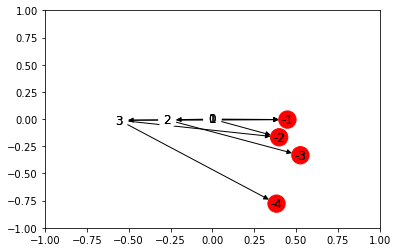

curcost 0.8301988079660148

197
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.27103395e-04 -1.79296775e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.48612771e-01 -4.63970717e-03 -9.99990003e+04 -1.12541660e+05]
 [ 3.99364027e-01 -1.67605910e-01 -9.99990003e+04 -1.08195855e+05]
 [-2.68880219e-01 -6.78201235e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.26154902e-01 -3.32936866e-01 -9.99987750e+04 -2.08034216e+05]
 [-5.55144100e-01 -1.07526670e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.83498309e-01 -7.78029901e-01 -9.99986756e+04 -3.12051740e+05]]


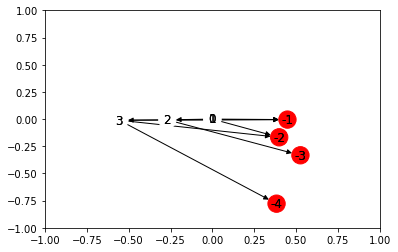

curcost 0.8301642342730455

198
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.27012554e-04 -1.79225056e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.48881939e-01 -4.64249100e-03 -9.99990003e+04 -1.12609185e+05]
 [ 3.99523773e-01 -1.67672952e-01 -9.99990003e+04 -1.08239134e+05]
 [-2.68772667e-01 -6.77929955e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.26260133e-01 -3.33003454e-01 -9.99987750e+04 -2.08075823e+05]
 [-5.54922043e-01 -1.07483659e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.83575009e-01 -7.78185507e-01 -9.99986756e+04 -3.12114151e+05]]


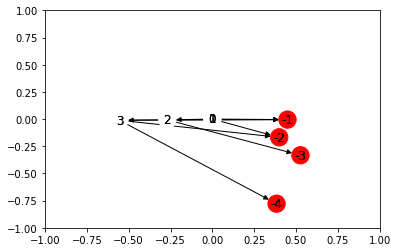

curcost 0.8301299836468502

199
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.26921749e-04 -1.79153366e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.49151268e-01 -4.64527649e-03 -9.99990003e+04 -1.12676751e+05]
 [ 3.99683582e-01 -1.67740021e-01 -9.99990003e+04 -1.08282429e+05]
 [-2.68665158e-01 -6.77658783e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.26365385e-01 -3.33070054e-01 -9.99987750e+04 -2.08117438e+05]
 [-5.54700074e-01 -1.07440666e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.83651724e-01 -7.78341144e-01 -9.99986756e+04 -3.12176574e+05]]


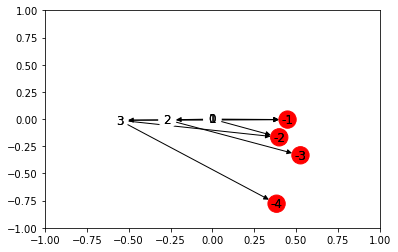

curcost 0.8300960563305637

200
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.26830980e-04 -1.79081705e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.49420759e-01 -4.64806366e-03 -9.99990003e+04 -1.12744357e+05]
 [ 3.99843456e-01 -1.67807117e-01 -9.99990003e+04 -1.08325742e+05]
 [-2.68557692e-01 -6.77387719e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.26470658e-01 -3.33136668e-01 -9.99987750e+04 -2.08159062e+05]
 [-5.54478194e-01 -1.07397689e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.83728454e-01 -7.78496812e-01 -9.99986756e+04 -3.12239009e+05]]


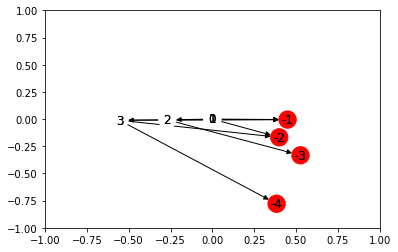

curcost 0.8300624525678302

201
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.26740248e-04 -1.79010072e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.49690411e-01 -4.65085249e-03 -9.99990003e+04 -1.12812003e+05]
 [ 4.00003393e-01 -1.67874240e-01 -9.99990003e+04 -1.08369073e+05]
 [-2.68450269e-01 -6.77116764e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.26575952e-01 -3.33203296e-01 -9.99987750e+04 -2.08200694e+05]
 [-5.54256403e-01 -1.07354730e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.83805200e-01 -7.78652511e-01 -9.99986756e+04 -3.12301457e+05]]


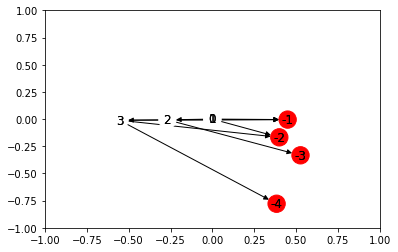

curcost 0.830029172602801

202
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.26649552e-04 -1.78938468e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.49960226e-01 -4.65364301e-03 -9.99990003e+04 -1.12879691e+05]
 [ 4.00163394e-01 -1.67941390e-01 -9.99990003e+04 -1.08412420e+05]
 [-2.68342889e-01 -6.76845917e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.26681267e-01 -3.33269936e-01 -9.99987750e+04 -2.08242334e+05]
 [-5.54034700e-01 -1.07311788e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.83881961e-01 -7.78808242e-01 -9.99986756e+04 -3.12363917e+05]]


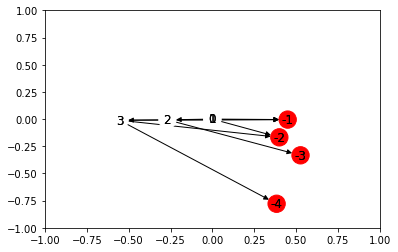

curcost 0.8299962166801362

203
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.26558892e-04 -1.78866893e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.50230202e-01 -4.65643519e-03 -9.99990003e+04 -1.12947418e+05]
 [ 4.00323460e-01 -1.68008567e-01 -9.99990003e+04 -1.08455785e+05]
 [-2.68235552e-01 -6.76575179e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.26786603e-01 -3.33336590e-01 -9.99987750e+04 -2.08283982e+05]
 [-5.53813086e-01 -1.07268864e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.83958737e-01 -7.78964004e-01 -9.99986756e+04 -3.12426390e+05]]


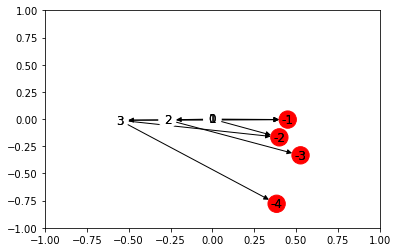

curcost 0.829963585045005

204
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.26468268e-04 -1.78795346e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.50500340e-01 -4.65922905e-03 -9.99990003e+04 -1.13015187e+05]
 [ 4.00483589e-01 -1.68075770e-01 -9.99990003e+04 -1.08499168e+05]
 [-2.68128258e-01 -6.76304549e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.26891961e-01 -3.33403258e-01 -9.99987750e+04 -2.08325639e+05]
 [-5.53591561e-01 -1.07225956e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.84035529e-01 -7.79119796e-01 -9.99986756e+04 -3.12488875e+05]]


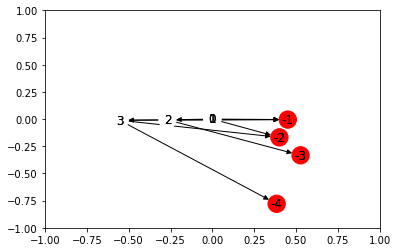

curcost 0.8299312779430847

205
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.26377681e-04 -1.78723828e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.50770640e-01 -4.66202459e-03 -9.99990003e+04 -1.13082996e+05]
 [ 4.00643783e-01 -1.68143000e-01 -9.99990003e+04 -1.08542567e+05]
 [-2.68021006e-01 -6.76034027e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.26997339e-01 -3.33469938e-01 -9.99987750e+04 -2.08367304e+05]
 [-5.53370124e-01 -1.07183066e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.84112336e-01 -7.79275620e-01 -9.99986756e+04 -3.12551373e+05]]


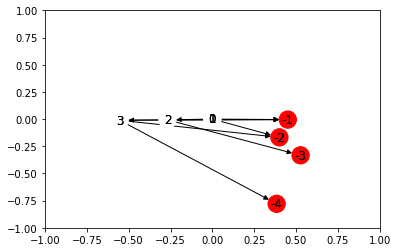

curcost 0.8298992956205621

206
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.26287130e-04 -1.78652339e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.51041103e-01 -4.66482181e-03 -9.99990003e+04 -1.13150846e+05]
 [ 4.00804040e-01 -1.68210257e-01 -9.99990003e+04 -1.08585984e+05]
 [-2.67913798e-01 -6.75763613e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.27102738e-01 -3.33536632e-01 -9.99987750e+04 -2.08408978e+05]
 [-5.53148776e-01 -1.07140193e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.84189159e-01 -7.79431476e-01 -9.99986756e+04 -3.12613883e+05]]


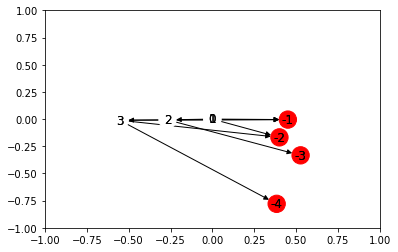

curcost 0.8298676383241332

207
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.26196615e-04 -1.78580878e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.51311727e-01 -4.66762070e-03 -9.99990003e+04 -1.13218736e+05]
 [ 4.00964362e-01 -1.68277542e-01 -9.99990003e+04 -1.08629419e+05]
 [-2.67806632e-01 -6.75493308e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.27208159e-01 -3.33603340e-01 -9.99987750e+04 -2.08450660e+05]
 [-5.52927517e-01 -1.07097336e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.84265997e-01 -7.79587362e-01 -9.99986756e+04 -3.12676406e+05]]


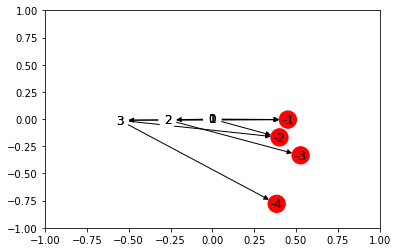

curcost 0.8298363063010039

208
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.26106136e-04 -1.78509445e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.51582514e-01 -4.67042127e-03 -9.99990003e+04 -1.13286667e+05]
 [ 4.01124747e-01 -1.68344853e-01 -9.99990003e+04 -1.08672870e+05]
 [-2.67699510e-01 -6.75223111e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.27313601e-01 -3.33670060e-01 -9.99987750e+04 -2.08492350e+05]
 [-5.52706346e-01 -1.07054498e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.84342850e-01 -7.79743279e-01 -9.99986756e+04 -3.12738941e+05]]


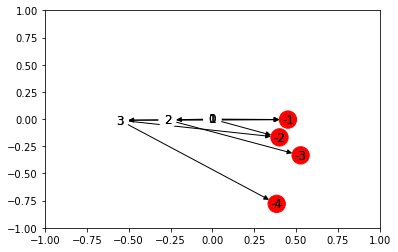

curcost 0.8298052997988891

209
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.26015694e-04 -1.78438042e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.51853464e-01 -4.67322352e-03 -9.99990003e+04 -1.13354639e+05]
 [ 4.01285197e-01 -1.68412191e-01 -9.99990003e+04 -1.08716340e+05]
 [-2.67592430e-01 -6.74953021e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.27419063e-01 -3.33736794e-01 -9.99987750e+04 -2.08534048e+05]
 [-5.52485263e-01 -1.07011676e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.84419718e-01 -7.79899228e-01 -9.99986756e+04 -3.12801489e+05]]


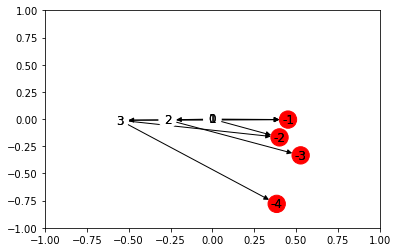

curcost 0.8297746190660146

210
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.25925288e-04 -1.78366666e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.52124576e-01 -4.67602746e-03 -9.99990003e+04 -1.13422652e+05]
 [ 4.01445711e-01 -1.68479555e-01 -9.99990003e+04 -1.08759826e+05]
 [-2.67485393e-01 -6.74683040e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.27524547e-01 -3.33803542e-01 -9.99987750e+04 -2.08575755e+05]
 [-5.52264269e-01 -1.06968871e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.84496602e-01 -7.80055208e-01 -9.99986756e+04 -3.12864049e+05]]


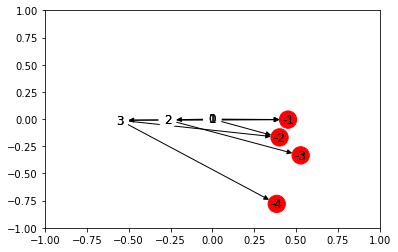

curcost 0.8297442643511158

211
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.25834918e-04 -1.78295320e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.52395851e-01 -4.67883307e-03 -9.99990003e+04 -1.13490706e+05]
 [ 4.01606290e-01 -1.68546947e-01 -9.99990003e+04 -1.08803330e+05]
 [-2.67378399e-01 -6.74413167e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.27630052e-01 -3.33870302e-01 -9.99987750e+04 -2.08617470e+05]
 [-5.52043363e-01 -1.06926084e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.84573502e-01 -7.80211219e-01 -9.99986756e+04 -3.12926622e+05]]


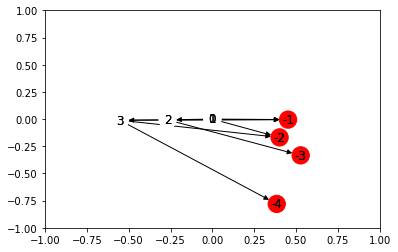

curcost 0.829714235903439

212
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.25744584e-04 -1.78224002e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.52667288e-01 -4.68164037e-03 -9.99990003e+04 -1.13558800e+05]
 [ 4.01766932e-01 -1.68614366e-01 -9.99990003e+04 -1.08846851e+05]
 [-2.67271448e-01 -6.74143402e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.27735578e-01 -3.33937077e-01 -9.99987750e+04 -2.08659194e+05]
 [-5.51822546e-01 -1.06883313e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.84650416e-01 -7.80367261e-01 -9.99986756e+04 -3.12989207e+05]]


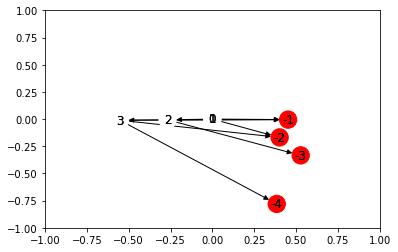

curcost 0.829684533972741

213
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.25654286e-04 -1.78152712e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.52938888e-01 -4.68444936e-03 -9.99990003e+04 -1.13626936e+05]
 [ 4.01927639e-01 -1.68681812e-01 -9.99990003e+04 -1.08890390e+05]
 [-2.67164539e-01 -6.73873744e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.27841125e-01 -3.34003864e-01 -9.99987750e+04 -2.08700925e+05]
 [-5.51601817e-01 -1.06840560e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.84727346e-01 -7.80523335e-01 -9.99986756e+04 -3.13051805e+05]]


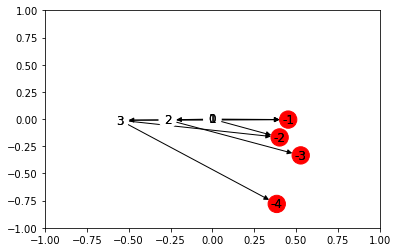

curcost 0.8296551588092902

214
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.25564024e-04 -1.78081451e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.53210652e-01 -4.68726003e-03 -9.99990003e+04 -1.13695112e+05]
 [ 4.02088410e-01 -1.68749284e-01 -9.99990003e+04 -1.08933946e+05]
 [-2.67057673e-01 -6.73604195e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.27946693e-01 -3.34070665e-01 -9.99987750e+04 -2.08742666e+05]
 [-5.51381176e-01 -1.06797824e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.84804292e-01 -7.80679439e-01 -9.99986756e+04 -3.13114416e+05]]


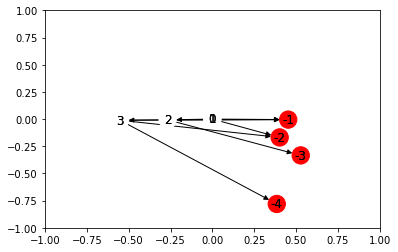

curcost 0.8296261106638653

215
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.25473798e-04 -1.78010218e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.53482578e-01 -4.69007238e-03 -9.99990003e+04 -1.13763329e+05]
 [ 4.02249245e-01 -1.68816784e-01 -9.99990003e+04 -1.08977520e+05]
 [-2.66950850e-01 -6.73334753e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.28052283e-01 -3.34137479e-01 -9.99987750e+04 -2.08784414e+05]
 [-5.51160624e-01 -1.06755104e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.84881253e-01 -7.80835575e-01 -9.99986756e+04 -3.13177038e+05]]


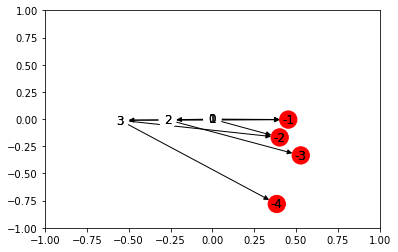

curcost 0.829597389787758

216
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.25383609e-04 -1.77939014e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.53754668e-01 -4.69288643e-03 -9.99990003e+04 -1.13831587e+05]
 [ 4.02410145e-01 -1.68884311e-01 -9.99990003e+04 -1.09021111e+05]
 [-2.66844070e-01 -6.73065419e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.28157893e-01 -3.34204306e-01 -9.99987750e+04 -2.08826171e+05]
 [-5.50940160e-01 -1.06712402e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.84958229e-01 -7.80991742e-01 -9.99986756e+04 -3.13239674e+05]]


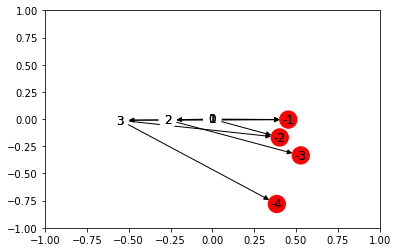

curcost 0.8295689964327705

217
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.25293455e-04 -1.77867839e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.54026921e-01 -4.69570216e-03 -9.99990003e+04 -1.13899886e+05]
 [ 4.02571109e-01 -1.68951865e-01 -9.99990003e+04 -1.09064719e+05]
 [-2.66737332e-01 -6.72796193e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.28263525e-01 -3.34271147e-01 -9.99987750e+04 -2.08867936e+05]
 [-5.50719784e-01 -1.06669717e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.85035221e-01 -7.81147941e-01 -9.99986756e+04 -3.13302322e+05]]


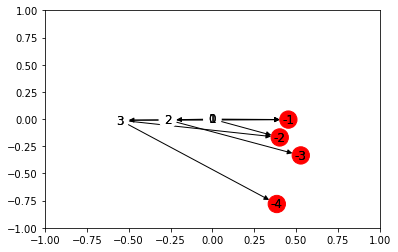

curcost 0.8295409308512179

218
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.25203338e-04 -1.77796691e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.54299337e-01 -4.69851958e-03 -9.99990003e+04 -1.13968226e+05]
 [ 4.02732138e-01 -1.69019445e-01 -9.99990003e+04 -1.09108345e+05]
 [-2.66630637e-01 -6.72527075e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.28369178e-01 -3.34338001e-01 -9.99987750e+04 -2.08909710e+05]
 [-5.50499496e-01 -1.06627050e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.85112228e-01 -7.81304170e-01 -9.99986756e+04 -3.13364982e+05]]


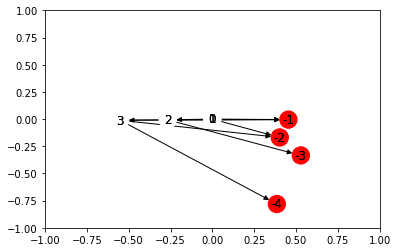

curcost 0.8295131932959272

219
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.25113257e-04 -1.77725573e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.54571916e-01 -4.70133869e-03 -9.99990003e+04 -1.14036607e+05]
 [ 4.02893230e-01 -1.69087053e-01 -9.99990003e+04 -1.09151989e+05]
 [-2.66523985e-01 -6.72258064e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.28474851e-01 -3.34404869e-01 -9.99987750e+04 -2.08951492e+05]
 [-5.50279296e-01 -1.06584399e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.85189250e-01 -7.81460431e-01 -9.99986756e+04 -3.13427655e+05]]


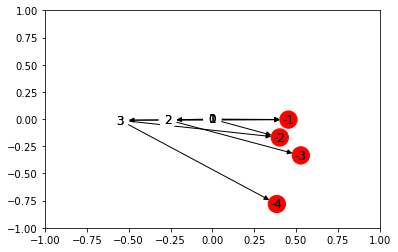

curcost 0.8294857840202388

220
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.25023211e-04 -1.77654483e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.54844659e-01 -4.70415950e-03 -9.99990003e+04 -1.14105029e+05]
 [ 4.03054388e-01 -1.69154688e-01 -9.99990003e+04 -1.09195649e+05]
 [-2.66417375e-01 -6.71989161e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.28580546e-01 -3.34471750e-01 -9.99987750e+04 -2.08993282e+05]
 [-5.50059184e-01 -1.06541765e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.85266288e-01 -7.81616723e-01 -9.99986756e+04 -3.13490341e+05]]


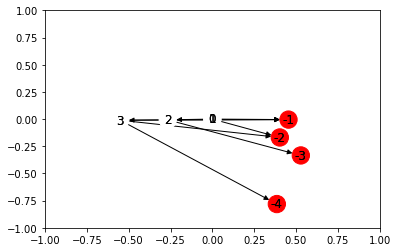

curcost 0.8294587032780056

221
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.24933202e-04 -1.77583421e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.55117566e-01 -4.70698199e-03 -9.99990003e+04 -1.14173492e+05]
 [ 4.03215610e-01 -1.69222350e-01 -9.99990003e+04 -1.09239328e+05]
 [-2.66310808e-01 -6.71720365e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.28686262e-01 -3.34538644e-01 -9.99987750e+04 -2.09035081e+05]
 [-5.49839160e-01 -1.06499148e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.85343341e-01 -7.81773046e-01 -9.99986756e+04 -3.13553039e+05]]


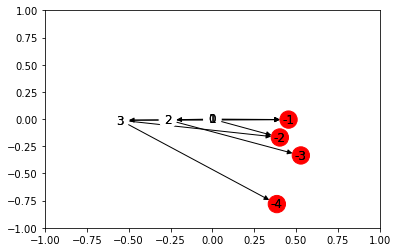

curcost 0.8294319513235938

222
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.24843229e-04 -1.77512387e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.55390637e-01 -4.70980618e-03 -9.99990003e+04 -1.14241996e+05]
 [ 4.03376896e-01 -1.69290039e-01 -9.99990003e+04 -1.09283023e+05]
 [-2.66204284e-01 -6.71451677e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.28792000e-01 -3.34605552e-01 -9.99987750e+04 -2.09076888e+05]
 [-5.49619225e-01 -1.06456549e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.85420410e-01 -7.81929401e-01 -9.99986756e+04 -3.13615749e+05]]


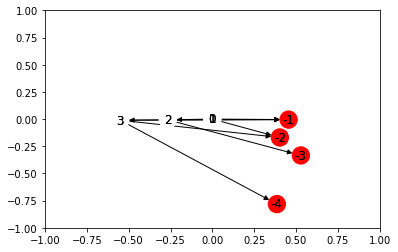

curcost 0.8294055284118835

223
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.24753292e-04 -1.77441382e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.55663871e-01 -4.71263206e-03 -9.99990003e+04 -1.14310541e+05]
 [ 4.03538247e-01 -1.69357755e-01 -9.99990003e+04 -1.09326737e+05]
 [-2.66097802e-01 -6.71183096e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.28897758e-01 -3.34672473e-01 -9.99987750e+04 -2.09118703e+05]
 [-5.49399377e-01 -1.06413966e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.85497494e-01 -7.82085787e-01 -9.99986756e+04 -3.13678473e+05]]


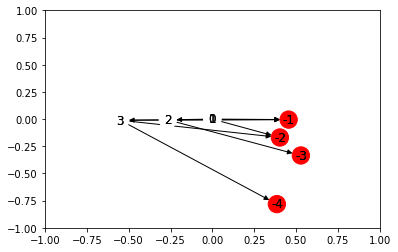

curcost 0.8293794347982685

224
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.24663390e-04 -1.77370406e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.55937269e-01 -4.71545964e-03 -9.99990003e+04 -1.14379127e+05]
 [ 4.03699662e-01 -1.69425498e-01 -9.99990003e+04 -1.09370467e+05]
 [-2.65991363e-01 -6.70914623e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.29003538e-01 -3.34739408e-01 -9.99987750e+04 -2.09160527e+05]
 [-5.49179617e-01 -1.06371400e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.85574594e-01 -7.82242204e-01 -9.99986756e+04 -3.13741208e+05]]


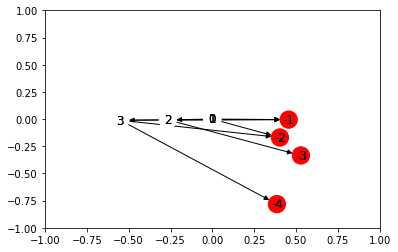

curcost 0.8293536707386567

225
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.24573525e-04 -1.77299458e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.56210832e-01 -4.71828892e-03 -9.99990003e+04 -1.14447755e+05]
 [ 4.03861142e-01 -1.69493268e-01 -9.99990003e+04 -1.09414215e+05]
 [-2.65884967e-01 -6.70646257e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.29109338e-01 -3.34806356e-01 -9.99987750e+04 -2.09202359e+05]
 [-5.48959946e-01 -1.06328852e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.85651708e-01 -7.82398652e-01 -9.99986756e+04 -3.13803956e+05]]


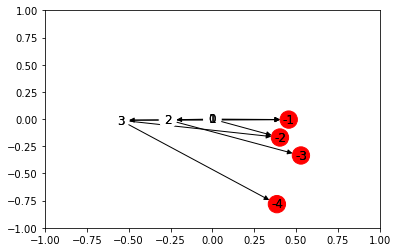

curcost 0.8293282364894712

226
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.24483696e-04 -1.77228538e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.56484558e-01 -4.72111989e-03 -9.99990003e+04 -1.14516423e+05]
 [ 4.04022686e-01 -1.69561065e-01 -9.99990003e+04 -1.09457981e+05]
 [-2.65778613e-01 -6.70377999e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.29215160e-01 -3.34873317e-01 -9.99987750e+04 -2.09244199e+05]
 [-5.48740362e-01 -1.06286320e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.85728839e-01 -7.82555132e-01 -9.99986756e+04 -3.13866717e+05]]


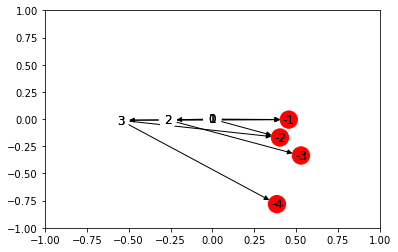

curcost 0.8293031323076488

227
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.24393902e-04 -1.77157646e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.56758449e-01 -4.72395256e-03 -9.99990003e+04 -1.14585133e+05]
 [ 4.04184295e-01 -1.69628890e-01 -9.99990003e+04 -1.09501764e+05]
 [-2.65672301e-01 -6.70109847e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.29321003e-01 -3.34940292e-01 -9.99987750e+04 -2.09286048e+05]
 [-5.48520865e-01 -1.06243806e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.85805985e-01 -7.82711643e-01 -9.99986756e+04 -3.13929491e+05]]


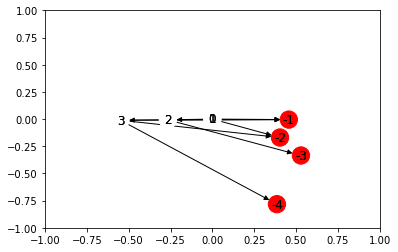

curcost 0.8292783584506429

228
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.24304144e-04 -1.77086783e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.57032504e-01 -4.72678694e-03 -9.99990003e+04 -1.14653884e+05]
 [ 4.04345969e-01 -1.69696741e-01 -9.99990003e+04 -1.09545565e+05]
 [-2.65566032e-01 -6.69841803e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.29426867e-01 -3.35007280e-01 -9.99987750e+04 -2.09327906e+05]
 [-5.48301457e-01 -1.06201308e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.85883146e-01 -7.82868186e-01 -9.99986756e+04 -3.13992277e+05]]


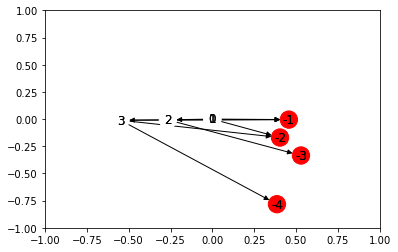

curcost 0.8292539151764212

229
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.24214423e-04 -1.77015949e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.57306724e-01 -4.72962301e-03 -9.99990003e+04 -1.14722677e+05]
 [ 4.04507707e-01 -1.69764620e-01 -9.99990003e+04 -1.09589383e+05]
 [-2.65459806e-01 -6.69573867e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.29532753e-01 -3.35074281e-01 -9.99987750e+04 -2.09369771e+05]
 [-5.48082136e-01 -1.06158828e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.85960322e-01 -7.83024759e-01 -9.99986756e+04 -3.14055075e+05]]


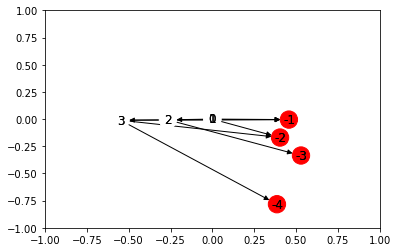

curcost 0.8292298027434684

230
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.24124737e-04 -1.76945142e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.57581108e-01 -4.73246078e-03 -9.99990003e+04 -1.14791510e+05]
 [ 4.04669510e-01 -1.69832526e-01 -9.99990003e+04 -1.09633219e+05]
 [-2.65353622e-01 -6.69306037e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.29638659e-01 -3.35141296e-01 -9.99987750e+04 -2.09411645e+05]
 [-5.47862904e-01 -1.06116364e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.86037514e-01 -7.83181364e-01 -9.99986756e+04 -3.14117886e+05]]


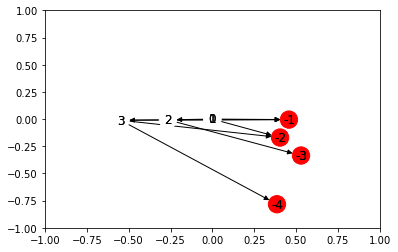

curcost 0.8292060214107843

231
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.24035087e-04 -1.76874364e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.57855656e-01 -4.73530026e-03 -9.99990003e+04 -1.14860385e+05]
 [ 4.04831378e-01 -1.69900459e-01 -9.99990003e+04 -1.09677072e+05]
 [-2.65247480e-01 -6.69038315e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.29744587e-01 -3.35208324e-01 -9.99987750e+04 -2.09453527e+05]
 [-5.47643758e-01 -1.06073918e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.86114722e-01 -7.83338000e-01 -9.99986756e+04 -3.14180710e+05]]


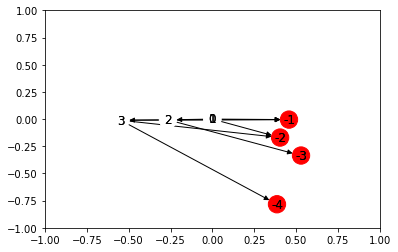

curcost 0.8291825714378859

232
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.23945473e-04 -1.76803615e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.58130370e-01 -4.73814144e-03 -9.99990003e+04 -1.14929301e+05]
 [ 4.04993311e-01 -1.69968419e-01 -9.99990003e+04 -1.09720943e+05]
 [-2.65141382e-01 -6.68770699e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.29850536e-01 -3.35275366e-01 -9.99987750e+04 -2.09495418e+05]
 [-5.47424701e-01 -1.06031488e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.86191945e-01 -7.83494668e-01 -9.99986756e+04 -3.14243546e+05]]


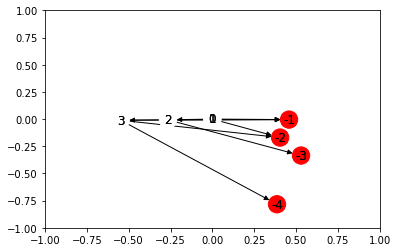

curcost 0.8291594530848074

233
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.23855895e-04 -1.76732893e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.58405248e-01 -4.74098432e-03 -9.99990003e+04 -1.14998259e+05]
 [ 4.05155308e-01 -1.70036407e-01 -9.99990003e+04 -1.09764831e+05]
 [-2.65035325e-01 -6.68503191e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.29956506e-01 -3.35342421e-01 -9.99987750e+04 -2.09537317e+05]
 [-5.47205731e-01 -1.05989075e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.86269183e-01 -7.83651367e-01 -9.99986756e+04 -3.14306394e+05]]


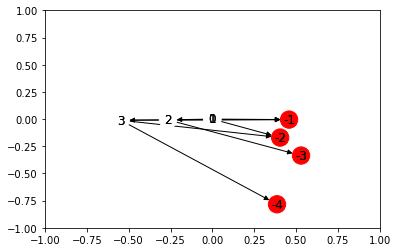

curcost 0.8291366666120996

234
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.23766353e-04 -1.76662200e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.58680291e-01 -4.74382891e-03 -9.99990003e+04 -1.15067258e+05]
 [ 4.05317370e-01 -1.70104421e-01 -9.99990003e+04 -1.09808737e+05]
 [-2.64929311e-01 -6.68235790e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.30062497e-01 -3.35409489e-01 -9.99987750e+04 -2.09579225e+05]
 [-5.46986849e-01 -1.05946680e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.86346437e-01 -7.83808097e-01 -9.99986756e+04 -3.14369256e+05]]


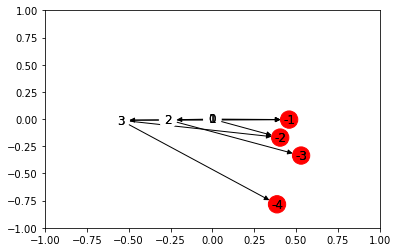

curcost 0.8291142122808317

235
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.23676846e-04 -1.76591535e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.58955499e-01 -4.74667521e-03 -9.99990003e+04 -1.15136298e+05]
 [ 4.05479497e-01 -1.70172463e-01 -9.99990003e+04 -1.09852661e+05]
 [-2.64823339e-01 -6.67968495e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.30168510e-01 -3.35476571e-01 -9.99987750e+04 -2.09621141e+05]
 [-5.46768054e-01 -1.05904301e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.86423706e-01 -7.83964859e-01 -9.99986756e+04 -3.14432130e+05]]


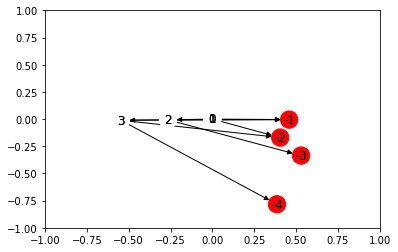

curcost 0.8290920903525902

236
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.23587375e-04 -1.76520898e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.59230873e-01 -4.74952322e-03 -9.99990003e+04 -1.15205380e+05]
 [ 4.05641689e-01 -1.70240532e-01 -9.99990003e+04 -1.09896602e+05]
 [-2.64717410e-01 -6.67701308e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.30274544e-01 -3.35543667e-01 -9.99987750e+04 -2.09663065e+05]
 [-5.46549347e-01 -1.05861939e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.86500991e-01 -7.84121652e-01 -9.99986756e+04 -3.14495016e+05]]


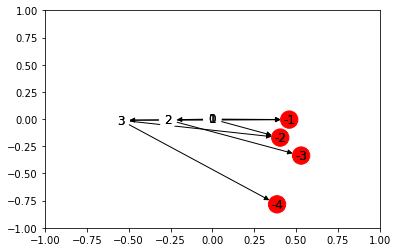

curcost 0.8290703010894807

237
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.23497940e-04 -1.76450290e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.59506411e-01 -4.75237293e-03 -9.99990003e+04 -1.15274503e+05]
 [ 4.05803946e-01 -1.70308628e-01 -9.99990003e+04 -1.09940561e+05]
 [-2.64611523e-01 -6.67434228e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.30380599e-01 -3.35610775e-01 -9.99987750e+04 -2.09704997e+05]
 [-5.46330727e-01 -1.05819595e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.86578291e-01 -7.84278476e-01 -9.99986756e+04 -3.14557915e+05]]


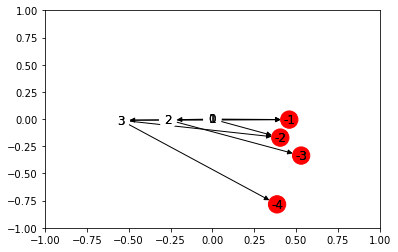

curcost 0.8290488447541269

238
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.23408541e-04 -1.76379710e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.59782115e-01 -4.75522435e-03 -9.99990003e+04 -1.15343668e+05]
 [ 4.05966267e-01 -1.70376751e-01 -9.99990003e+04 -1.09984537e+05]
 [-2.64505678e-01 -6.67167254e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.30486675e-01 -3.35677897e-01 -9.99987750e+04 -2.09746938e+05]
 [-5.46112195e-01 -1.05777267e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.86655607e-01 -7.84435332e-01 -9.99986756e+04 -3.14620827e+05]]


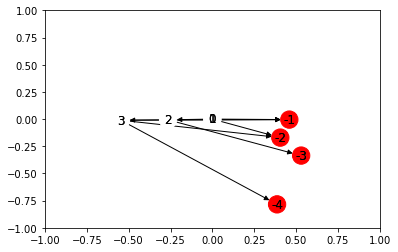

curcost 0.8290277216096719

239
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.23319178e-04 -1.76309158e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.60057984e-01 -4.75807749e-03 -9.99990003e+04 -1.15412874e+05]
 [ 4.06128654e-01 -1.70444902e-01 -9.99990003e+04 -1.10028531e+05]
 [-2.64399876e-01 -6.66900387e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.30592772e-01 -3.35745033e-01 -9.99987750e+04 -2.09788888e+05]
 [-5.45893750e-01 -1.05734956e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.86732938e-01 -7.84592219e-01 -9.99986756e+04 -3.14683751e+05]]


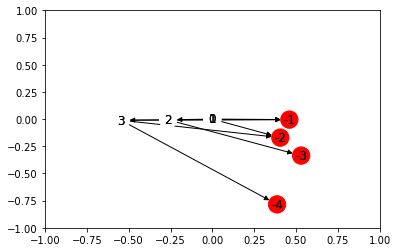

curcost 0.8290069319197789

240
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.23229850e-04 -1.76238634e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.60334019e-01 -4.76093234e-03 -9.99990003e+04 -1.15482122e+05]
 [ 4.06291105e-01 -1.70513080e-01 -9.99990003e+04 -1.10072542e+05]
 [-2.64294116e-01 -6.66633627e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.30698891e-01 -3.35812182e-01 -9.99987750e+04 -2.09830846e+05]
 [-5.45675392e-01 -1.05692662e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.86810285e-01 -7.84749137e-01 -9.99986756e+04 -3.14746687e+05]]


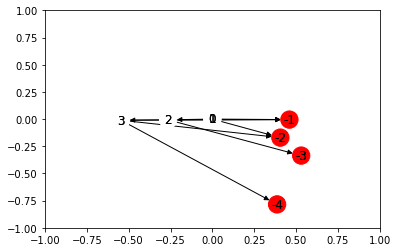

curcost 0.8289864759486304

241
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.23140558e-04 -1.76168139e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.60610219e-01 -4.76378889e-03 -9.99990003e+04 -1.15551411e+05]
 [ 4.06453622e-01 -1.70581285e-01 -9.99990003e+04 -1.10116571e+05]
 [-2.64188398e-01 -6.66366973e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.30805030e-01 -3.35879345e-01 -9.99987750e+04 -2.09872812e+05]
 [-5.45457122e-01 -1.05650385e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.86887647e-01 -7.84906087e-01 -9.99986756e+04 -3.14809637e+05]]


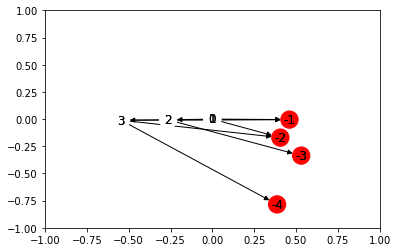

curcost 0.8289663539609297

242
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.23051302e-04 -1.76097672e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.60886586e-01 -4.76664717e-03 -9.99990003e+04 -1.15620742e+05]
 [ 4.06616203e-01 -1.70649518e-01 -9.99990003e+04 -1.10160618e+05]
 [-2.64082723e-01 -6.66100427e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.30911191e-01 -3.35946520e-01 -9.99987750e+04 -2.09914786e+05]
 [-5.45238939e-01 -1.05608125e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.86965024e-01 -7.85063068e-01 -9.99986756e+04 -3.14872599e+05]]


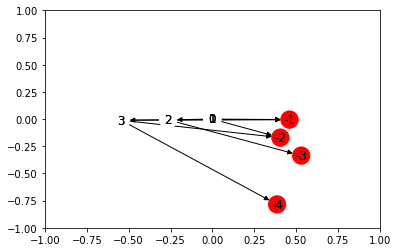

curcost 0.8289465662219007

243
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.22962081e-04 -1.76027233e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.61163118e-01 -4.76950716e-03 -9.99990003e+04 -1.15690114e+05]
 [ 4.06778850e-01 -1.70717778e-01 -9.99990003e+04 -1.10204682e+05]
 [-2.63977090e-01 -6.65833986e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.31017374e-01 -3.36013710e-01 -9.99987750e+04 -2.09956769e+05]
 [-5.45020844e-01 -1.05565881e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.87042417e-01 -7.85220081e-01 -9.99986756e+04 -3.14935573e+05]]


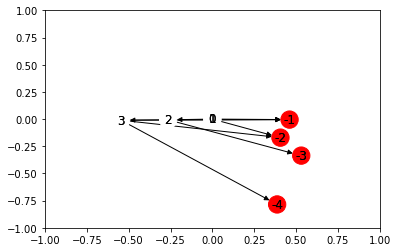

curcost 0.8289271129972883

244
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.22872897e-04 -1.75956822e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.61439815e-01 -4.77236886e-03 -9.99990003e+04 -1.15759529e+05]
 [ 4.06941561e-01 -1.70786065e-01 -9.99990003e+04 -1.10248764e+05]
 [-2.63871499e-01 -6.65567653e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.31123577e-01 -3.36080912e-01 -9.99987750e+04 -2.09998761e+05]
 [-5.44802835e-01 -1.05523655e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.87119826e-01 -7.85377125e-01 -9.99986756e+04 -3.14998560e+05]]


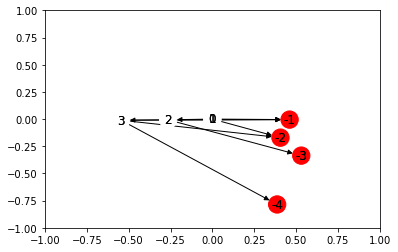

curcost 0.8289079945533591

245
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.22783747e-04 -1.75886439e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.61716679e-01 -4.77523228e-03 -9.99990003e+04 -1.15828984e+05]
 [ 4.07104338e-01 -1.70854379e-01 -9.99990003e+04 -1.10292863e+05]
 [-2.63765950e-01 -6.65301426e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.31229802e-01 -3.36148129e-01 -9.99987750e+04 -2.10040760e+05]
 [-5.44584914e-01 -1.05481446e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.87197250e-01 -7.85534200e-01 -9.99986756e+04 -3.15061560e+05]]


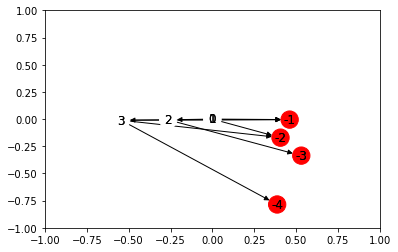

curcost 0.828889211156902

246
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.22694634e-04 -1.75816084e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.61993709e-01 -4.77809742e-03 -9.99990003e+04 -1.15898482e+05]
 [ 4.07267179e-01 -1.70922721e-01 -9.99990003e+04 -1.10336980e+05]
 [-2.63660444e-01 -6.65035305e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.31336048e-01 -3.36215358e-01 -9.99987750e+04 -2.10082768e+05]
 [-5.44367080e-01 -1.05439253e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.87274689e-01 -7.85691307e-01 -9.99986756e+04 -3.15124572e+05]]


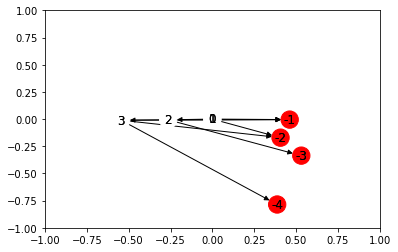

curcost 0.8288707630752284

247
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.22605556e-04 -1.75745758e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.62270906e-01 -4.78096428e-03 -9.99990003e+04 -1.15968021e+05]
 [ 4.07430086e-01 -1.70991090e-01 -9.99990003e+04 -1.10381115e+05]
 [-2.63554980e-01 -6.64769291e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.31442315e-01 -3.36282601e-01 -9.99987750e+04 -2.10124785e+05]
 [-5.44149334e-01 -1.05397077e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.87352144e-01 -7.85848446e-01 -9.99986756e+04 -3.15187597e+05]]


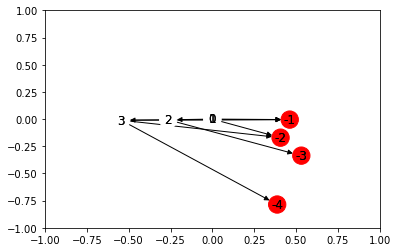

curcost 0.8288526505761725

248
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.22516514e-04 -1.75675460e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.62548268e-01 -4.78383286e-03 -9.99990003e+04 -1.16037602e+05]
 [ 4.07593058e-01 -1.71059487e-01 -9.99990003e+04 -1.10425268e+05]
 [-2.63449558e-01 -6.64503383e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.31548603e-01 -3.36349858e-01 -9.99987750e+04 -2.10166810e+05]
 [-5.43931674e-01 -1.05354919e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.87429615e-01 -7.86005615e-01 -9.99986756e+04 -3.15250635e+05]]


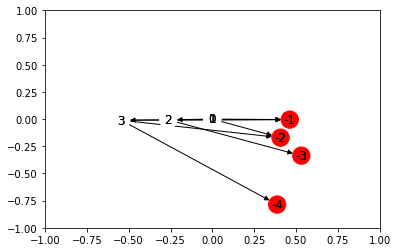

curcost 0.8288348739280916

249
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.22427507e-04 -1.75605190e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.62825797e-01 -4.78670316e-03 -9.99990003e+04 -1.16107224e+05]
 [ 4.07756096e-01 -1.71127910e-01 -9.99990003e+04 -1.10469438e+05]
 [-2.63344178e-01 -6.64237582e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.31654913e-01 -3.36417128e-01 -9.99987750e+04 -2.10208843e+05]
 [-5.43714101e-01 -1.05312777e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.87507101e-01 -7.86162816e-01 -9.99986756e+04 -3.15313685e+05]]


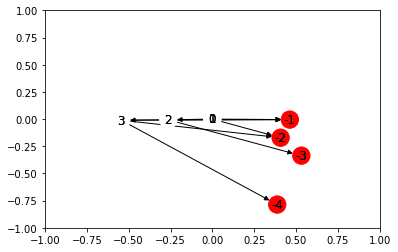

curcost 0.8288174333998669

250
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.22338536e-04 -1.75534947e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.63103493e-01 -4.78957518e-03 -9.99990003e+04 -1.16176888e+05]
 [ 4.07919198e-01 -1.71196361e-01 -9.99990003e+04 -1.10513626e+05]
 [-2.63238840e-01 -6.63971887e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.31761244e-01 -3.36484411e-01 -9.99987750e+04 -2.10250885e+05]
 [-5.43496616e-01 -1.05270651e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.87584602e-01 -7.86320049e-01 -9.99986756e+04 -3.15376748e+05]]


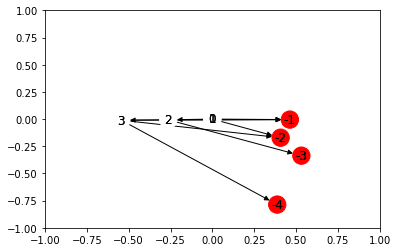

curcost 0.8288003292609042

251
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.22249601e-04 -1.75464733e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.63381355e-01 -4.79244892e-03 -9.99990003e+04 -1.16246595e+05]
 [ 4.08082366e-01 -1.71264840e-01 -9.99990003e+04 -1.10557831e+05]
 [-2.63133545e-01 -6.63706298e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.31867596e-01 -3.36551708e-01 -9.99987750e+04 -2.10292935e+05]
 [-5.43279217e-01 -1.05228543e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.87662119e-01 -7.86477313e-01 -9.99986756e+04 -3.15439823e+05]]


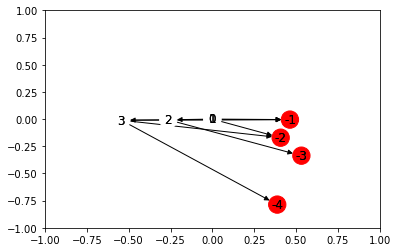

curcost 0.8287835617811338

252
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.22160701e-04 -1.75394548e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.63659383e-01 -4.79532439e-03 -9.99990003e+04 -1.16316343e+05]
 [ 4.08245599e-01 -1.71333346e-01 -9.99990003e+04 -1.10602054e+05]
 [-2.63028291e-01 -6.63440816e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.31973970e-01 -3.36619018e-01 -9.99987750e+04 -2.10334994e+05]
 [-5.43061905e-01 -1.05186452e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.87739651e-01 -7.86634608e-01 -9.99986756e+04 -3.15502911e+05]]


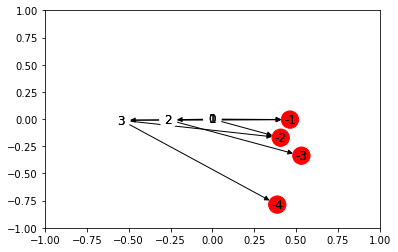

curcost 0.8287671312310108

253
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.22071837e-04 -1.75324390e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.63937579e-01 -4.79820159e-03 -9.99990003e+04 -1.16386132e+05]
 [ 4.08408897e-01 -1.71401879e-01 -9.99990003e+04 -1.10646295e+05]
 [-2.62923080e-01 -6.63175439e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.32080365e-01 -3.36686342e-01 -9.99987750e+04 -2.10377061e+05]
 [-5.42844680e-01 -1.05144377e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.87817199e-01 -7.86791935e-01 -9.99986756e+04 -3.15566012e+05]]


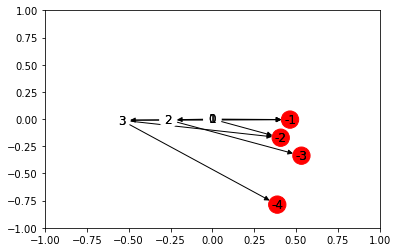

curcost 0.8287510378815168

254
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.21983008e-04 -1.75254260e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.64215942e-01 -4.80108051e-03 -9.99990003e+04 -1.16455964e+05]
 [ 4.08572260e-01 -1.71470440e-01 -9.99990003e+04 -1.10690554e+05]
 [-2.62817911e-01 -6.62910169e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.32186781e-01 -3.36753680e-01 -9.99987750e+04 -2.10419136e+05]
 [-5.42627543e-01 -1.05102319e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.87894763e-01 -7.86949294e-01 -9.99986756e+04 -3.15629125e+05]]


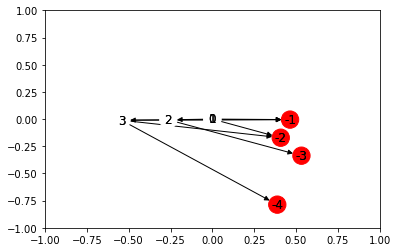

curcost 0.8287352820041588

255
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.21894215e-04 -1.75184158e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.64494471e-01 -4.80396116e-03 -9.99990003e+04 -1.16525838e+05]
 [ 4.08735689e-01 -1.71539028e-01 -9.99990003e+04 -1.10734830e+05]
 [-2.62712784e-01 -6.62645005e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.32293218e-01 -3.36821030e-01 -9.99987750e+04 -2.10461220e+05]
 [-5.42410492e-01 -1.05060279e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.87972342e-01 -7.87106684e-01 -9.99986756e+04 -3.15692251e+05]]


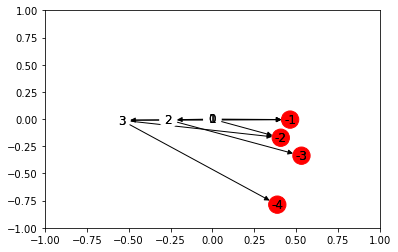

curcost 0.8287198638709707

256
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.21805457e-04 -1.75114085e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.64773168e-01 -4.80684353e-03 -9.99990003e+04 -1.16595753e+05]
 [ 4.08899184e-01 -1.71607644e-01 -9.99990003e+04 -1.10779124e+05]
 [-2.62607699e-01 -6.62379947e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.32399677e-01 -3.36888394e-01 -9.99987750e+04 -2.10503312e+05]
 [-5.42193527e-01 -1.05018254e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.88049936e-01 -7.87264105e-01 -9.99986756e+04 -3.15755389e+05]]


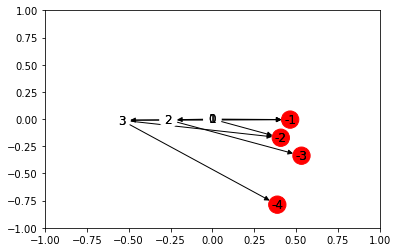

curcost 0.8287047837545138

257
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.21716735e-04 -1.75044039e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.65052032e-01 -4.80972764e-03 -9.99990003e+04 -1.16665711e+05]
 [ 4.09062743e-01 -1.71676287e-01 -9.99990003e+04 -1.10823435e+05]
 [-2.62502656e-01 -6.62114995e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.32506157e-01 -3.36955772e-01 -9.99987750e+04 -2.10545413e+05]
 [-5.41976650e-01 -1.04976247e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.88127546e-01 -7.87421558e-01 -9.99986756e+04 -3.15818540e+05]]


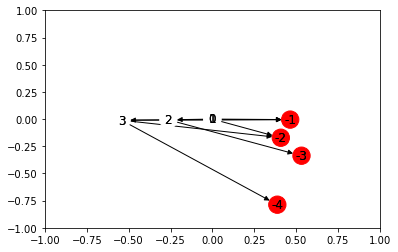

curcost 0.8286900419278761

258
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.21628048e-04 -1.74974021e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.65331063e-01 -4.81261348e-03 -9.99990003e+04 -1.16735710e+05]
 [ 4.09226368e-01 -1.71744957e-01 -9.99990003e+04 -1.10867765e+05]
 [-2.62397654e-01 -6.61850149e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.32612658e-01 -3.37023163e-01 -9.99987750e+04 -2.10587522e+05]
 [-5.41759859e-01 -1.04934257e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.88205172e-01 -7.87579042e-01 -9.99986756e+04 -3.15881704e+05]]


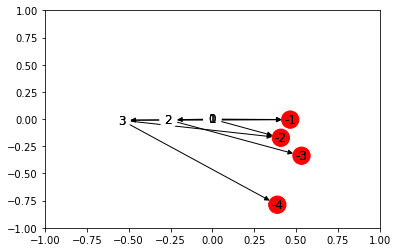

curcost 0.828675638664675

259
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.21539397e-04 -1.74904032e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.65610262e-01 -4.81550105e-03 -9.99990003e+04 -1.16805751e+05]
 [ 4.09390059e-01 -1.71813655e-01 -9.99990003e+04 -1.10912112e+05]
 [-2.62292695e-01 -6.61585409e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.32719180e-01 -3.37090568e-01 -9.99987750e+04 -2.10629640e+05]
 [-5.41543155e-01 -1.04892283e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.88282813e-01 -7.87736558e-01 -9.99986756e+04 -3.15944880e+05]]


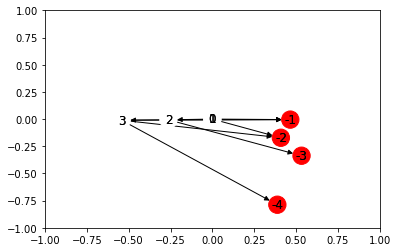

curcost 0.8286615742390554

260
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.21450781e-04 -1.74834070e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.65889628e-01 -4.81839035e-03 -9.99990003e+04 -1.16875835e+05]
 [ 4.09553815e-01 -1.71882381e-01 -9.99990003e+04 -1.10956477e+05]
 [-2.62187778e-01 -6.61320775e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.32825724e-01 -3.37157986e-01 -9.99987750e+04 -2.10671766e+05]
 [-5.41326538e-01 -1.04850326e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.88360469e-01 -7.87894105e-01 -9.99986756e+04 -3.16008069e+05]]


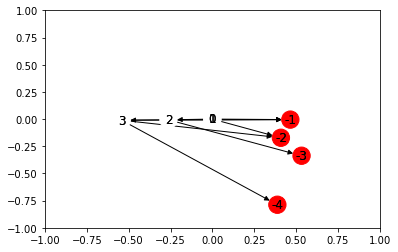

curcost 0.8286478489256918

261
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.21362201e-04 -1.74764137e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.66169162e-01 -4.82128138e-03 -9.99990003e+04 -1.16945960e+05]
 [ 4.09717636e-01 -1.71951134e-01 -9.99990003e+04 -1.11000859e+05]
 [-2.62082903e-01 -6.61056247e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.32932289e-01 -3.37225418e-01 -9.99987750e+04 -2.10713900e+05]
 [-5.41110007e-01 -1.04808386e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.88438141e-01 -7.88051684e-01 -9.99986756e+04 -3.16071271e+05]]


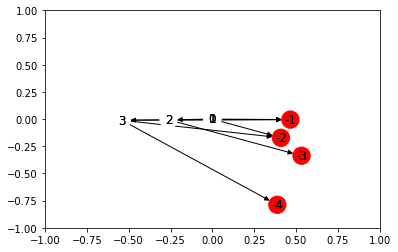

curcost 0.8286344629997884

262
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.21273656e-04 -1.74694231e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.66448863e-01 -4.82417415e-03 -9.99990003e+04 -1.17016128e+05]
 [ 4.09881524e-01 -1.72019914e-01 -9.99990003e+04 -1.11045260e+05]
 [-2.61978070e-01 -6.60791824e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.33038876e-01 -3.37292863e-01 -9.99987750e+04 -2.10756043e+05]
 [-5.40893563e-01 -1.04766463e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.88515829e-01 -7.88209294e-01 -9.99986756e+04 -3.16134485e+05]]


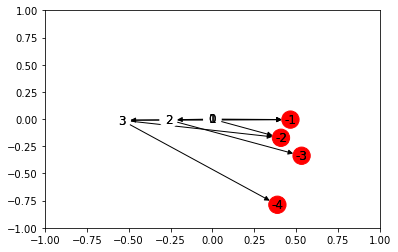

curcost 0.8286214167370798

263
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.21185147e-04 -1.74624353e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.66728732e-01 -4.82706865e-03 -9.99990003e+04 -1.17086338e+05]
 [ 4.10045476e-01 -1.72088722e-01 -9.99990003e+04 -1.11089678e+05]
 [-2.61873279e-01 -6.60527507e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.33145484e-01 -3.37360321e-01 -9.99987750e+04 -2.10798194e+05]
 [-5.40677206e-01 -1.04724556e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.88593532e-01 -7.88366936e-01 -9.99986756e+04 -3.16197712e+05]]


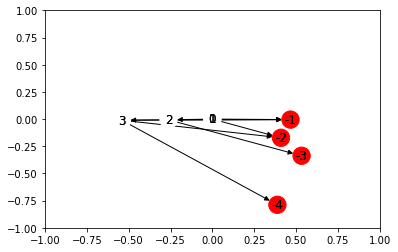

curcost 0.8286087104138306

264
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.21096672e-04 -1.74554503e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.67008770e-01 -4.82996489e-03 -9.99990003e+04 -1.17156589e+05]
 [ 4.10209494e-01 -1.72157558e-01 -9.99990003e+04 -1.11134114e+05]
 [-2.61768530e-01 -6.60263296e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.33252113e-01 -3.37427793e-01 -9.99987750e+04 -2.10840354e+05]
 [-5.40460935e-01 -1.04682666e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.88671251e-01 -7.88524610e-01 -9.99986756e+04 -3.16260951e+05]]


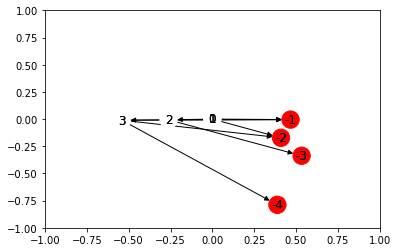

curcost 0.8285963443068368

265
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.21008234e-04 -1.74484682e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.67288975e-01 -4.83286287e-03 -9.99990003e+04 -1.17226883e+05]
 [ 4.10373578e-01 -1.72226421e-01 -9.99990003e+04 -1.11178567e+05]
 [-2.61663822e-01 -6.59999191e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.33358763e-01 -3.37495279e-01 -9.99987750e+04 -2.10882522e+05]
 [-5.40244751e-01 -1.04640793e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.88748985e-01 -7.88682315e-01 -9.99986756e+04 -3.16324204e+05]]


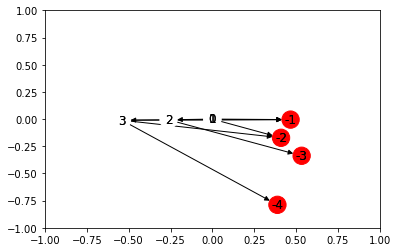

curcost 0.8285843186934272

266
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.20919831e-04 -1.74414888e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.67569348e-01 -4.83576259e-03 -9.99990003e+04 -1.17297219e+05]
 [ 4.10537728e-01 -1.72295311e-01 -9.99990003e+04 -1.11223039e+05]
 [-2.61559157e-01 -6.59735191e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.33465435e-01 -3.37562778e-01 -9.99987750e+04 -2.10924698e+05]
 [-5.40028653e-01 -1.04598937e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.88826735e-01 -7.88840051e-01 -9.99986756e+04 -3.16387469e+05]]


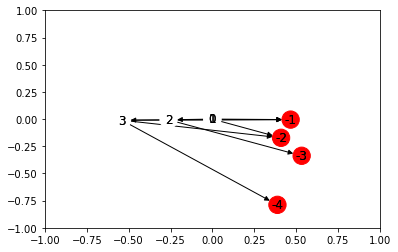

curcost 0.8285726338514618

267
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.20831463e-04 -1.74345122e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.67849890e-01 -4.83866405e-03 -9.99990003e+04 -1.17367598e+05]
 [ 4.10701943e-01 -1.72364229e-01 -9.99990003e+04 -1.11267528e+05]
 [-2.61454533e-01 -6.59471297e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.33572128e-01 -3.37630291e-01 -9.99987750e+04 -2.10966883e+05]
 [-5.39812641e-01 -1.04557097e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.88904500e-01 -7.88997819e-01 -9.99986756e+04 -3.16450746e+05]]


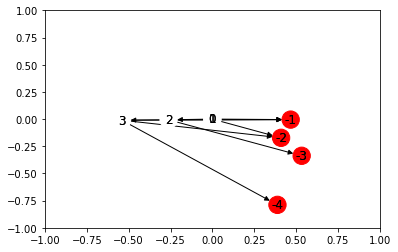

curcost 0.8285612900593339

268
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.20743130e-04 -1.74275384e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.68130600e-01 -4.84156725e-03 -9.99990003e+04 -1.17438018e+05]
 [ 4.10866223e-01 -1.72433175e-01 -9.99990003e+04 -1.11312035e+05]
 [-2.61349951e-01 -6.59207509e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.33678842e-01 -3.37697817e-01 -9.99987750e+04 -2.11009076e+05]
 [-5.39596716e-01 -1.04515274e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.88982281e-01 -7.89155619e-01 -9.99986756e+04 -3.16514036e+05]]


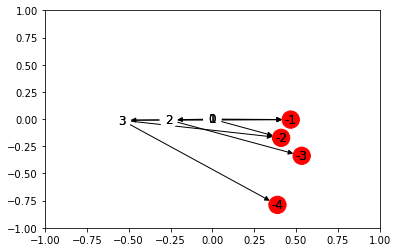

curcost 0.8285502875959705

269
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.20654833e-04 -1.74205674e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.68411478e-01 -4.84447219e-03 -9.99990003e+04 -1.17508481e+05]
 [ 4.11030570e-01 -1.72502148e-01 -9.99990003e+04 -1.11356560e+05]
 [-2.61245411e-01 -6.58943826e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.33785578e-01 -3.37765356e-01 -9.99987750e+04 -2.11051278e+05]
 [-5.39380878e-01 -1.04473468e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.89060077e-01 -7.89313450e-01 -9.99986756e+04 -3.16577339e+05]]


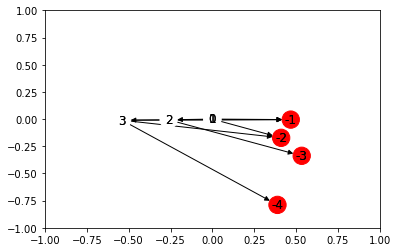

curcost 0.8285396267408321

270
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.20566571e-04 -1.74135991e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.68692525e-01 -4.84737887e-03 -9.99990003e+04 -1.17578986e+05]
 [ 4.11194982e-01 -1.72571149e-01 -9.99990003e+04 -1.11401102e+05]
 [-2.61140913e-01 -6.58680248e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.33892335e-01 -3.37832909e-01 -9.99987750e+04 -2.11093488e+05]
 [-5.39165125e-01 -1.04431679e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.89137890e-01 -7.89471312e-01 -9.99986756e+04 -3.16640654e+05]]


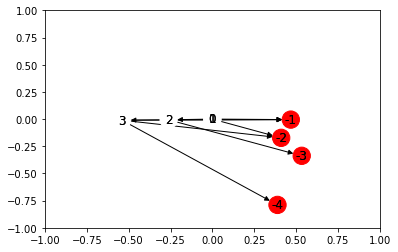

curcost 0.8285293077739144

271
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.20478344e-04 -1.74066337e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.68973741e-01 -4.85028730e-03 -9.99990003e+04 -1.17649534e+05]
 [ 4.11359460e-01 -1.72640178e-01 -9.99990003e+04 -1.11445663e+05]
 [-2.61036457e-01 -6.58416776e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.33999114e-01 -3.37900476e-01 -9.99987750e+04 -2.11135707e+05]
 [-5.38949459e-01 -1.04389906e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.89215717e-01 -7.89629207e-01 -9.99986756e+04 -3.16703983e+05]]


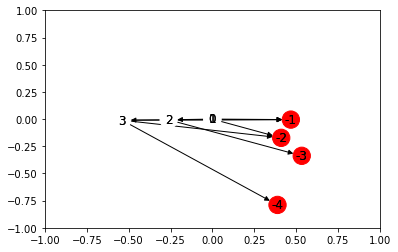

curcost 0.8285193309757483

272
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.20390153e-04 -1.73996710e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.69255125e-01 -4.85319747e-03 -9.99990003e+04 -1.17720123e+05]
 [ 4.11524004e-01 -1.72709234e-01 -9.99990003e+04 -1.11490241e+05]
 [-2.60932042e-01 -6.58153409e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.34105914e-01 -3.37968056e-01 -9.99987750e+04 -2.11177934e+05]
 [-5.38733879e-01 -1.04348150e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.89293560e-01 -7.89787132e-01 -9.99986756e+04 -3.16767323e+05]]


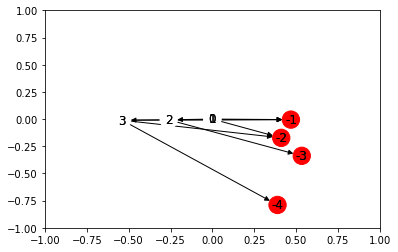

curcost 0.8285096966273995

273
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.20301997e-04 -1.73927112e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.69536678e-01 -4.85610939e-03 -9.99990003e+04 -1.17790755e+05]
 [ 4.11688614e-01 -1.72778317e-01 -9.99990003e+04 -1.11534837e+05]
 [-2.60827669e-01 -6.57890148e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.34212735e-01 -3.38035650e-01 -9.99987750e+04 -2.11220170e+05]
 [-5.38518386e-01 -1.04306411e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.89371419e-01 -7.89945090e-01 -9.99986756e+04 -3.16830677e+05]]


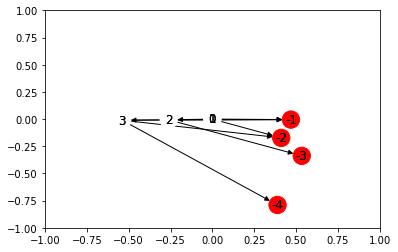

curcost 0.8285004050104713

274
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.20213876e-04 -1.73857541e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.69818400e-01 -4.85902306e-03 -9.99990003e+04 -1.17861430e+05]
 [ 4.11853289e-01 -1.72847429e-01 -9.99990003e+04 -1.11579451e+05]
 [-2.60723338e-01 -6.57626992e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.34319577e-01 -3.38103257e-01 -9.99987750e+04 -2.11262414e+05]
 [-5.38302979e-01 -1.04264688e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.89449293e-01 -7.90103079e-01 -9.99986756e+04 -3.16894043e+05]]


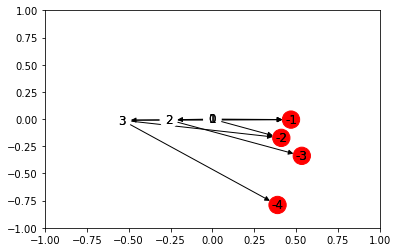

curcost 0.8284914564071032

275
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.20125790e-04 -1.73787998e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.70100291e-01 -4.86193847e-03 -9.99990003e+04 -1.17932147e+05]
 [ 4.12018030e-01 -1.72916568e-01 -9.99990003e+04 -1.11624083e+05]
 [-2.60619049e-01 -6.57363941e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.34426441e-01 -3.38170877e-01 -9.99987750e+04 -2.11304666e+05]
 [-5.38087657e-01 -1.04222982e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.89527183e-01 -7.90261100e-01 -9.99986756e+04 -3.16957422e+05]]


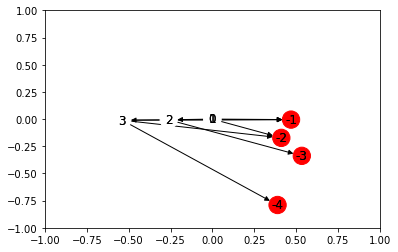

curcost 0.8284828510999733

276
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.20037740e-04 -1.73718483e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.70382351e-01 -4.86485563e-03 -9.99990003e+04 -1.18002906e+05]
 [ 4.12182837e-01 -1.72985734e-01 -9.99990003e+04 -1.11668732e+05]
 [-2.60514801e-01 -6.57100996e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.34533327e-01 -3.38238511e-01 -9.99987750e+04 -2.11346927e+05]
 [-5.37872422e-01 -1.04181293e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.89605089e-01 -7.90419152e-01 -9.99986756e+04 -3.17020813e+05]]


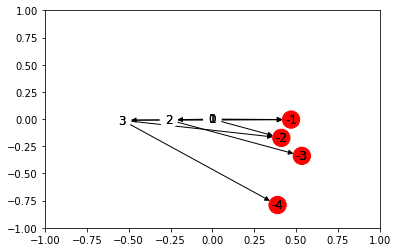

curcost 0.8284745893722967

277
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.19949725e-04 -1.73648995e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.70664580e-01 -4.86777455e-03 -9.99990003e+04 -1.18073708e+05]
 [ 4.12347711e-01 -1.73054929e-01 -9.99990003e+04 -1.11713400e+05]
 [-2.60410595e-01 -6.56838155e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.34640233e-01 -3.38306159e-01 -9.99987750e+04 -2.11389197e+05]
 [-5.37657273e-01 -1.04139621e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.89683010e-01 -7.90577236e-01 -9.99986756e+04 -3.17084217e+05]]


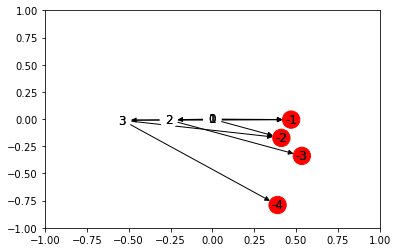

curcost 0.8284666715078278

278
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.19861745e-04 -1.73579536e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.70946979e-01 -4.87069521e-03 -9.99990003e+04 -1.18144552e+05]
 [ 4.12512650e-01 -1.73124151e-01 -9.99990003e+04 -1.11758085e+05]
 [-2.60306431e-01 -6.56575420e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.34747161e-01 -3.38373820e-01 -9.99987750e+04 -2.11431475e+05]
 [-5.37442210e-01 -1.04097965e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.89760946e-01 -7.90735351e-01 -9.99986756e+04 -3.17147634e+05]]


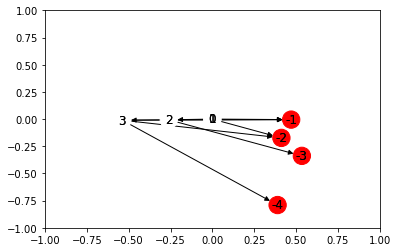

curcost 0.8284590977908608

279
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.19773800e-04 -1.73510104e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.71229547e-01 -4.87361763e-03 -9.99990003e+04 -1.18215439e+05]
 [ 4.12677655e-01 -1.73193400e-01 -9.99990003e+04 -1.11802789e+05]
 [-2.60202308e-01 -6.56312790e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.34854111e-01 -3.38441495e-01 -9.99987750e+04 -2.11473761e+05]
 [-5.37227234e-01 -1.04056326e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.89838898e-01 -7.90893498e-01 -9.99986756e+04 -3.17211064e+05]]


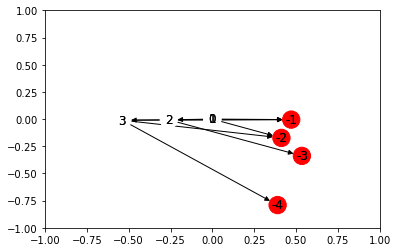

curcost 0.8284518685062292

280
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.19685891e-04 -1.73440700e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.71512285e-01 -4.87654180e-03 -9.99990003e+04 -1.18286368e+05]
 [ 4.12842726e-01 -1.73262678e-01 -9.99990003e+04 -1.11847510e+05]
 [-2.60098228e-01 -6.56050265e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.34961082e-01 -3.38509183e-01 -9.99987750e+04 -2.11516056e+05]
 [-5.37012343e-01 -1.04014703e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.89916866e-01 -7.91051677e-01 -9.99986756e+04 -3.17274506e+05]]


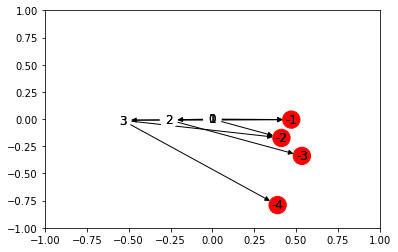

curcost 0.8284449839393087

281
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.19598017e-04 -1.73371324e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.71795193e-01 -4.87946772e-03 -9.99990003e+04 -1.18357340e+05]
 [ 4.13007863e-01 -1.73331983e-01 -9.99990003e+04 -1.11892249e+05]
 [-2.59994188e-01 -6.55787845e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.35068074e-01 -3.38576885e-01 -9.99987750e+04 -2.11558359e+05]
 [-5.36797538e-01 -1.03973097e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.89994849e-01 -7.91209887e-01 -9.99986756e+04 -3.17337961e+05]]


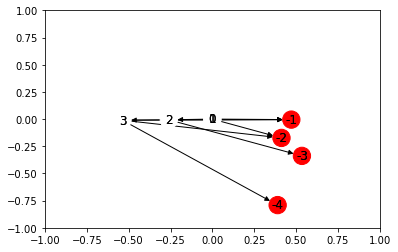

curcost 0.8284384443760148

282
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.19510177e-04 -1.73301975e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.72078270e-01 -4.88239540e-03 -9.99990003e+04 -1.18428354e+05]
 [ 4.13173066e-01 -1.73401316e-01 -9.99990003e+04 -1.11937006e+05]
 [-2.59890191e-01 -6.55525529e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.35175087e-01 -3.38644601e-01 -9.99987750e+04 -2.11600670e+05]
 [-5.36582819e-01 -1.03931508e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.90072848e-01 -7.91368129e-01 -9.99986756e+04 -3.17401429e+05]]


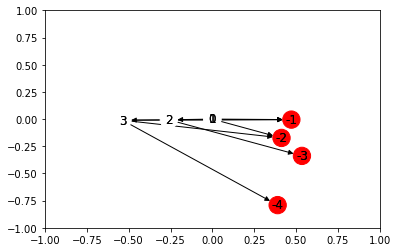

curcost 0.8284322501028063

283
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.19422373e-04 -1.73232654e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.72361517e-01 -4.88532484e-03 -9.99990003e+04 -1.18499411e+05]
 [ 4.13338335e-01 -1.73470676e-01 -9.99990003e+04 -1.11981780e+05]
 [-2.59786234e-01 -6.55263319e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.35282122e-01 -3.38712330e-01 -9.99987750e+04 -2.11642991e+05]
 [-5.36368186e-01 -1.03889935e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.90150863e-01 -7.91526403e-01 -9.99986756e+04 -3.17464909e+05]]


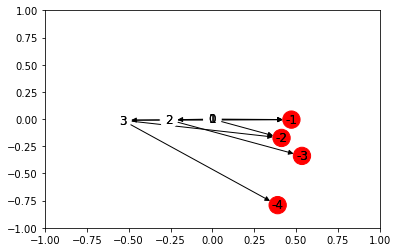

curcost 0.8284264014066836

284
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.19334604e-04 -1.73163361e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.72644934e-01 -4.88825604e-03 -9.99990003e+04 -1.18570511e+05]
 [ 4.13503671e-01 -1.73540064e-01 -9.99990003e+04 -1.12026573e+05]
 [-2.59682320e-01 -6.55001214e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.35389179e-01 -3.38780072e-01 -9.99987750e+04 -2.11685319e+05]
 [-5.36153638e-01 -1.03848379e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.90228893e-01 -7.91684708e-01 -9.99986756e+04 -3.17528402e+05]]


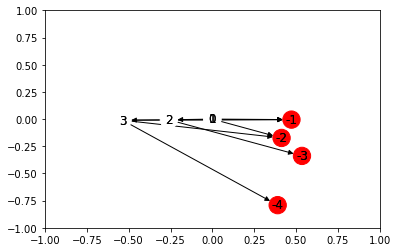

curcost 0.8284208985751913

285
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.19246871e-04 -1.73094096e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.72928520e-01 -4.89118899e-03 -9.99990003e+04 -1.18641653e+05]
 [ 4.13669072e-01 -1.73609480e-01 -9.99990003e+04 -1.12071384e+05]
 [-2.59578447e-01 -6.54739213e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.35496257e-01 -3.38847828e-01 -9.99987750e+04 -2.11727656e+05]
 [-5.35939177e-01 -1.03806840e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.90306939e-01 -7.91843045e-01 -9.99986756e+04 -3.17591907e+05]]


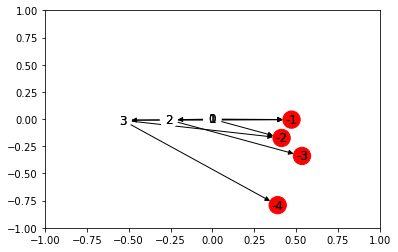

curcost 0.8284157418964176

286
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.19159172e-04 -1.73024858e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.73212278e-01 -4.89412370e-03 -9.99990003e+04 -1.18712838e+05]
 [ 4.13834540e-01 -1.73678924e-01 -9.99990003e+04 -1.12116212e+05]
 [-2.59474616e-01 -6.54477318e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.35603356e-01 -3.38915598e-01 -9.99987750e+04 -2.11770002e+05]
 [-5.35724801e-01 -1.03765317e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.90385000e-01 -7.92001414e-01 -9.99986756e+04 -3.17655426e+05]]


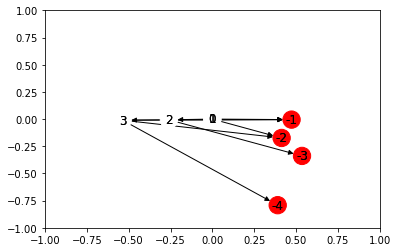

curcost 0.8284109316589963

287
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.19071508e-04 -1.72955648e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.73496205e-01 -4.89706018e-03 -9.99990003e+04 -1.18784066e+05]
 [ 4.14000074e-01 -1.73748396e-01 -9.99990003e+04 -1.12161059e+05]
 [-2.59370826e-01 -6.54215527e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.35710477e-01 -3.38983381e-01 -9.99987750e+04 -2.11812356e+05]
 [-5.35510511e-01 -1.03723811e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.90463077e-01 -7.92159814e-01 -9.99986756e+04 -3.17718957e+05]]


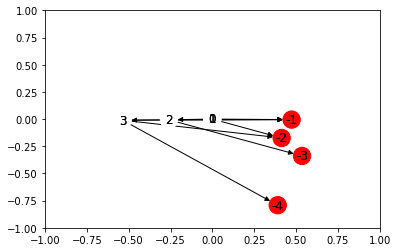

curcost 0.8284064681521057

288
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.18983879e-04 -1.72886466e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.73780303e-01 -4.89999841e-03 -9.99990003e+04 -1.18855336e+05]
 [ 4.14165674e-01 -1.73817895e-01 -9.99990003e+04 -1.12205923e+05]
 [-2.59267077e-01 -6.53953841e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.35817619e-01 -3.39051177e-01 -9.99987750e+04 -2.11854718e+05]
 [-5.35296307e-01 -1.03682322e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.90541170e-01 -7.92318246e-01 -9.99986756e+04 -3.17782501e+05]]


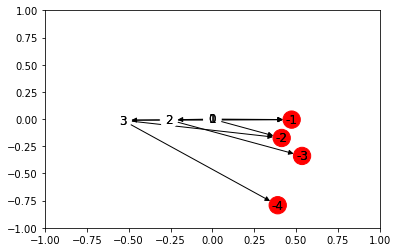

curcost 0.8284023516654703

289
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.18896286e-04 -1.72817311e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.74064571e-01 -4.90293841e-03 -9.99990003e+04 -1.18926650e+05]
 [ 4.14331340e-01 -1.73887422e-01 -9.99990003e+04 -1.12250806e+05]
 [-2.59163371e-01 -6.53692259e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.35924782e-01 -3.39118988e-01 -9.99987750e+04 -2.11897089e+05]
 [-5.35082189e-01 -1.03640849e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.90619278e-01 -7.92476709e-01 -9.99986756e+04 -3.17846057e+05]]


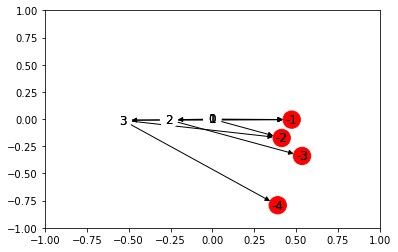

curcost 0.8283985824893622

290
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.18808727e-04 -1.72748184e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.74349010e-01 -4.90588018e-03 -9.99990003e+04 -1.18998006e+05]
 [ 4.14497072e-01 -1.73956977e-01 -9.99990003e+04 -1.12295706e+05]
 [-2.59059705e-01 -6.53430782e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.36031967e-01 -3.39186811e-01 -9.99987750e+04 -2.11939469e+05]
 [-5.34868156e-01 -1.03599392e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.90697402e-01 -7.92635205e-01 -9.99986756e+04 -3.17909626e+05]]


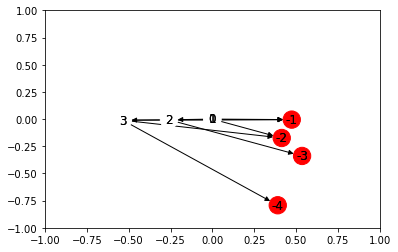

curcost 0.8283951609146002

291
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.18721204e-04 -1.72679085e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.74633619e-01 -4.90882370e-03 -9.99990003e+04 -1.19069404e+05]
 [ 4.14662871e-01 -1.74026560e-01 -9.99990003e+04 -1.12340624e+05]
 [-2.58956081e-01 -6.53169410e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.36139174e-01 -3.39254649e-01 -9.99987750e+04 -2.11981857e+05]
 [-5.34654208e-01 -1.03557953e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.90775542e-01 -7.92793732e-01 -9.99986756e+04 -3.17973208e+05]]


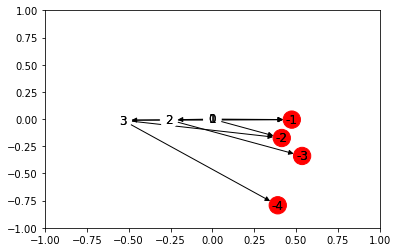

curcost 0.8283920872325518

292
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.18633715e-04 -1.72610014e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.74918399e-01 -4.91176900e-03 -9.99990003e+04 -1.19140846e+05]
 [ 4.14828736e-01 -1.74096171e-01 -9.99990003e+04 -1.12385560e+05]
 [-2.58852499e-01 -6.52908142e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.36246401e-01 -3.39322500e-01 -9.99987750e+04 -2.12024253e+05]
 [-5.34440347e-01 -1.03516530e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.90853697e-01 -7.92952291e-01 -9.99986756e+04 -3.18036803e+05]]


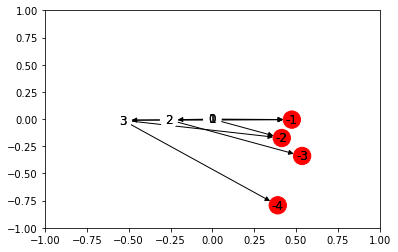

curcost 0.8283893617351336

293
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.18546262e-04 -1.72540970e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.75203350e-01 -4.91471606e-03 -9.99990003e+04 -1.19212330e+05]
 [ 4.14994668e-01 -1.74165809e-01 -9.99990003e+04 -1.12430515e+05]
 [-2.58748958e-01 -6.52646979e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.36353651e-01 -3.39390364e-01 -9.99987750e+04 -2.12066658e+05]
 [-5.34226571e-01 -1.03475123e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.90931867e-01 -7.93110881e-01 -9.99986756e+04 -3.18100410e+05]]


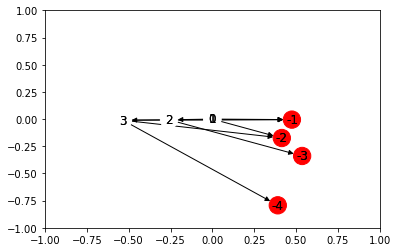

curcost 0.8283869847148118

294
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.18458843e-04 -1.72471953e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.75488472e-01 -4.91766489e-03 -9.99990003e+04 -1.19283858e+05]
 [ 4.15160666e-01 -1.74235475e-01 -9.99990003e+04 -1.12475487e+05]
 [-2.58645458e-01 -6.52385920e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.36460921e-01 -3.39458242e-01 -9.99987750e+04 -2.12109071e+05]
 [-5.34012880e-01 -1.03433733e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.91010054e-01 -7.93269503e-01 -9.99986756e+04 -3.18164030e+05]]


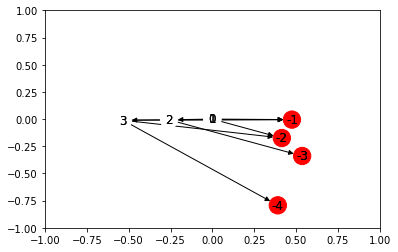

curcost 0.828384956464603

295
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.18371460e-04 -1.72402964e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.75773765e-01 -4.92061549e-03 -9.99990003e+04 -1.19355428e+05]
 [ 4.15326730e-01 -1.74305170e-01 -9.99990003e+04 -1.12520477e+05]
 [-2.58542000e-01 -6.52124966e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.36568214e-01 -3.39526134e-01 -9.99987750e+04 -2.12151493e+05]
 [-5.33799275e-01 -1.03392359e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.91088256e-01 -7.93428157e-01 -9.99986756e+04 -3.18227663e+05]]


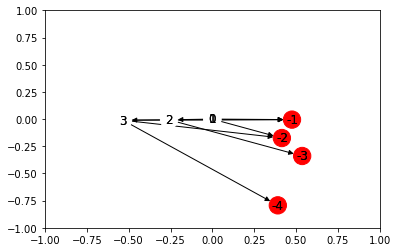

curcost 0.828383277278075

296
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.18284111e-04 -1.72334003e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.76059230e-01 -4.92356786e-03 -9.99990003e+04 -1.19427041e+05]
 [ 4.15492861e-01 -1.74374892e-01 -9.99990003e+04 -1.12565485e+05]
 [-2.58438583e-01 -6.51864116e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.36675527e-01 -3.39594039e-01 -9.99987750e+04 -2.12193923e+05]
 [-5.33585755e-01 -1.03351002e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.91166473e-01 -7.93586843e-01 -9.99986756e+04 -3.18291309e+05]]


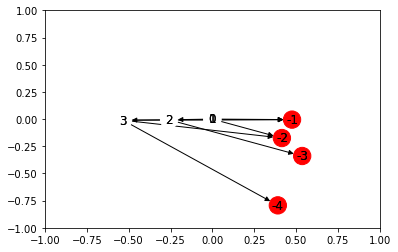

curcost 0.8283819474493482

297
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.18196798e-04 -1.72265070e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.76344865e-01 -4.92652200e-03 -9.99990003e+04 -1.19498698e+05]
 [ 4.15659058e-01 -1.74444642e-01 -9.99990003e+04 -1.12610511e+05]
 [-2.58335208e-01 -6.51603370e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.36782862e-01 -3.39661958e-01 -9.99987750e+04 -2.12236362e+05]
 [-5.33372321e-01 -1.03309662e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.91244707e-01 -7.93745560e-01 -9.99986756e+04 -3.18354967e+05]]


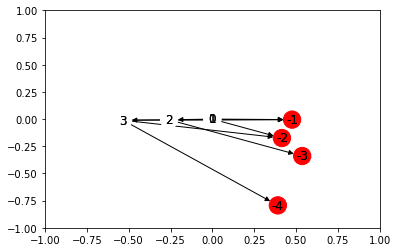

curcost 0.8283809672730948

298
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.18109519e-04 -1.72196164e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.76630672e-01 -4.92947791e-03 -9.99990003e+04 -1.19570397e+05]
 [ 4.15825321e-01 -1.74514419e-01 -9.99990003e+04 -1.12655556e+05]
 [-2.58231874e-01 -6.51342729e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.36890219e-01 -3.39729890e-01 -9.99987750e+04 -2.12278809e+05]
 [-5.33158972e-01 -1.03268338e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.91322956e-01 -7.93904309e-01 -9.99986756e+04 -3.18418638e+05]]


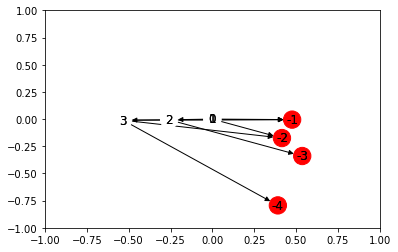

curcost 0.8283803370445415

299
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.18022275e-04 -1.72127285e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.76916650e-01 -4.93243560e-03 -9.99990003e+04 -1.19642139e+05]
 [ 4.15991652e-01 -1.74584225e-01 -9.99990003e+04 -1.12700618e+05]
 [-2.58128581e-01 -6.51082192e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.36997597e-01 -3.39797836e-01 -9.99987750e+04 -2.12321265e+05]
 [-5.32945708e-01 -1.03227031e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.91401220e-01 -7.94063090e-01 -9.99986756e+04 -3.18482322e+05]]


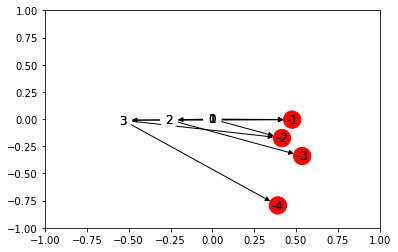

curcost 0.8283800570594683

300
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.17935066e-04 -1.72058434e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.77202800e-01 -4.93539506e-03 -9.99990003e+04 -1.19713924e+05]
 [ 4.16158048e-01 -1.74654059e-01 -9.99990003e+04 -1.12745698e+05]
 [-2.58025330e-01 -6.50821759e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.37104996e-01 -3.39865796e-01 -9.99987750e+04 -2.12363729e+05]
 [-5.32732530e-01 -1.03185740e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.91479501e-01 -7.94221903e-01 -9.99986756e+04 -3.18546018e+05]]


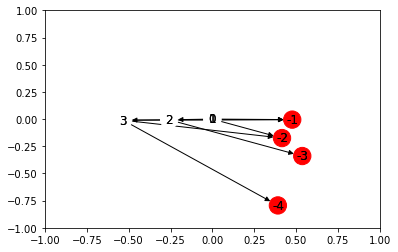

curcost 0.828380127614211

converge
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.17847892e-04 -1.71989611e-05 -3.48399000e-04 -9.99990000e+04]
 [ 4.77489122e-01 -4.93835630e-03 -9.99990003e+04 -1.19785753e+05]
 [ 4.16324511e-01 -1.74723921e-01 -9.99990003e+04 -1.12790796e+05]
 [-2.57922120e-01 -6.50561430e-03  2.24972808e-01 -1.99998000e+05]
 [ 5.37212417e-01 -3.39933769e-01 -9.99987750e+04 -2.12406202e+05]
 [-5.32519437e-01 -1.03144466e-02  3.24364498e-01 -2.99997000e+05]
 [ 3.91557796e-01 -7.94380747e-01 -9.99986756e+04 -3.18609727e+05]]


In [261]:
a.gd(iterations = 1000, learning_rate = 0.0001, stopping_threshold = 0.1, posegraph = True) #Remember to Change

# Convergence of Gradient Descent

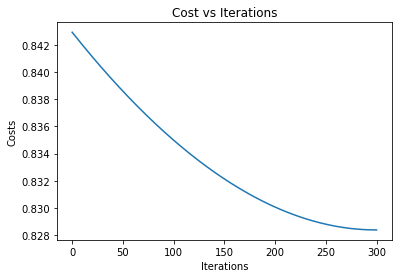

In [262]:
a.prcost()

# Comparison of Accuracy

Initial vs Ground Truth

In [263]:
initial = a.nodedata[np.where(a.node>0)] 
groundtruth = np.array([[0,0],[-0.2,0],[-0.4,0],[0,0]])
initialxy = []
initialdiff = []
initialL2 = []

for i in range(len(initial)):
    initialxy.append(initial[i][0:2].round(decimals = 3) )
    diff = initial[i][0:2]-groundtruth[i]
    initialdiff.append(diff.round(decimals = 3) )
    initialL2.append(np.linalg.norm(diff).round(decimals = 3) )

Optimized Estimate vs Ground Truth

In [264]:
optim = a.converge[np.where(a.node>0)] 
groundtruth = np.array([[0,0],[-0.2,0],[-0.4,0],[0,0]])
optimxy = []
optimdiff = []
optimL2 = []

for i in range(len(optim)):
    optimxy.append(optim[i][0:2].round(decimals = 3) )
    diff = optim[i][0:2]-groundtruth[i]
    optimdiff.append(diff.round(decimals = 3) )
    optimL2.append(np.linalg.norm(diff).round(decimals = 3) )

In [265]:
compare = pd.DataFrame(list(zip(groundtruth, initialxy, initialdiff, initialL2, optimxy, optimdiff, optimL2)), columns = ('groundtruth', 'initialxy', 'initialdiff', 'initialL2', 'optimxy', 'optimdiff', 'optimL2'))

compare

groundtruth         initialxy       initialdiff  initialL2  \
0   [0.0, 0.0]       [0.0, -0.0]       [0.0, -0.0]      0.000   
1  [-0.2, 0.0]  [-0.291, -0.007]  [-0.091, -0.007]      0.091   
2  [-0.4, 0.0]  [-0.601, -0.012]  [-0.201, -0.012]      0.201   

            optimxy         optimdiff  optimL2  
0       [0.0, -0.0]       [0.0, -0.0]    0.000  
1  [-0.258, -0.007]  [-0.058, -0.007]    0.058  
2   [-0.533, -0.01]   [-0.133, -0.01]    0.133

# To Do List
1) set up controlled experiment for camera, manually extract following data (pose to pose movement, pose to frame movements, 

1) Experimental Data.
2) Offline Algorithm

*mention that initial pose tagged to global frame.
*why cost function?

In [266]:
#a.nodedata[np.where(a.node>0)]